# 1. Synchrotron and Synchrotron Self Compton
In this tutorial we will show how to compute the Spectral Energy Distribution produced by the Synchrotron and Synchrotron Self-Compton radiative processes in a jetted AGN.

We will also 

In [19]:
# import numpy, astropy and matplotlib for basic functionalities
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import Distance
import pkg_resources
import matplotlib.pyplot as plt
from IPython.core.display import Image, display

In [2]:
# import agnpy classes
from agnpy.emission_regions import Blob
from agnpy.synchrotron import Synchrotron
from agnpy.compton import SynchrotronSelfCompton
from agnpy.utils.plot import plot_sed, load_mpl_rc

### Emission Region
Let us consider that the emission region is a spherical plasmoid of radius $R_b = 10^{16}\,\mathrm{cm}$, streaming with Lorentz factor $\Gamma=10$ in the AGN jet, resulting in a Doppler boosting of $\delta_D=10$ (the jet is almost aligned with the observer's line of sight). The galaxy hosting the active nucleus is at a distance of $d_L=10^{27}\,\mathrm{cm}$. The blob has a tangled magnetic field $B=1\,\mathrm{G}$. The electron spectrum is described by a power law with index $-2.8$ and a total energy content of $W_e = 10^{48}\,{\rm erg}$.

In [3]:
# total energy content of the electron distribution
spectrum_norm = 1e48 * u.Unit("erg")

# dictionary describing the electron distribution
spectrum_dict = {
    "type": "PowerLaw", 
    "parameters": {
        "p": 2.8, 
        "gamma_min": 1e2, 
        "gamma_max": 1e7
    }
}
R_b = 1e16 * u.cm
B = 1 * u.G
z = Distance(1e27, unit=u.cm).z
delta_D = 10
Gamma = 10
# emission region
blob = Blob(R_b, z, delta_D, Gamma, B, spectrum_norm, spectrum_dict)

In [4]:
# the blob object is printable, returning a summary of its properties
print(blob)

* spherical emission region
 - R_b (radius of the blob): 1.00e+16 cm
 - V_b (volume of the blob): 4.19e+48 cm3
 - z (source redshift): 0.07
 - d_L (source luminosity distance):1.00e+27 cm
 - delta_D (blob Doppler factor): 1.00e+01
 - Gamma (blob Lorentz factor): 1.00e+01
 - Beta (blob relativistic velocity): 9.95e-01
 - theta_s (jet viewing angle): 5.74e+00 deg
 - B (magnetic field tangled to the jet): 1.00e+00 G
 - xi (coefficient for 1st order Fermi acceleration) : 1.00e+00
* electron spectrum
 - power law
 - k_e: 9.27e+06 1 / cm3
 - p: 2.80
 - gamma_min: 1.00e+02
 - gamma_max: 1.00e+07


In [5]:
# we can also print the total electrons number and energy
print(f"total particle number: {blob.N_e_tot:.2e}")
print(f"total energy in electrons: {blob.W_e:.2e}")

total particle number: 5.44e+51
total energy in electrons: 1.00e+48 erg


In [6]:
# as well as the jet power in particles and magnetic fields (see the documentation for more details)
print(f"jet power in particles: {blob.P_jet_e:.2e}")
print(f"jet power in magnetic field: {blob.P_jet_B:.2e}")

jet power in particles: 4.47e+44 erg / s
jet power in magnetic field: 7.46e+43 erg / s


### Synchrotron Radiation
To intitialise the object that will compute the synchrotron radiation, we simply pass the `Blob` instance to the `Synchrotron` class. The synchrotron self absorption can be considered when computing the SED.

In [7]:
synch = Synchrotron(blob)
synch_ssa = Synchrotron(blob, ssa=True)

In [37]:
# let us define now a grid of frequencies over which to calculate the synchrotron SED
nu_synch = np.logspace(8, 23) * u.Hz
# let us compute a synchrotron, and a self-absorbed synchrotron SED
sed_synch = synch.sed_flux(nu_synch)
sed_synch_ssa = synch_ssa.sed_flux(nu_synch)

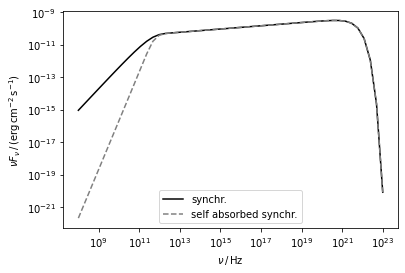

In [38]:
plot_sed(nu_synch, sed_synch, color="k", label="synchr.")
plot_sed(nu_synch, sed_synch_ssa, ls="--", color="gray", label="self absorbed synchr.")
plt.show()

### Synchrotron Self-Compton Radiation
Similarly to the synchrotron case, to intitialise the object that will compute the synchrotron self-Compton (SSC) radiation, we simply pass the `Blob` instance to the `SynchrotronSelfCompton` class.       
We examine also the case produced by scattering over a self-absorbed synchrotron spectrum.

In [11]:
# simple ssc
ssc = SynchrotronSelfCompton(blob)
# ssc over a self-absorbed synchrotron spectrum
ssc_ssa = SynchrotronSelfCompton(blob, ssa=True)

In [12]:
nu_ssc = np.logspace(15, 30) * u.Hz
sed_ssc = ssc.sed_flux(nu_ssc)
sed_ssc_ssa = ssc_ssa.sed_flux(nu_ssc)

/home/cosimo/work/agnpy/agnpy/synchrotron/synchrotron.py:66: RuntimeWarning: divide by zero encountered in true_divide
  u = 1 / 2 + np.exp(-tau) / tau - (1 - np.exp(-tau)) / np.power(tau, 2)
/home/cosimo/work/agnpy/agnpy/synchrotron/synchrotron.py:66: RuntimeWarning: invalid value encountered in true_divide
  u = 1 / 2 + np.exp(-tau) / tau - (1 - np.exp(-tau)) / np.power(tau, 2)


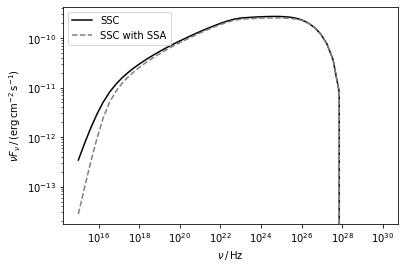

In [13]:
plot_sed(nu_ssc, sed_ssc, color="k", label="SSC")
plot_sed(nu_ssc, sed_ssc_ssa, ls="--", color="gray", label="SSC with SSA")
plt.show()

### Literature Check from Dermer and Menon (2009)
In order to provide a cross-check with the literature, we reproduce Figure 7.4 of Dermer and Menon (2009) - [see bibliography in the docs](https://agnpy.readthedocs.io/en/latest/bibliography.html). The figure, reported here, depicts two complete synchrotron and SSC SEDs, generated by the same emission regions distinguished only by the different maximum Lorentz factor of their electron distributions ($\gamma_{\rm max} = 10^5$ and $\gamma_{\rm max} = 10^7$).


In [60]:
url="https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png"
display(Image(url))

FileNotFoundError: No such file or directory: '





<!DOCTYPE html>
<html lang="en" data-color-mode="auto" data-light-theme="light" data-dark-theme="dark">
  <head>
    <meta charset="utf-8">
  <link rel="dns-prefetch" href="https://github.githubassets.com">
  <link rel="dns-prefetch" href="https://avatars.githubusercontent.com">
  <link rel="dns-prefetch" href="https://github-cloud.s3.amazonaws.com">
  <link rel="dns-prefetch" href="https://user-images.githubusercontent.com/">
  <link rel="preconnect" href="https://github.githubassets.com" crossorigin>
  <link rel="preconnect" href="https://avatars.githubusercontent.com">



  <link crossorigin="anonymous" media="all" integrity="sha512-dkuYFW+ra8yYSt342e5pJEeslPSjMcrMvNxlYZMyM/X+/WJHDPvoCuGq3LFojI7B0dQWwZNRiPMnbi9IfUgTaA==" rel="stylesheet" href="https://github.githubassets.com/assets/light-764b98156fab6bcc984addf8d9ee6924.css" /><link crossorigin="anonymous" media="all" integrity="sha512-UrAu23+eyncWvaQFwsLbgSKtmLb2aH1bcT4hJnnRdkaPuY1eu9bumt33FyHHFDX8hskTUNWNkIsMCz7FWQQHwA==" rel="stylesheet" href="https://github.githubassets.com/assets/dark-52b02edb7f9eca7716bda405c2c2db81.css" /><link data-color-theme="dark_dimmed" crossorigin="anonymous" media="all" integrity="sha512-kyu73YWtU8Fu2e7p+Hv094CRhaTvr8yy95vc1SQ2+MeWVWakGeIh/lv9yIFaYAb8J3oM6uBLGcn1kS6M1GxBCQ==" rel="stylesheet" data-href="https://github.githubassets.com/assets/dark_dimmed-932bbbdd85ad53c16ed9eee9f87bf4f7.css" /><link data-color-theme="dark_high_contrast" crossorigin="anonymous" media="all" integrity="sha512-jZSKF7Gx8T/AFthO0CUkWWpG5EBlIZb+tIYu8KgP/kizn7fpXEiXJcB73GTZ69wSVVSZ6Y1Cw286qP7pVZr0gg==" rel="stylesheet" data-href="https://github.githubassets.com/assets/dark_high_contrast-8d948a17b1b1f13fc016d84ed0252459.css" /><link data-color-theme="dark_colorblind" crossorigin="anonymous" media="all" integrity="sha512-E02WD8opZPpYu6LM9dlUSIHQgXtLmzi1KxMnaN/SA7k6ILsvpNJjpkBPU1sC98MitAOkCNIe6ozqY8+pHnrHZg==" rel="stylesheet" data-href="https://github.githubassets.com/assets/dark_colorblind-134d960fca2964fa58bba2ccf5d95448.css" /><link data-color-theme="light_colorblind" crossorigin="anonymous" media="all" integrity="sha512-VWdBPHZj3WCDwaO0N2W8yvDZt7TNZohRIYK4sjjSU56485rCWazxnLr4p3DU8eqn2+eSj3CYYpw4+DzmwHOwew==" rel="stylesheet" data-href="https://github.githubassets.com/assets/light_colorblind-5567413c7663dd6083c1a3b43765bcca.css" /><link data-color-theme="light_high_contrast" crossorigin="anonymous" media="all" integrity="sha512-dw8LrBQMvo9HDd5lo2UEp/tvMVR6zJjrQkQTBVrhyaHDlL1p7UiQ9/xpqYxOz9s7s1Qh5Bjokuzu7NX0U5BeYA==" rel="stylesheet" data-href="https://github.githubassets.com/assets/light_high_contrast-770f0bac140cbe8f470dde65a36504a7.css" />
  <link crossorigin="anonymous" media="all" integrity="sha512-na4wzpzKdoCbEgMMie5/+OzNZRFpktZGbdkAaPFu8Pg4PoBV0nk8DQCDAgutGApM6P6RLMbajUJ154wxygx4eg==" rel="stylesheet" href="https://github.githubassets.com/assets/frameworks-9dae30ce9cca76809b12030c89ee7ff8.css" />
  <link crossorigin="anonymous" media="all" integrity="sha512-wF63maqlHvNm3B9T707ri55ujyyHsgyjjAUz47evlIT0N3l6OA5HHNFx6YsVMNjuTgkcKCQUAvNKmPN/tCWJzQ==" rel="stylesheet" href="https://github.githubassets.com/assets/behaviors-c05eb799aaa51ef366dc1f53ef4eeb8b.css" />
  <link crossorigin="anonymous" media="all" integrity="sha512-MCJFYfbQoT4EXC6aWx5Wghs8FC/jslHEeN2iWXphliccmede2dQlhIBTAUCBq9Yu5poltu4askungzvyCsycGg==" rel="stylesheet" href="https://github.githubassets.com/assets/tab-size-fix-30224561f6d0a13e045c2e9a5b1e5682.css" />
  
  
  
  <link crossorigin="anonymous" media="all" integrity="sha512-0twCKOt859rZtNW0y5svV8tkbOM/78cLnG5JPTFyqiWFnt8Iwdhe6wFMY63FIkpw1xJEfoV4DRx5xTTaBws+JA==" rel="stylesheet" href="https://github.githubassets.com/assets/github-d2dc0228eb7ce7dad9b4d5b4cb9b2f57.css" />

    <script crossorigin="anonymous" defer="defer" integrity="sha512-OkK3fRmV+6QskfL1Q5E2mJkxBE5BE38ikBXUAetuWt6fldU1MytPY9+cFV8pWWyW9Qee7p/KUP+fTICmTTaejQ==" type="application/javascript" src="https://github.githubassets.com/assets/environment-3a42b77d.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-dfFktEHzdz1BE39PCnERakU5SzVncxtopzDnIyoVGlQDOqQdlbO0lUOd3RM4g0Txe0Q4EDAixFyqtb5oRVmVRw==" type="application/javascript" src="https://github.githubassets.com/assets/chunk-frameworks-75f164b4.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-3SMUGSqntoE+g4d7dJvowqRAX633gsU2zhhDUFNubAQ0DvEULAbDbFdFyPBQ3v7HtI+7rSXHfaHiinI+Qpwg1Q==" type="application/javascript" src="https://github.githubassets.com/assets/chunk-vendor-dd231419.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-7MfF0/gAVjt8HUQuIvpTPn5I6aWTmsBVWyZtvEW8SdycNRRhVg2yGMvbIw6YOmKEPxS/90PPAYbBSP2lHxYzog==" type="application/javascript" src="https://github.githubassets.com/assets/behaviors-ecc7c5d3.js"></script>
  
    <script crossorigin="anonymous" defer="defer" integrity="sha512-s29T5r7y591Z4m7jsJtkZdSy2BSgcbUhqOZxQzmImaMYoDdL2MLvaLIvhd1lee/y4dg++F9OOLWxQ4P1cj+WwQ==" type="application/javascript" data-module-id="./chunk-action-list-element.js" data-src="https://github.githubassets.com/assets/chunk-action-list-element-b36f53e6.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-pTTrav4l7gbsAu4I8D/EeswJmvjNoSDQG+m8IxXwFHEZ1guasobEmCNB3H5gy9brild3bKp5LqpoPzwx631/rA==" type="application/javascript" data-module-id="./chunk-advanced.js" data-src="https://github.githubassets.com/assets/chunk-advanced-a534eb6a.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-iG8aKaXiAy7ONu7OJuY1pf3FGFzrs4mYYGnUD47a1kXP5URyMlP1RpAFyWTFeyirHY/UoR2mmkkBD40j/9ouPA==" type="application/javascript" data-module-id="./chunk-animate-on-scroll.js" data-src="https://github.githubassets.com/assets/chunk-animate-on-scroll-886f1a29.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-hYDRBXAASsg/XNBqynH5m9egXuA4fHRv7fGWVHtBKjo45Ab7YdMD+qPEHilOkt4hr7KDVUzw+gvdeFlCrVKZmQ==" type="application/javascript" data-module-id="./chunk-area.js" data-src="https://github.githubassets.com/assets/chunk-area-8580d105.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-fGJW2FSExsEpobx9Kb2rYgeTIybR41QnA2lLfgJw31XzbfY+2jfbuR433ljZ1Der3vxUWJoxnpAiLym/HVvUAA==" type="application/javascript" data-module-id="./chunk-array.js" data-src="https://github.githubassets.com/assets/chunk-array-7c6256d8.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-M8jPwsBBe5XZ6fhEaOJ6vNjt3sjRFi6kSxzLb+0wuMCkN5PRaqAuR8XkHLF6Ljz/mwRyjYsxffx1bL1e0Sumpg==" type="application/javascript" data-module-id="./chunk-async-export.js" data-src="https://github.githubassets.com/assets/chunk-async-export-33c8cfc2.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-E6oAz1QHJPTJfIGSZeB/PYa16h9x+1+4lxN2fe3zCeL/MxYuXtqQ5jFnd3cWtb4dRH0lxbALog3Vmap6pKQCAA==" type="application/javascript" data-module-id="./chunk-band.js" data-src="https://github.githubassets.com/assets/chunk-band-13aa00cf.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-Ajvp4eWVlyj0gO7hyo70jk7tNkGS/5rzpKfuIcfdpXSyTN3kwLKL15B4JEbjgXKkyd/dNN1mX7h8uQkxxLoeTw==" type="application/javascript" data-module-id="./chunk-bar-chart.js" data-src="https://github.githubassets.com/assets/chunk-bar-chart-023be9e1.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-ts+QjRdJ8l4YeV4z8foKCE8+AXJ3uSCGpWPjcVyut5LRzvgdtDXLpy1LYSyBpy7E0PlkRswBVgw1Va/EQ7d5lA==" type="application/javascript" data-module-id="./chunk-branch-from-issue-button.js" data-src="https://github.githubassets.com/assets/chunk-branch-from-issue-button-b6cf908d.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-fW4j8eGUwRCMvzRl8ybeZwMwhs8EyPq2tfB7mwpSAY/NOePvDn79lWmJhOH0M/LEeWZy/khS4uYVNMtsKHv0kg==" type="application/javascript" data-module-id="./chunk-code-frequency-graph-element.js" data-src="https://github.githubassets.com/assets/chunk-code-frequency-graph-element-7d6e23f1.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-ANcH3q0YSGDR23VCqL/FKPIKewceV/uoj6Rfii7KNo2lUiGhjLPgwtkATWWZyR8OhIMjsc+9LR+KzTfkIy/pSw==" type="application/javascript" data-module-id="./chunk-codemirror.js" data-src="https://github.githubassets.com/assets/chunk-codemirror-00d707de.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-JzgkuDECne1pSMuCeKgrahMjbTRn6ucMKHPekcNzZJU8LuTFndvIoaI11sdas7kFFEF3kvmK2iKadUx0L6P6mA==" type="application/javascript" data-module-id="./chunk-codespaces-policy-form-element.js" data-src="https://github.githubassets.com/assets/chunk-codespaces-policy-form-element-273824b8.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-xhSAO0KtnFAlRqAK+mg8BPj/J334ccvnCmmjmBQBCgZcsoO9teHJSS6oAn3XOWYFsWPU2JehwG7S3OVEbLwdUg==" type="application/javascript" data-module-id="./chunk-color-modes.js" data-src="https://github.githubassets.com/assets/chunk-color-modes-c614803b.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-61Wa0kWb94YZsry3ucPWbDJV9zzP7ag8kivTVfcb7tyIuBXzb8yCxLclr4yZepEeuIVHFnxYFIF44tWhoALv9w==" type="application/javascript" data-module-id="./chunk-command-palette-page-element.js" data-src="https://github.githubassets.com/assets/chunk-command-palette-page-element-eb559ad2.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-7tuVhi/5l3tU55d+BrN6T/sfSnp/K+AOJxNIaiqjsSndTpU/V/z7+nBgEbCtZqiJoTv0DAQvYiVYbT0RsYiYPg==" type="application/javascript" data-module-id="./chunk-command-palette-page-stack-element.js" data-src="https://github.githubassets.com/assets/chunk-command-palette-page-stack-element-eedb9586.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-snP96kA5Q2GdcAG6NXGZIsHvuVFzK020dG0d8F14Be/mvTYSF27cW207AWi3fES/2ZpMFWsGhfDUTkmqlSzSnw==" type="application/javascript" data-module-id="./chunk-community-contributions.js" data-src="https://github.githubassets.com/assets/chunk-community-contributions-b273fdea.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-HDsLJf6gAN+WDFaJneJwmIY82XkZKWqeX7tStBLRh1XM53K8vMV6JZvjq/UQXszaNVWxWcuYtgYTG6ZWo8+QSw==" type="application/javascript" data-module-id="./chunk-confetti.js" data-src="https://github.githubassets.com/assets/chunk-confetti-1c3b0b25.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-3W46fSBMvt8hnBUTSCHAAPbt4DHI5VXdI2qT0YMyv8sco5NvjmGHp2M0OlTNxepPEOb8LCplxxzCwrgMubsIug==" type="application/javascript" data-module-id="./chunk-contributions-spider-graph.js" data-src="https://github.githubassets.com/assets/chunk-contributions-spider-graph-dd6e3a7d.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-AdShwMIaVrtYr+LC9cc7rsC64wQJgoCdDjLJXaD4kVhdmuld7dk748AQueuoomE4OZypdoHSPmxQ56Wge/qtig==" type="application/javascript" data-module-id="./chunk-cookies.js" data-src="https://github.githubassets.com/assets/chunk-cookies-01d4a1c0.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-jitxouuFY6SUcDZV5W3jhadVEIfFBfCQZxfPV3kxNnsWEBzbxMJFp0ccLb7+OlBjSs1zU/MNtuOV6T9Ay7lx4w==" type="application/javascript" data-module-id="./chunk-copy.js" data-src="https://github.githubassets.com/assets/chunk-copy-8e2b71a2.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-miaiZ1xkDsWBUsURHOmeYtbgVKQGnm1octCo/lDXUmPzDyjtubnHULRVw1AK+sttwdwyB0+LOyhIVAWCNSGx+A==" type="application/javascript" data-module-id="./chunk-delayed-loading-element.js" data-src="https://github.githubassets.com/assets/chunk-delayed-loading-element-9a26a267.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-dodk1egdmvJ6QICRlY32TFkNvYN5PnW+cs/3CtUotw4Z+mJrTqfU6zp0gb4PAWE2eyyY9LEnD/agtRZHeU043g==" type="application/javascript" data-module-id="./chunk-discussion-page-views.js" data-src="https://github.githubassets.com/assets/chunk-discussion-page-views-768764d5.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-clkat3eiO/K9e0qU2tUIQ3i+8lYfol0RErEaRthSk8i9090whAS/FQbqYQ57nuww4oY7g9DfdEyQ3LHXVpq+JA==" type="application/javascript" data-module-id="./chunk-discussions-daily-contributors.js" data-src="https://github.githubassets.com/assets/chunk-discussions-daily-contributors-72591ab7.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-BYwETJQt0F1UmLFw89mE46CtRPeVcABZ9byxjtgBtWIOOuM7E8l7F/xUAklCxl8N4zQfKigVls5ROlxXMzT1SQ==" type="application/javascript" data-module-id="./chunk-discussions-new-contributors.js" data-src="https://github.githubassets.com/assets/chunk-discussions-new-contributors-058c044c.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-T092OZtYeslxDIimT2TR4IWlO+6B9q6zenOAqRekKME3TgdR1nKinRgV0PTYZ3Y3IITjimtvjqQpN5kW11o0bw==" type="application/javascript" data-module-id="./chunk-drag-drop.js" data-src="https://github.githubassets.com/assets/chunk-drag-drop-4f4f7639.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-EvJ2Fip59DXgARNuwTWgjdVqoCjhXQL73SP9yexijlWStKq92sfbKeGK5R4wIP0QOr39WsnW/Kaw3Wpl1QPfog==" type="application/javascript" data-module-id="./chunk-edit-hook-secret-element.js" data-src="https://github.githubassets.com/assets/chunk-edit-hook-secret-element-12f27616.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-lJhSlHBxDYfafMGsvjfmbReBxHE64RGTSucXtcG3vTpWvu2vlw/heQjiHB+JwYpnWvcXh0Tn9oLlo90LEpUfIA==" type="application/javascript" data-module-id="./chunk-edit.js" data-src="https://github.githubassets.com/assets/chunk-edit-94985294.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-6WJL+zyYirKxwD8MNBenuxbMKvCeskXBrXISNlqhV3kltmI8kiSjUX0nDQM3fXeSakcll12sYS8Pli1GFPtG9Q==" type="application/javascript" data-module-id="./chunk-emoji-picker-element.js" data-src="https://github.githubassets.com/assets/chunk-emoji-picker-element-e9624bfb.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-euLLeTFpj2DeM/lF0qLZedbrh2iLKL86jMNj8ydBs0Dr24s0ZxmdYnenUo2UIVD8r3t2DgXaahNQmstHlXpmtA==" type="application/javascript" data-module-id="./chunk-extent.js" data-src="https://github.githubassets.com/assets/chunk-extent-7ae2cb79.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-aGaoVKNIqNkSpelOnfn0UCDbQLW2XBUVVkOOgVZXFNDfgJgFQNMXALc0964DwIi9kYrkYQIShePOSMFo20hHkw==" type="application/javascript" data-module-id="./chunk-feature-callout-element.js" data-src="https://github.githubassets.com/assets/chunk-feature-callout-element-6866a854.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-iOOLdgqJ+9nIsmgDk8G3/VXnNT5WVKtigTTDNim7RiAGAwo5ZhHeiwPKyxnPdpHoUhusFkQOyjv/G5+mPAaY6Q==" type="application/javascript" data-module-id="./chunk-filter-input.js" data-src="https://github.githubassets.com/assets/chunk-filter-input-88e38b76.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-D576CjzS9sbDqFBJdq0Y6+KVMHXkO6mLFO/GRL1NtoE8jgXjAvmdjoZ4nNMWyDwqbtBHspvupORzE9L+YoBLYQ==" type="application/javascript" data-module-id="./chunk-get-repo-element.js" data-src="https://github.githubassets.com/assets/chunk-get-repo-element-0f9efa0a.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-Q8q7N7XzNXhgaWGGb+GJg1j747S64eBnN4i9fBnc2ZC+iaTX4RNv7nP9QyHXBqKHusT2KuXfOGc2hO6STYS38A==" type="application/javascript" data-module-id="./chunk-input-demux.js" data-src="https://github.githubassets.com/assets/chunk-input-demux-43cabb37.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-91JzWtpBUoC7Z4dQpeXRegjwCMooGPFtg/vXxaIGVTxguoOcI/hEdyM7otQGRNQmMencK71thI0oGt11Wgfrww==" type="application/javascript" data-module-id="./chunk-insights-query.js" data-src="https://github.githubassets.com/assets/chunk-insights-query-f752735a.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-sE4dojYYdXzCH2mW9sxRpbZtrAk+95XEg/s06mKmvSFv+jT8hz1DQqLzkwlHEbuzqE1J2OwryJ43VO57yUe7Fw==" type="application/javascript" data-module-id="./chunk-invitations.js" data-src="https://github.githubassets.com/assets/chunk-invitations-b04e1da2.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-aKdgEg1Yh8ahvmheu48kaMLVl0CTwmUhT7jo6nT++OQ1OzdpowkZs/2iWNuNNdp7kKubDfLVv3xhUn1Mchfg4A==" type="application/javascript" data-module-id="./chunk-jump-to.js" data-src="https://github.githubassets.com/assets/chunk-jump-to-68a76012.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-L2jxBDS9QAN9O1qn7LqMcs0YJn/gF6xW73zSbWPRlVCEnG05dexaoJWkAG6RqALTnXLsj2GTUKnba6DATR828g==" type="application/javascript" data-module-id="./chunk-launch-code-element.js" data-src="https://github.githubassets.com/assets/chunk-launch-code-element-2f68f104.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-Agzv3JB+hMWrw5dZ5l1nWlMFz4U9s0XtcS5yphek09Us1YXDfOzgQaDVAW4XwMHaun8UZ5WyAdSUCerGhi3VmA==" type="application/javascript" data-module-id="./chunk-line-chart.js" data-src="https://github.githubassets.com/assets/chunk-line-chart-020cefdc.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-JAfdu6lgGs86fcTO8wYQzT66kMlf29Ts9pyn6TK9J1L+8qqry7T2Bls4vAwrnZmCBTBe/tvefX06vII1AU8NeA==" type="application/javascript" data-module-id="./chunk-line.js" data-src="https://github.githubassets.com/assets/chunk-line-2407ddbb.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-/aeCyqce6ZXQsbffMMOuM0/qHzl5ZjPUwlsazZq+et04+Z7ERw8sBmMHrOT2fLsgOn3NqMpse970WYioIvaGzg==" type="application/javascript" data-module-id="./chunk-linear.js" data-src="https://github.githubassets.com/assets/chunk-linear-fda782ca.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-VgXsf/QtnIz5B5ngpQiPBYgV/RiukslwG4v/s5UnI65K7zovAljy0GmrHxC/V4duAZr+gHBZR3m+DVPYWANq9A==" type="application/javascript" data-module-id="./chunk-memex-project-picker-element.js" data-src="https://github.githubassets.com/assets/chunk-memex-project-picker-element-5605ec7f.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-cvjyIYhR2ZkuFAXHYZSjPTc5wXYOdISgqbXw69CXpDXdxffXmXuzjCcGJNVk3mDNYsVH4Q9sb2UMNPFrNxxRUQ==" type="application/javascript" data-module-id="./chunk-metric-selection-element.js" data-src="https://github.githubassets.com/assets/chunk-metric-selection-element-72f8f221.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-Ao9llFIlj54ApuKf2QLboXukbu2h7MHfMmtYHrrsVe1lprKNLiA0usVcRpvruKhfT5STDuWm/GGmyx8ox27hWQ==" type="application/javascript" data-module-id="./chunk-notification-list-focus.js" data-src="https://github.githubassets.com/assets/chunk-notification-list-focus-028f6594.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-W3TFrSn3Iqu38aVxxYxFiNGzaVmLXtGfwRDVRH1RwRvqPVerX1fjQPEYag+HqAoWaGy5ssVFp42oyOIV93afBw==" type="application/javascript" data-module-id="./chunk-overview.js" data-src="https://github.githubassets.com/assets/chunk-overview-5b74c5ad.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-flRmBhruEriJe/Lqh9+NMpeEiCEXozFZ+ST1HVMFUiKLmANqnltoQrnzQJW/CA5Xuxr0XBo6PrCCzekHc5fyaQ==" type="application/javascript" data-module-id="./chunk-prefetched-provider.js" data-src="https://github.githubassets.com/assets/chunk-prefetched-provider-7e546606.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-tw9SApiMkftVBYeb6/VGhEwGNw8tlyBhXc9RVXH4UbCD6u+48uuCMvXf3bxvBdOld0OoYg83SnD2mgJWhdaTiQ==" type="application/javascript" data-module-id="./chunk-premium-runners.js" data-src="https://github.githubassets.com/assets/chunk-premium-runners-b70f5202.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-vpoUvguAAa407MM8rCOkmVR8haIGkvj5iav0VFOnIQc0cGwu+pm7QdqhY2HMB5WGdFC0zJgLfVSY+dgr5rKKLg==" type="application/javascript" data-module-id="./chunk-presence-avatars.js" data-src="https://github.githubassets.com/assets/chunk-presence-avatars-be9a14be.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-5H5N/3G/20nmVKntphXb9z0H9q3URFDmHSccLhFkMSA8ILAA9mYlRKCWAWoDcl/W437jtGw1tIxjWStfInvidw==" type="application/javascript" data-module-id="./chunk-profile-pins-element.js" data-src="https://github.githubassets.com/assets/chunk-profile-pins-element-e47e4dff.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-vFR+IqThljOLrAWmjhOL/kiQrjgZZg95uPovX0J7kRH5p7Y049LDRZaXLMDijfeqqk71d3MMn9XP5bUcH+lB9w==" type="application/javascript" data-module-id="./chunk-profile.js" data-src="https://github.githubassets.com/assets/chunk-profile-bc547e22.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-ooYcnNLBDnMePhMvdQEQiItFZowYg4gwklGZGCrAWPW1LCxePPkzB1kr8U3Bay0NPKYEDmICeXBqqDPd8EDmqA==" type="application/javascript" data-module-id="./chunk-project-picker-element.js" data-src="https://github.githubassets.com/assets/chunk-project-picker-element-a2861c9c.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-YP7eMAfiHrPgPF2cz3rk5a1JMXuuMr8nOCpGJgqsfSNXkO/rzO3knnGunruo5ls3aAjD0Z85xVRRYqsbwJnkQA==" type="application/javascript" data-module-id="./chunk-pulse-authors-graph-element.js" data-src="https://github.githubassets.com/assets/chunk-pulse-authors-graph-element-60fede30.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-4Dvmms6NEhoUtRIOVySQyuxo4pc+5+AUsmnzfsDOXFRwjBHepSwTGqsbO+hHpBzrtYIjqIjaXA+6cDjyJy+HqA==" type="application/javascript" data-module-id="./chunk-readme-toc-element.js" data-src="https://github.githubassets.com/assets/chunk-readme-toc-element-e03be69a.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-a8q4eFlg8FcB17V/A6I8GH3sGoJCBBHuNloLV33O5EV08G2Mx0pZRIUl9+m2G89+J+sVPlGf7/B5uSwGC3ORyg==" type="application/javascript" data-module-id="./chunk-ref-selector.js" data-src="https://github.githubassets.com/assets/chunk-ref-selector-6bcab878.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-Q4tUlOJD1R3ZzPCrykCQIxPwda02IS45Vqr3E1jAH1F4+9+hZwiHYEBhAjv1bCzwRTb4C4sygVZud4GyUQWhjg==" type="application/javascript" data-module-id="./chunk-remote-clipboard-copy.js" data-src="https://github.githubassets.com/assets/chunk-remote-clipboard-copy-438b5494.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-WaNkRh/O7vaD+7UwOOU4FOtNV2Npa7wgcJ8c8U/9wVd2XUD1WxdS0soI/m7KeE03aR/PdvGymCR58atKBhxcBg==" type="application/javascript" data-module-id="./chunk-responsive-underlinenav.js" data-src="https://github.githubassets.com/assets/chunk-responsive-underlinenav-59a36446.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-vaGnAx5Fp/lV6x+tWNtSKS8H0hTaiXw2b4N16r0CYjAQ6Gcjl1BOWqWgmPPisyYO4drrI8Qz9rWJCWYTuOchjw==" type="application/javascript" data-module-id="./chunk-runner-groups.js" data-src="https://github.githubassets.com/assets/chunk-runner-groups-bda1a703.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-eO/r0W5ywI2kxVkcH8yquw3n5Gh+cA8lVOgxd+ecgJYU81FB4Q5FqFxgHhx1omigPwexB4ltwXBMDhSeW6qNeQ==" type="application/javascript" data-module-id="./chunk-series-table.js" data-src="https://github.githubassets.com/assets/chunk-series-table-78efebd1.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-0ho0SIKf1TsQpvFNdpkKw57DmpU8LampLRvO67Q0G+6744f/qI8uTtL96F5tOPT56dG40cwoKB8v6kYqyGipvw==" type="application/javascript" data-module-id="./chunk-severity-calculator-element.js" data-src="https://github.githubassets.com/assets/chunk-severity-calculator-element-d21a3448.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-Fpz89VW0r1sv1aVB6HCrNSJ82ClMIRhbmZON9e5qrc0nX9vCnoCBZ8Kmv3ZeD2znzsX6t2n5VYoJcBSXdrFHnQ==" type="application/javascript" data-module-id="./chunk-sortable-behavior.js" data-src="https://github.githubassets.com/assets/chunk-sortable-behavior-169cfcf5.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-m1DYBZwZNZaLWYDL/8GnEN2lhhO0BKfvwRgOHwDYGo9yWF9qW/H8k2wAvACXO+cIKN7kiznlYmA31ZYFRe7xjw==" type="application/javascript" data-module-id="./chunk-stacked-area-chart.js" data-src="https://github.githubassets.com/assets/chunk-stacked-area-chart-9b50d805.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-aNAcFMlIdG1ocY5LnZylnN/6KXiJxyPvKg7y1Jnai732wdnrjXazcvNiQkRnj5FY8WP6JRa3K4doCReA4nhj7w==" type="application/javascript" data-module-id="./chunk-stacks-input-config-view.js" data-src="https://github.githubassets.com/assets/chunk-stacks-input-config-view-68d01c14.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-gmw7obKL/JEHWPp6zWFh+ynbXUFOidj1DN2aPiTDwP8Gair0moVuDmA340LD84A29I3ZPak19CEiumG+oIiseg==" type="application/javascript" data-module-id="./chunk-tag-input.js" data-src="https://github.githubassets.com/assets/chunk-tag-input-826c3ba1.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-5hEtVXv0HlYtpvCSDdjhSPIMuBRCQtmmYPBX2cdwfQnjcYNNQ63X+qzck70pa9hTjQD6qKbWgWU3wjZ/ymyLuQ==" type="application/javascript" data-module-id="./chunk-three.module.js" data-src="https://github.githubassets.com/assets/chunk-three.module-e6112d55.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-oyXoD67cJ5ojz4bVFfH8srUIhRCJEHrUAss+P3h/8H6QjK+ZTv6USJDYb0RpyU7K3keLgY5VsviHKHgB76Hh7w==" type="application/javascript" data-module-id="./chunk-tip.js" data-src="https://github.githubassets.com/assets/chunk-tip-a325e80f.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-4GJz2wyWwjq7P4hyx3qSkjvnTO7RG5cWvnePVXPB+Oji6MBVugAdl7kCTKbpX8+Ae2ONvGJwFzSc9A7m1pqzXw==" type="application/javascript" data-module-id="./chunk-toast.js" data-src="https://github.githubassets.com/assets/chunk-toast-e06273db.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-TLQillrC8dagau7Smjy8GmWx3jhSvBCnkTPMStBL7tvLAaowBuGx38ICPFBdM+3ammiRlfXAaEe5OdpimWnnmQ==" type="application/javascript" data-module-id="./chunk-tweetsodium.js" data-src="https://github.githubassets.com/assets/chunk-tweetsodium-4cb42296.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-ODZJzCJpaOfusrIka5QVZQcPiO9LBGyrrMYjhhJWSLuCN5WbZ5xiEiiOPOKVu71dqygyRdB2TY7AKPA1J5hqdg==" type="application/javascript" data-module-id="./chunk-unveil.js" data-src="https://github.githubassets.com/assets/chunk-unveil-383649cc.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-0KHw6HhNGC0D6gG4/mayZpCGI3zs73EotrDaLJeHcGu423FnBAqSJX8lRiLhAIKc2SvskR0563bHRlXNEtgnvA==" type="application/javascript" data-module-id="./chunk-user-status-submit.js" data-src="https://github.githubassets.com/assets/chunk-user-status-submit-d0a1f0e8.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-gwuBCPcczyGD5IyVEn/uqJXvT07GaVMryQC+ZfDhViO9r2JaqeAc4ooM3cVSjqo4m3IK6Y+boPI8MSf4mLlAgQ==" type="application/javascript" data-module-id="./chunk-voting.js" data-src="https://github.githubassets.com/assets/chunk-voting-830b8108.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-q34Q0/s/exmYECvsCRWCxp+22UY2cZK8MPrKv3LjI3bNU5AD3Fzv+JhN0Lgfvd2mgju3llixlQ4z2RvkTIw2oA==" type="application/javascript" data-module-id="./chunk-webgl-warp.js" data-src="https://github.githubassets.com/assets/chunk-webgl-warp-ab7e10d3.js"></script>
  
  <script crossorigin="anonymous" defer="defer" integrity="sha512-DtOxhQmxCS7HKyjn8BqFzq+Ke3yVhagPFzcQcT1VM/ZdtdWxdcSQd23Vh8ZLKMGIAVeZca5S//hXuvCzbp1r4A==" type="application/javascript" src="https://github.githubassets.com/assets/repositories-0ed3b185.js"></script>
<script crossorigin="anonymous" defer="defer" integrity="sha512-Mk7aKpzrsgSfpdzddjOX5WdjzHTFFHtS3LKsSfzolTOWOdcXiAGPS6oUugQR6MwjtllHHkbBnrL0HSHc/1xVrQ==" type="application/javascript" src="https://github.githubassets.com/assets/diffs-324eda2a.js"></script>

  <meta name="viewport" content="width=device-width">
  
  <title>agnpy/figure_7_4_dermer_2009.png at master · cosimoNigro/agnpy · GitHub</title>
    <meta name="description" content="Modelling jetted Active Galactic Nuclei radiative processes with python - agnpy/figure_7_4_dermer_2009.png at master · cosimoNigro/agnpy">
    <link rel="search" type="application/opensearchdescription+xml" href="/opensearch.xml" title="GitHub">
  <link rel="fluid-icon" href="https://github.com/fluidicon.png" title="GitHub">
  <meta property="fb:app_id" content="1401488693436528">
  <meta name="apple-itunes-app" content="app-id=1477376905" />
    <meta name="twitter:image:src" content="https://opengraph.githubassets.com/ecbe4e459f177c3a9a4eafe44206b23fb4b1b2cef2c5e78869d1961bba67e803/cosimoNigro/agnpy" /><meta name="twitter:site" content="@github" /><meta name="twitter:card" content="summary_large_image" /><meta name="twitter:title" content="agnpy/figure_7_4_dermer_2009.png at master · cosimoNigro/agnpy" /><meta name="twitter:description" content="Modelling jetted Active Galactic Nuclei radiative processes with python - agnpy/figure_7_4_dermer_2009.png at master · cosimoNigro/agnpy" />
    <meta property="og:image" content="https://opengraph.githubassets.com/ecbe4e459f177c3a9a4eafe44206b23fb4b1b2cef2c5e78869d1961bba67e803/cosimoNigro/agnpy" /><meta property="og:image:alt" content="Modelling jetted Active Galactic Nuclei radiative processes with python - agnpy/figure_7_4_dermer_2009.png at master · cosimoNigro/agnpy" /><meta property="og:image:width" content="1200" /><meta property="og:image:height" content="600" /><meta property="og:site_name" content="GitHub" /><meta property="og:type" content="object" /><meta property="og:title" content="agnpy/figure_7_4_dermer_2009.png at master · cosimoNigro/agnpy" /><meta property="og:url" content="https://github.com/cosimoNigro/agnpy" /><meta property="og:description" content="Modelling jetted Active Galactic Nuclei radiative processes with python - agnpy/figure_7_4_dermer_2009.png at master · cosimoNigro/agnpy" />
    



    

  <link rel="assets" href="https://github.githubassets.com/">
  

  <meta name="request-id" content="A4B0:59B0:6D4694:7875EF:61F16767" data-pjax-transient="true"/><meta name="html-safe-nonce" content="9e2471c19793a2e14f84fda03a9cec3e9aa2d88ed3a9f0933a2a1b9220d28fc9" data-pjax-transient="true"/><meta name="visitor-payload" content="eyJyZWZlcnJlciI6IiIsInJlcXVlc3RfaWQiOiJBNEIwOjU5QjA6NkQ0Njk0Ojc4NzVFRjo2MUYxNjc2NyIsInZpc2l0b3JfaWQiOiIyNTI4MTczNDU3NTE4MTkyNDg3IiwicmVnaW9uX2VkZ2UiOiJmcmEiLCJyZWdpb25fcmVuZGVyIjoiZnJhIn0=" data-pjax-transient="true"/><meta name="visitor-hmac" content="9663fdb74e50925ee3eeb53338fc73d3a4c1e80faadd2dfe0c2c7d6458804f77" data-pjax-transient="true"/>

    <meta name="hovercard-subject-tag" content="repository:228586588" data-pjax-transient>


  <meta name="github-keyboard-shortcuts" content="repository,source-code" data-pjax-transient="true" />

  

  <meta name="selected-link" value="repo_source" data-pjax-transient>

    <meta name="google-site-verification" content="c1kuD-K2HIVF635lypcsWPoD4kilo5-jA_wBFyT4uMY">
  <meta name="google-site-verification" content="KT5gs8h0wvaagLKAVWq8bbeNwnZZK1r1XQysX3xurLU">
  <meta name="google-site-verification" content="ZzhVyEFwb7w3e0-uOTltm8Jsck2F5StVihD0exw2fsA">
  <meta name="google-site-verification" content="GXs5KoUUkNCoaAZn7wPN-t01Pywp9M3sEjnt_3_ZWPc">

<meta name="octolytics-url" content="https://collector.githubapp.com/github/collect" />

  <meta name="analytics-location" content="/&lt;user-name&gt;/&lt;repo-name&gt;/blob/show" data-pjax-transient="true" />

  



  <meta name="optimizely-datafile" content="{&quot;version&quot;: &quot;4&quot;, &quot;rollouts&quot;: [], &quot;typedAudiences&quot;: [], &quot;anonymizeIP&quot;: true, &quot;projectId&quot;: &quot;16737760170&quot;, &quot;variables&quot;: [], &quot;featureFlags&quot;: [], &quot;experiments&quot;: [{&quot;status&quot;: &quot;Running&quot;, &quot;audienceIds&quot;: [], &quot;variations&quot;: [{&quot;variables&quot;: [], &quot;id&quot;: &quot;20438636352&quot;, &quot;key&quot;: &quot;control&quot;}, {&quot;variables&quot;: [], &quot;id&quot;: &quot;20484957397&quot;, &quot;key&quot;: &quot;treatment&quot;}], &quot;id&quot;: &quot;20479227424&quot;, &quot;key&quot;: &quot;growth_ghec_onboarding_experience&quot;, &quot;layerId&quot;: &quot;20467848595&quot;, &quot;trafficAllocation&quot;: [{&quot;entityId&quot;: &quot;20484957397&quot;, &quot;endOfRange&quot;: 1000}, {&quot;entityId&quot;: &quot;20484957397&quot;, &quot;endOfRange&quot;: 3000}, {&quot;entityId&quot;: &quot;20484957397&quot;, &quot;endOfRange&quot;: 5000}, {&quot;entityId&quot;: &quot;20484957397&quot;, &quot;endOfRange&quot;: 6000}, {&quot;entityId&quot;: &quot;20484957397&quot;, &quot;endOfRange&quot;: 8000}, {&quot;entityId&quot;: &quot;20484957397&quot;, &quot;endOfRange&quot;: 10000}], &quot;forcedVariations&quot;: {&quot;85e2238ce2b9074907d7a3d91d6feeae&quot;: &quot;control&quot;}}, {&quot;status&quot;: &quot;Running&quot;, &quot;audienceIds&quot;: [], &quot;variations&quot;: [{&quot;variables&quot;: [], &quot;id&quot;: &quot;20667381018&quot;, &quot;key&quot;: &quot;control&quot;}, {&quot;variables&quot;: [], &quot;id&quot;: &quot;20680930759&quot;, &quot;key&quot;: &quot;treatment&quot;}], &quot;id&quot;: &quot;20652570897&quot;, &quot;key&quot;: &quot;project_genesis&quot;, &quot;layerId&quot;: &quot;20672300363&quot;, &quot;trafficAllocation&quot;: [{&quot;entityId&quot;: &quot;20667381018&quot;, &quot;endOfRange&quot;: 5000}, {&quot;entityId&quot;: &quot;20680930759&quot;, &quot;endOfRange&quot;: 10000}], &quot;forcedVariations&quot;: {&quot;83356e17066d336d1803024138ecb683&quot;: &quot;treatment&quot;, &quot;18e31c8a9b2271332466133162a4aa0d&quot;: &quot;treatment&quot;, &quot;10f8ab3fbc5ebe989a36a05f79d48f32&quot;: &quot;treatment&quot;, &quot;1686089f6d540cd2deeaec60ee43ecf7&quot;: &quot;treatment&quot;}}, {&quot;status&quot;: &quot;Running&quot;, &quot;audienceIds&quot;: [], &quot;variations&quot;: [{&quot;variables&quot;: [], &quot;id&quot;: &quot;20898546114&quot;, &quot;key&quot;: &quot;control&quot;}, {&quot;variables&quot;: [], &quot;id&quot;: &quot;20923036705&quot;, &quot;key&quot;: &quot;treatment_a&quot;}, {&quot;variables&quot;: [], &quot;id&quot;: &quot;20965581308&quot;, &quot;key&quot;: &quot;treatment_b&quot;}], &quot;id&quot;: &quot;20902325119&quot;, &quot;key&quot;: &quot;contact_sales_page_optimizations&quot;, &quot;layerId&quot;: &quot;20969031091&quot;, &quot;trafficAllocation&quot;: [{&quot;entityId&quot;: &quot;20965581308&quot;, &quot;endOfRange&quot;: 3330}, {&quot;entityId&quot;: &quot;20898546114&quot;, &quot;endOfRange&quot;: 5000}, {&quot;entityId&quot;: &quot;20898546114&quot;, &quot;endOfRange&quot;: 6670}, {&quot;entityId&quot;: &quot;20923036705&quot;, &quot;endOfRange&quot;: 10000}], &quot;forcedVariations&quot;: {}}], &quot;audiences&quot;: [{&quot;conditions&quot;: &quot;[\&quot;or\&quot;, {\&quot;match\&quot;: \&quot;exact\&quot;, \&quot;name\&quot;: \&quot;$opt_dummy_attribute\&quot;, \&quot;type\&quot;: \&quot;custom_attribute\&quot;, \&quot;value\&quot;: \&quot;$opt_dummy_value\&quot;}]&quot;, &quot;id&quot;: &quot;$opt_dummy_audience&quot;, &quot;name&quot;: &quot;Optimizely-Generated Audience for Backwards Compatibility&quot;}], &quot;groups&quot;: [], &quot;sdkKey&quot;: &quot;WTc6awnGuYDdG98CYRban&quot;, &quot;environmentKey&quot;: &quot;production&quot;, &quot;attributes&quot;: [{&quot;id&quot;: &quot;16822470375&quot;, &quot;key&quot;: &quot;user_id&quot;}, {&quot;id&quot;: &quot;17143601254&quot;, &quot;key&quot;: &quot;spammy&quot;}, {&quot;id&quot;: &quot;18175660309&quot;, &quot;key&quot;: &quot;organization_plan&quot;}, {&quot;id&quot;: &quot;18813001570&quot;, &quot;key&quot;: &quot;is_logged_in&quot;}, {&quot;id&quot;: &quot;19073851829&quot;, &quot;key&quot;: &quot;geo&quot;}, {&quot;id&quot;: &quot;20175462351&quot;, &quot;key&quot;: &quot;requestedCurrency&quot;}, {&quot;id&quot;: &quot;20785470195&quot;, &quot;key&quot;: &quot;country_code&quot;}], &quot;botFiltering&quot;: false, &quot;accountId&quot;: &quot;16737760170&quot;, &quot;events&quot;: [{&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;17911811441&quot;, &quot;key&quot;: &quot;hydro_click.dashboard.teacher_toolbox_cta&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18124116703&quot;, &quot;key&quot;: &quot;submit.organizations.complete_sign_up&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18145892387&quot;, &quot;key&quot;: &quot;no_metric.tracked_outside_of_optimizely&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18178755568&quot;, &quot;key&quot;: &quot;click.org_onboarding_checklist.add_repo&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18180553241&quot;, &quot;key&quot;: &quot;submit.repository_imports.create&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18186103728&quot;, &quot;key&quot;: &quot;click.help.learn_more_about_repository_creation&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18188530140&quot;, &quot;key&quot;: &quot;test_event.do_not_use_in_production&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18191963644&quot;, &quot;key&quot;: &quot;click.empty_org_repo_cta.transfer_repository&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18195612788&quot;, &quot;key&quot;: &quot;click.empty_org_repo_cta.import_repository&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18210945499&quot;, &quot;key&quot;: &quot;click.org_onboarding_checklist.invite_members&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18211063248&quot;, &quot;key&quot;: &quot;click.empty_org_repo_cta.create_repository&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18215721889&quot;, &quot;key&quot;: &quot;click.org_onboarding_checklist.update_profile&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18224360785&quot;, &quot;key&quot;: &quot;click.org_onboarding_checklist.dismiss&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18234832286&quot;, &quot;key&quot;: &quot;submit.organization_activation.complete&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18252392383&quot;, &quot;key&quot;: &quot;submit.org_repository.create&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18257551537&quot;, &quot;key&quot;: &quot;submit.org_member_invitation.create&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18259522260&quot;, &quot;key&quot;: &quot;submit.organization_profile.update&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18564603625&quot;, &quot;key&quot;: &quot;view.classroom_select_organization&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18568612016&quot;, &quot;key&quot;: &quot;click.classroom_sign_in_click&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18572592540&quot;, &quot;key&quot;: &quot;view.classroom_name&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18574203855&quot;, &quot;key&quot;: &quot;click.classroom_create_organization&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18582053415&quot;, &quot;key&quot;: &quot;click.classroom_select_organization&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18589463420&quot;, &quot;key&quot;: &quot;click.classroom_create_classroom&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18591323364&quot;, &quot;key&quot;: &quot;click.classroom_create_first_classroom&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18591652321&quot;, &quot;key&quot;: &quot;click.classroom_grant_access&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18607131425&quot;, &quot;key&quot;: &quot;view.classroom_creation&quot;}, {&quot;experimentIds&quot;: [&quot;20479227424&quot;], &quot;id&quot;: &quot;18831680583&quot;, &quot;key&quot;: &quot;upgrade_account_plan&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;19064064515&quot;, &quot;key&quot;: &quot;click.signup&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;19075373687&quot;, &quot;key&quot;: &quot;click.view_account_billing_page&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;19077355841&quot;, &quot;key&quot;: &quot;click.dismiss_signup_prompt&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;19079713938&quot;, &quot;key&quot;: &quot;click.contact_sales&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;19120963070&quot;, &quot;key&quot;: &quot;click.compare_account_plans&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;19151690317&quot;, &quot;key&quot;: &quot;click.upgrade_account_cta&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;19424193129&quot;, &quot;key&quot;: &quot;click.open_account_switcher&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;19520330825&quot;, &quot;key&quot;: &quot;click.visit_account_profile&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;19540970635&quot;, &quot;key&quot;: &quot;click.switch_account_context&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;19730198868&quot;, &quot;key&quot;: &quot;submit.homepage_signup&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;19820830627&quot;, &quot;key&quot;: &quot;click.homepage_signup&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;19988571001&quot;, &quot;key&quot;: &quot;click.create_enterprise_trial&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20036538294&quot;, &quot;key&quot;: &quot;click.create_organization_team&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20040653299&quot;, &quot;key&quot;: &quot;click.input_enterprise_trial_form&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20062030003&quot;, &quot;key&quot;: &quot;click.continue_with_team&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20068947153&quot;, &quot;key&quot;: &quot;click.create_organization_free&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20086636658&quot;, &quot;key&quot;: &quot;click.signup_continue.username&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20091648988&quot;, &quot;key&quot;: &quot;click.signup_continue.create_account&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20103637615&quot;, &quot;key&quot;: &quot;click.signup_continue.email&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20111574253&quot;, &quot;key&quot;: &quot;click.signup_continue.password&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20120044111&quot;, &quot;key&quot;: &quot;view.pricing_page&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20152062109&quot;, &quot;key&quot;: &quot;submit.create_account&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20165800992&quot;, &quot;key&quot;: &quot;submit.upgrade_payment_form&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20171520319&quot;, &quot;key&quot;: &quot;submit.create_organization&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20222645674&quot;, &quot;key&quot;: &quot;click.recommended_plan_in_signup.discuss_your_needs&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20227443657&quot;, &quot;key&quot;: &quot;submit.verify_primary_user_email&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20234607160&quot;, &quot;key&quot;: &quot;click.recommended_plan_in_signup.try_enterprise&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20238175784&quot;, &quot;key&quot;: &quot;click.recommended_plan_in_signup.team&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20239847212&quot;, &quot;key&quot;: &quot;click.recommended_plan_in_signup.continue_free&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20251097193&quot;, &quot;key&quot;: &quot;recommended_plan&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20438619534&quot;, &quot;key&quot;: &quot;click.pricing_calculator.1_member&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20456699683&quot;, &quot;key&quot;: &quot;click.pricing_calculator.15_members&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20467868331&quot;, &quot;key&quot;: &quot;click.pricing_calculator.10_members&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20476267432&quot;, &quot;key&quot;: &quot;click.trial_days_remaining&quot;}, {&quot;experimentIds&quot;: [&quot;20479227424&quot;], &quot;id&quot;: &quot;20476357660&quot;, &quot;key&quot;: &quot;click.discover_feature&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20479287901&quot;, &quot;key&quot;: &quot;click.pricing_calculator.custom_members&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20481107083&quot;, &quot;key&quot;: &quot;click.recommended_plan_in_signup.apply_teacher_benefits&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20483089392&quot;, &quot;key&quot;: &quot;click.pricing_calculator.5_members&quot;}, {&quot;experimentIds&quot;: [&quot;20479227424&quot;, &quot;20652570897&quot;], &quot;id&quot;: &quot;20484283944&quot;, &quot;key&quot;: &quot;click.onboarding_task&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20484996281&quot;, &quot;key&quot;: &quot;click.recommended_plan_in_signup.apply_student_benefits&quot;}, {&quot;experimentIds&quot;: [&quot;20479227424&quot;], &quot;id&quot;: &quot;20486713726&quot;, &quot;key&quot;: &quot;click.onboarding_task_breadcrumb&quot;}, {&quot;experimentIds&quot;: [&quot;20479227424&quot;], &quot;id&quot;: &quot;20490791319&quot;, &quot;key&quot;: &quot;click.upgrade_to_enterprise&quot;}, {&quot;experimentIds&quot;: [&quot;20479227424&quot;], &quot;id&quot;: &quot;20491786766&quot;, &quot;key&quot;: &quot;click.talk_to_us&quot;}, {&quot;experimentIds&quot;: [&quot;20479227424&quot;], &quot;id&quot;: &quot;20494144087&quot;, &quot;key&quot;: &quot;click.dismiss_enterprise_trial&quot;}, {&quot;experimentIds&quot;: [&quot;20479227424&quot;, &quot;20652570897&quot;], &quot;id&quot;: &quot;20499722759&quot;, &quot;key&quot;: &quot;completed_all_tasks&quot;}, {&quot;experimentIds&quot;: [&quot;20479227424&quot;, &quot;20652570897&quot;], &quot;id&quot;: &quot;20500710104&quot;, &quot;key&quot;: &quot;completed_onboarding_tasks&quot;}, {&quot;experimentIds&quot;: [&quot;20479227424&quot;], &quot;id&quot;: &quot;20513160672&quot;, &quot;key&quot;: &quot;click.read_doc&quot;}, {&quot;experimentIds&quot;: [&quot;20652570897&quot;], &quot;id&quot;: &quot;20516196762&quot;, &quot;key&quot;: &quot;actions_enabled&quot;}, {&quot;experimentIds&quot;: [&quot;20479227424&quot;], &quot;id&quot;: &quot;20518980986&quot;, &quot;key&quot;: &quot;click.dismiss_trial_banner&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20535446721&quot;, &quot;key&quot;: &quot;click.issue_actions_prompt.dismiss_prompt&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20557002247&quot;, &quot;key&quot;: &quot;click.issue_actions_prompt.setup_workflow&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20595070227&quot;, &quot;key&quot;: &quot;click.pull_request_setup_workflow&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20626600314&quot;, &quot;key&quot;: &quot;click.seats_input&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20642310305&quot;, &quot;key&quot;: &quot;click.decrease_seats_number&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20662990045&quot;, &quot;key&quot;: &quot;click.increase_seats_number&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20679620969&quot;, &quot;key&quot;: &quot;click.public_product_roadmap&quot;}, {&quot;experimentIds&quot;: [&quot;20479227424&quot;], &quot;id&quot;: &quot;20761240940&quot;, &quot;key&quot;: &quot;click.dismiss_survey_banner&quot;}, {&quot;experimentIds&quot;: [&quot;20479227424&quot;], &quot;id&quot;: &quot;20767210721&quot;, &quot;key&quot;: &quot;click.take_survey&quot;}, {&quot;experimentIds&quot;: [&quot;20652570897&quot;], &quot;id&quot;: &quot;20795281201&quot;, &quot;key&quot;: &quot;click.archive_list&quot;}, {&quot;experimentIds&quot;: [&quot;20902325119&quot;], &quot;id&quot;: &quot;20966790249&quot;, &quot;key&quot;: &quot;contact_sales.submit&quot;}, {&quot;experimentIds&quot;: [&quot;20902325119&quot;], &quot;id&quot;: &quot;20996500333&quot;, &quot;key&quot;: &quot;contact_sales.existing_customer&quot;}, {&quot;experimentIds&quot;: [&quot;20902325119&quot;], &quot;id&quot;: &quot;20996890162&quot;, &quot;key&quot;: &quot;contact_sales.blank_message_field&quot;}, {&quot;experimentIds&quot;: [&quot;20902325119&quot;], &quot;id&quot;: &quot;21000470317&quot;, &quot;key&quot;: &quot;contact_sales.personal_email&quot;}, {&quot;experimentIds&quot;: [&quot;20902325119&quot;], &quot;id&quot;: &quot;21002790172&quot;, &quot;key&quot;: &quot;contact_sales.blank_phone_field&quot;}], &quot;revision&quot;: &quot;1040&quot;}" />
  <!-- To prevent page flashing, the optimizely JS needs to be loaded in the
    <head> tag before the DOM renders -->
  <script crossorigin="anonymous" defer="defer" integrity="sha512-28JnUqym+JMG5swrB0IAS0xPVi6WLKbOA6sc6SLf+Wofaenq+isnyeqvYffwbiEH5zzZ1qkX8h5Mbbm6N/EiHA==" type="application/javascript" src="https://github.githubassets.com/assets/optimizely-dbc26752.js"></script>



  

      <meta name="hostname" content="github.com">
    <meta name="user-login" content="">


      <meta name="expected-hostname" content="github.com">


    <meta name="enabled-features" content="MARKETPLACE_PENDING_INSTALLATIONS">


  <meta http-equiv="x-pjax-version" content="2dc56320708ca99f9c37c63fe6b350f7d631a7a13ab8d1e06491e75c37b4d31f">
  <meta http-equiv="x-pjax-csp-version" content="9ea82e8060ac9d44365bfa193918b70ed58abd9413362ba412abb161b3a8d1b6">
  <meta http-equiv="x-pjax-css-version" content="3a7029b5d196976448496d78ca6d1038ee5aa0d72b649d9c5421c743780b02a2">
  <meta http-equiv="x-pjax-js-version" content="2b0e329659abbecece8a19dc58c6101773ca0e138a1938cf254940c5205bdd2b">
  

    
  <meta name="go-import" content="github.com/cosimoNigro/agnpy git https://github.com/cosimoNigro/agnpy.git">

  <meta name="octolytics-dimension-user_id" content="26409711" /><meta name="octolytics-dimension-user_login" content="cosimoNigro" /><meta name="octolytics-dimension-repository_id" content="228586588" /><meta name="octolytics-dimension-repository_nwo" content="cosimoNigro/agnpy" /><meta name="octolytics-dimension-repository_public" content="true" /><meta name="octolytics-dimension-repository_is_fork" content="false" /><meta name="octolytics-dimension-repository_network_root_id" content="228586588" /><meta name="octolytics-dimension-repository_network_root_nwo" content="cosimoNigro/agnpy" />



    <link rel="canonical" href="https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png" data-pjax-transient>


  <meta name="browser-stats-url" content="https://api.github.com/_private/browser/stats">

  <meta name="browser-errors-url" content="https://api.github.com/_private/browser/errors">

  <meta name="browser-optimizely-client-errors-url" content="https://api.github.com/_private/browser/optimizely_client/errors">

  <link rel="mask-icon" href="https://github.githubassets.com/pinned-octocat.svg" color="#000000">
  <link rel="alternate icon" class="js-site-favicon" type="image/png" href="https://github.githubassets.com/favicons/favicon.png">
  <link rel="icon" class="js-site-favicon" type="image/svg+xml" href="https://github.githubassets.com/favicons/favicon.svg">

<meta name="theme-color" content="#1e2327">
<meta name="color-scheme" content="light dark" />


  <link rel="manifest" href="/manifest.json" crossOrigin="use-credentials">

  </head>

  <body class="logged-out env-production page-responsive page-blob" style="word-wrap: break-word;">
    

    <div class="position-relative js-header-wrapper ">
      <a href="#start-of-content" class="px-2 py-4 color-bg-accent-emphasis color-fg-on-emphasis show-on-focus js-skip-to-content">Skip to content</a>
      <span data-view-component="true" class="progress-pjax-loader js-pjax-loader-bar Progress position-fixed width-full">
    <span style="width: 0%;" data-view-component="true" class="Progress-item progress-pjax-loader-bar left-0 top-0 color-bg-accent-emphasis"></span>
</span>      
      


        

            <header class="Header-old header-logged-out js-details-container Details position-relative f4 py-2" role="banner">
  <div class="container-xl d-lg-flex flex-items-center p-responsive">
    <div class="d-flex flex-justify-between flex-items-center">
      <a class="mr-4 color-fg-inherit" href="https://github.com/" aria-label="Homepage" data-ga-click="(Logged out) Header, go to homepage, icon:logo-wordmark">
        <svg height="32" aria-hidden="true" viewBox="0 0 16 16" version="1.1" width="32" data-view-component="true" class="octicon octicon-mark-github">
    <path fill-rule="evenodd" d="M8 0C3.58 0 0 3.58 0 8c0 3.54 2.29 6.53 5.47 7.59.4.07.55-.17.55-.38 0-.19-.01-.82-.01-1.49-2.01.37-2.53-.49-2.69-.94-.09-.23-.48-.94-.82-1.13-.28-.15-.68-.52-.01-.53.63-.01 1.08.58 1.23.82.72 1.21 1.87.87 2.33.66.07-.52.28-.87.51-1.07-1.78-.2-3.64-.89-3.64-3.95 0-.87.31-1.59.82-2.15-.08-.2-.36-1.02.08-2.12 0 0 .67-.21 2.2.82.64-.18 1.32-.27 2-.27.68 0 1.36.09 2 .27 1.53-1.04 2.2-.82 2.2-.82.44 1.1.16 1.92.08 2.12.51.56.82 1.27.82 2.15 0 3.07-1.87 3.75-3.65 3.95.29.25.54.73.54 1.48 0 1.07-.01 1.93-.01 2.2 0 .21.15.46.55.38A8.013 8.013 0 0016 8c0-4.42-3.58-8-8-8z"></path>
</svg>
      </a>

        <div class="d-lg-none css-truncate css-truncate-target width-fit p-2">
          

        </div>

      <div class="d-flex flex-items-center">
            <a href="/signup?ref_cta=Sign+up&amp;ref_loc=header+logged+out&amp;ref_page=%2F%3Cuser-name%3E%2F%3Crepo-name%3E%2Fblob%2Fshow&amp;source=header-repo"
              class="d-inline-block d-lg-none f5 no-underline border color-border-default rounded-2 px-2 py-1 mr-3 mr-sm-5 color-fg-inherit"
              data-hydro-click="{&quot;event_type&quot;:&quot;authentication.click&quot;,&quot;payload&quot;:{&quot;location_in_page&quot;:&quot;site header&quot;,&quot;repository_id&quot;:null,&quot;auth_type&quot;:&quot;SIGN_UP&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="20e1265ba165ea731b1e36b70fcd996403135689d28835c96c881ce55a93c37a"
            >
              Sign&nbsp;up
            </a>

        <button aria-label="Toggle navigation" aria-expanded="false" type="button" data-view-component="true" class="js-details-target btn-link d-lg-none mt-1 color-fg-inherit">  <svg aria-hidden="true" height="24" viewBox="0 0 16 16" version="1.1" width="24" data-view-component="true" class="octicon octicon-three-bars">
    <path fill-rule="evenodd" d="M1 2.75A.75.75 0 011.75 2h12.5a.75.75 0 110 1.5H1.75A.75.75 0 011 2.75zm0 5A.75.75 0 011.75 7h12.5a.75.75 0 110 1.5H1.75A.75.75 0 011 7.75zM1.75 12a.75.75 0 100 1.5h12.5a.75.75 0 100-1.5H1.75z"></path>
</svg>
</button>      </div>
    </div>

    <div class="HeaderMenu HeaderMenu--logged-out position-fixed top-0 right-0 bottom-0 height-fit position-lg-relative d-lg-flex flex-justify-between flex-items-center flex-auto">
      <div class="d-flex d-lg-none flex-justify-end border-bottom color-bg-subtle p-3">
        <button aria-label="Toggle navigation" aria-expanded="false" type="button" data-view-component="true" class="js-details-target btn-link">  <svg aria-hidden="true" height="24" viewBox="0 0 24 24" version="1.1" width="24" data-view-component="true" class="octicon octicon-x color-fg-muted">
    <path fill-rule="evenodd" d="M5.72 5.72a.75.75 0 011.06 0L12 10.94l5.22-5.22a.75.75 0 111.06 1.06L13.06 12l5.22 5.22a.75.75 0 11-1.06 1.06L12 13.06l-5.22 5.22a.75.75 0 01-1.06-1.06L10.94 12 5.72 6.78a.75.75 0 010-1.06z"></path>
</svg>
</button>      </div>

        <nav class="mt-0 px-3 px-lg-0 mb-5 mb-lg-0" aria-label="Global">
          <ul class="d-lg-flex list-style-none">
              <li class="mr-0 mr-lg-3 position-relative flex-wrap flex-justify-between flex-items-center border-bottom border-lg-bottom-0 d-block d-lg-flex flex-lg-nowrap flex-lg-items-center">
    <details class="HeaderMenu-details details-overlay details-reset width-full">
      <summary class="HeaderMenu-summary HeaderMenu-link px-0 py-3 border-0 no-wrap d-block d-lg-inline-block">
        Why GitHub?
        <svg x="0" y="0" viewBox="0 0 14 8" xml:space="preserve" fill="none" class="icon-chevon-down-mktg position-absolute position-lg-relative"><path d="M1,1l6.2,6L13,1"></path></svg>
      </summary>
      <div class="dropdown-menu flex-auto rounded px-0 mt-0 pb-4 p-lg-4 position-relative position-lg-absolute left-0 left-lg-n4">
        <ul class="list-style-none f5 pb-1">
              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--primary text-bold py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Features&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Features;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="3ba62d4c7fb44dc75444d655ef9c0ebab3e4f77ddcd827f7b4c2c9d7fe45bd27" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Features&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Features;&quot;}" href="/features">
      Features
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Mobile&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Mobile;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="a71811fee7daea59a5387a4f675a5af225c211169cfef4ad761e73997e9a7329" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Mobile&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Mobile;&quot;}" href="/mobile">
      Mobile
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Actions&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Actions;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="b682c94aad279bf697ad6648f29a4605ac4dd3e4130f93ccffcee140b725ec08" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Actions&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Actions;&quot;}" href="/features/actions">
      Actions
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Codespaces&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Codespaces;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="d79f13faca035e7f9bf551d3d5cf2ffc97c2dfcd1eaf4ee6376c6f6c37faf719" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Codespaces&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Codespaces;&quot;}" href="/features/codespaces">
      Codespaces
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Packages&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Packages;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="7a88c110bcb99d93bd421d4bbe3fe6e1894525f8809d9983fd0ade2bf1aef2db" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Packages&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Packages;&quot;}" href="/features/packages">
      Packages
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Security&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Security;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="9218f03b921707fd63828cd7c9d3845460cf5a458260eef28fc5f7a07c156274" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Security&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Security;&quot;}" href="/features/security">
      Security
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Code review&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Code review;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="c48e0bd99b749a917f406631cc722346af7e10411462ad2f5b01d8f95f320c17" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Code review&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Code review;&quot;}" href="/features/code-review">
      Code review
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Issues&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Issues;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="3164521b402270ef7b1aafa16d79d50f176f2fce06a52419589d3d33702dc41d" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Issues&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Issues;&quot;}" href="/features/issues">
      Issues
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Integrations&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Integrations;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="e0f0d0878e7889965628b4c5cecbe11b0542635dcdc20c74b80b27066720377a" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Integrations&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Integrations;&quot;}" href="/features/integrations">
      Integrations
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--primary text-bold border-top pt-4 pb-2 mt-3" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to GitHub Sponsors&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:GitHub Sponsors;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="ea2913705a77ffa672e37de9cf883db0319bbe253f27a9974502465ccae6762e" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to GitHub Sponsors&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:GitHub Sponsors;&quot;}" href="/sponsors">
      GitHub Sponsors
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--primary text-bold py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Customer stories&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Customer stories;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="62622f006a5c1924a3017c8bf7f391836ede7b70814025bc4fedb24f21923c72" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Customer stories&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Customer stories;&quot;}" href="/customer-stories">
      Customer stories
</a>  </li>

        </ul>
      </div>
    </details>
</li>


              <li class="mr-0 mr-lg-3 position-relative flex-wrap flex-justify-between flex-items-center border-bottom border-lg-bottom-0 d-block d-lg-flex flex-lg-nowrap flex-lg-items-center">
    <a class="HeaderMenu-link no-underline py-3 d-block d-lg-inline-block" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header menu top item (logged out)&quot;,&quot;action&quot;:&quot;click to go to Team&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Team;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="afa5e7ef11983241e0074434c5f537737097cf3597f915c4c86c126a239d0c9a" data-analytics-event="{&quot;category&quot;:&quot;Header menu top item (logged out)&quot;,&quot;action&quot;:&quot;click to go to Team&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Team;&quot;}" href="/team">Team</a>
</li>

              <li class="mr-0 mr-lg-3 position-relative flex-wrap flex-justify-between flex-items-center border-bottom border-lg-bottom-0 d-block d-lg-flex flex-lg-nowrap flex-lg-items-center">
    <a class="HeaderMenu-link no-underline py-3 d-block d-lg-inline-block" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header menu top item (logged out)&quot;,&quot;action&quot;:&quot;click to go to Enterprise&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Enterprise;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="c3464c002437d92c928cbd9982c9274f36df17f1cdca4db7e9d1e9ebb6853189" data-analytics-event="{&quot;category&quot;:&quot;Header menu top item (logged out)&quot;,&quot;action&quot;:&quot;click to go to Enterprise&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Enterprise;&quot;}" href="/enterprise">Enterprise</a>
</li>


            <li class="mr-0 mr-lg-3 position-relative flex-wrap flex-justify-between flex-items-center border-bottom border-lg-bottom-0 d-block d-lg-flex flex-lg-nowrap flex-lg-items-center">
    <details class="HeaderMenu-details details-overlay details-reset width-full">
      <summary class="HeaderMenu-summary HeaderMenu-link px-0 py-3 border-0 no-wrap d-block d-lg-inline-block">
        Explore
        <svg x="0" y="0" viewBox="0 0 14 8" xml:space="preserve" fill="none" class="icon-chevon-down-mktg position-absolute position-lg-relative"><path d="M1,1l6.2,6L13,1"></path></svg>
      </summary>
      <div class="dropdown-menu flex-auto rounded px-0 mt-0 pb-4 p-lg-4 position-relative position-lg-absolute left-0 left-lg-n4">
        <ul class="list-style-none f5 pb-1">
              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--primary text-bold py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to Explore GitHub&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Explore GitHub;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="15e16a954f640bbd14d0d3f1798f98c85e9db73a5025043e2f382001eb68d526" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to Explore GitHub&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Explore GitHub;&quot;}" href="/explore">
      Explore GitHub
</a>  </li>

              <li class="color-fg-muted text-normal f6 text-mono mb-1 border-top pt-3 mt-3 mb-1">Learn and contribute</li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to Topics&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Topics;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="c31638c28d375a0b3077de7187a5a4f8f4c7def71db36c8656e73ee9cd35cd09" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to Topics&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Topics;&quot;}" href="/topics">
      Topics
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to Collections&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Collections;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="97897eef5de2ddf7ddf4f2db9a4e330254bcaf63b9723e4ca3324ba96ee682f1" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to Collections&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Collections;&quot;}" href="/collections">
      Collections
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to Trending&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Trending;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="d7a19cfcf3d0e91ee0c37252544f9310968570f54cd4ceec41c3ed5da61acdc6" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to Trending&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Trending;&quot;}" href="/trending">
      Trending
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to Learning Lab&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Learning Lab;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="167ec4ffb82623f5f6a912fe73a55a594a7a39cd87a67e73c17a3014bf94dfc9" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to Learning Lab&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Learning Lab;&quot;}" href="https://lab.github.com/">
      Learning Lab
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to Open source guides&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Open source guides;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="6dd315a610358b5c3a02aaa5121662b518c0944269fce76de2893093924e1a1b" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to Open source guides&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Open source guides;&quot;}" href="https://opensource.guide">
      Open source guides
</a>  </li>

              <li class="color-fg-muted text-normal f6 text-mono mb-1 border-top pt-3 mt-3 mb-1">Connect with others</li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to The ReadME Project&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:The ReadME Project;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="9602d33a68480686b0f38f8895c3492ad67e43eb0323dfa1945788566afedcbb" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to The ReadME Project&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:The ReadME Project;&quot;}" href="/readme">
      The ReadME Project
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to Events&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Events;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="682a006ce41793fd1c6f61f6cc0e65c8fc1a960f68830ad4a05f9811f19586b5" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to Events&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Events;&quot;}" href="/events">
      Events
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to Community forum&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Community forum;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="6ed4ff383c1a2eb456fc8169000ad6678bb20db8548a6c383d6a351d252cf979" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to Community forum&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Community forum;&quot;}" href="https://github.community">
      Community forum
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to GitHub Education&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:GitHub Education;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="98451b34f55e52781a09df1497019389f60eeb2ca6b15e3ff0c0655a18306fca" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to GitHub Education&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:GitHub Education;&quot;}" href="https://education.github.com">
      GitHub Education
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to GitHub Stars program&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:GitHub Stars program;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="7cf951df9fdad74ea5dc83be4ad77d03bd3a0e15749a3da8840a7e116f7fbc84" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to GitHub Stars program&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:GitHub Stars program;&quot;}" href="https://stars.github.com">
      GitHub Stars program
</a>  </li>

        </ul>
      </div>
    </details>
</li>


            <li class="mr-0 mr-lg-3 position-relative flex-wrap flex-justify-between flex-items-center border-bottom border-lg-bottom-0 d-block d-lg-flex flex-lg-nowrap flex-lg-items-center">
    <a class="HeaderMenu-link no-underline py-3 d-block d-lg-inline-block" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header menu top item (logged out)&quot;,&quot;action&quot;:&quot;click to go to Marketplace&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Marketplace;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="9f84aeea484e681977057052c369330ba8f4553e5ecf3cac0bb03e47f32bc396" data-analytics-event="{&quot;category&quot;:&quot;Header menu top item (logged out)&quot;,&quot;action&quot;:&quot;click to go to Marketplace&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Marketplace;&quot;}" href="/marketplace">Marketplace</a>
</li>


            <li class="mr-0 mr-lg-3 position-relative flex-wrap flex-justify-between flex-items-center border-bottom border-lg-bottom-0 d-block d-lg-flex flex-lg-nowrap flex-lg-items-center">
    <details class="HeaderMenu-details details-overlay details-reset width-full">
      <summary class="HeaderMenu-summary HeaderMenu-link px-0 py-3 border-0 no-wrap d-block d-lg-inline-block">
        Pricing
        <svg x="0" y="0" viewBox="0 0 14 8" xml:space="preserve" fill="none" class="icon-chevon-down-mktg position-absolute position-lg-relative"><path d="M1,1l6.2,6L13,1"></path></svg>
      </summary>
      <div class="dropdown-menu flex-auto rounded px-0 mt-0 pb-4 p-lg-4 position-relative position-lg-absolute left-0 left-lg-n4">
        <ul class="list-style-none f5 pb-1">
              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--primary text-bold py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Pricing&quot;,&quot;action&quot;:&quot;click to go to Plans&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Plans;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="a9220be4380f703402246b93348e4cd8416c024fc3aefb14ac703b14fe67819b" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Pricing&quot;,&quot;action&quot;:&quot;click to go to Plans&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Plans;&quot;}" href="/pricing">
      Plans
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Pricing&quot;,&quot;action&quot;:&quot;click to go to Compare plans&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Compare plans;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="fb1275d420342cf9d51ec0b4f37371ba2eeda7d8efe5d783f3e3701cb7d664b3" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Pricing&quot;,&quot;action&quot;:&quot;click to go to Compare plans&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Compare plans;&quot;}" href="/pricing#compare-features">
      Compare plans
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Pricing&quot;,&quot;action&quot;:&quot;click to go to Contact Sales&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Contact Sales;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="217e64e0010764b8abc99ed60e40c0e5391f12f1fc0a74a17f85fb46ad9930d0" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Pricing&quot;,&quot;action&quot;:&quot;click to go to Contact Sales&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Contact Sales;&quot;}" href="https://github.com/enterprise/contact">
      Contact Sales
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--primary text-bold border-top pt-4 pb-2 mt-3" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Pricing&quot;,&quot;action&quot;:&quot;click to go to Education&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Education;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="9986e785fd91bfc8f8253a7d70b79a338044955f4730b092cf392b482d26e7a3" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Pricing&quot;,&quot;action&quot;:&quot;click to go to Education&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Education;&quot;}" href="https://education.github.com">
      Education
</a>  </li>

        </ul>
      </div>
    </details>
</li>

          </ul>
        </nav>

      <div class="d-lg-flex flex-items-center px-3 px-lg-0 text-center text-lg-left">
          <div class="d-lg-flex min-width-0 mb-3 mb-lg-0">
            



<div class="header-search flex-auto js-site-search position-relative flex-self-stretch flex-md-self-auto mb-3 mb-md-0 mr-0 mr-md-3 scoped-search site-scoped-search js-jump-to"
>
  <div class="position-relative">
    <!-- '"` --><!-- </textarea></xmp> --></option></form><form class="js-site-search-form" role="search" aria-label="Site" data-scope-type="Repository" data-scope-id="228586588" data-scoped-search-url="/cosimoNigro/agnpy/search" data-owner-scoped-search-url="/users/cosimoNigro/search" data-unscoped-search-url="/search" action="/cosimoNigro/agnpy/search" accept-charset="UTF-8" method="get">
      <label class="form-control input-sm header-search-wrapper p-0 js-chromeless-input-container header-search-wrapper-jump-to position-relative d-flex flex-justify-between flex-items-center">
        <input type="text"
          class="form-control input-sm header-search-input jump-to-field js-jump-to-field js-site-search-focus js-site-search-field is-clearable"
          data-hotkey=s,/
          name="q"
          data-test-selector="nav-search-input"
          placeholder="Search"
          data-unscoped-placeholder="Search GitHub"
          data-scoped-placeholder="Search"
          autocapitalize="off"
          role="combobox"
          aria-haspopup="listbox"
          aria-expanded="false"
          aria-autocomplete="list"
          aria-controls="jump-to-results"
          aria-label="Search"
          data-jump-to-suggestions-path="/_graphql/GetSuggestedNavigationDestinations"
          spellcheck="false"
          autocomplete="off"
        >
        <input type="hidden" data-csrf="true" class="js-data-jump-to-suggestions-path-csrf" value="ClqxHOIEi1AEZH5zY50WW7fPJyKsL7G7/HXMyhAgfiGUDhfXfrHvESqbNDioXL8JEP7mR0j4GcRGhzm2dlewmQ==" />
        <input type="hidden" class="js-site-search-type-field" name="type" >
            <svg xmlns="http://www.w3.org/2000/svg" width="22" height="20" aria-hidden="true" class="mr-1 header-search-key-slash"><path fill="none" stroke="#979A9C" opacity=".4" d="M3.5.5h12c1.7 0 3 1.3 3 3v13c0 1.7-1.3 3-3 3h-12c-1.7 0-3-1.3-3-3v-13c0-1.7 1.3-3 3-3z"></path><path fill="#979A9C" d="M11.8 6L8 15.1h-.9L10.8 6h1z"></path></svg>


          <div class="Box position-absolute overflow-hidden d-none jump-to-suggestions js-jump-to-suggestions-container">
            
<ul class="d-none js-jump-to-suggestions-template-container">
  

<li class="d-flex flex-justify-start flex-items-center p-0 f5 navigation-item js-navigation-item js-jump-to-suggestion" role="option">
  <a tabindex="-1" class="no-underline d-flex flex-auto flex-items-center jump-to-suggestions-path js-jump-to-suggestion-path js-navigation-open p-2" href="" data-item-type="suggestion">
    <div class="jump-to-octicon js-jump-to-octicon flex-shrink-0 mr-2 text-center d-none">
      <svg title="Repository" aria-label="Repository" role="img" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-repo js-jump-to-octicon-repo d-none flex-shrink-0">
    <path fill-rule="evenodd" d="M2 2.5A2.5 2.5 0 014.5 0h8.75a.75.75 0 01.75.75v12.5a.75.75 0 01-.75.75h-2.5a.75.75 0 110-1.5h1.75v-2h-8a1 1 0 00-.714 1.7.75.75 0 01-1.072 1.05A2.495 2.495 0 012 11.5v-9zm10.5-1V9h-8c-.356 0-.694.074-1 .208V2.5a1 1 0 011-1h8zM5 12.25v3.25a.25.25 0 00.4.2l1.45-1.087a.25.25 0 01.3 0L8.6 15.7a.25.25 0 00.4-.2v-3.25a.25.25 0 00-.25-.25h-3.5a.25.25 0 00-.25.25z"></path>
</svg>
      <svg title="Project" aria-label="Project" role="img" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-project js-jump-to-octicon-project d-none flex-shrink-0">
    <path fill-rule="evenodd" d="M1.75 0A1.75 1.75 0 000 1.75v12.5C0 15.216.784 16 1.75 16h12.5A1.75 1.75 0 0016 14.25V1.75A1.75 1.75 0 0014.25 0H1.75zM1.5 1.75a.25.25 0 01.25-.25h12.5a.25.25 0 01.25.25v12.5a.25.25 0 01-.25.25H1.75a.25.25 0 01-.25-.25V1.75zM11.75 3a.75.75 0 00-.75.75v7.5a.75.75 0 001.5 0v-7.5a.75.75 0 00-.75-.75zm-8.25.75a.75.75 0 011.5 0v5.5a.75.75 0 01-1.5 0v-5.5zM8 3a.75.75 0 00-.75.75v3.5a.75.75 0 001.5 0v-3.5A.75.75 0 008 3z"></path>
</svg>
      <svg title="Search" aria-label="Search" role="img" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-search js-jump-to-octicon-search d-none flex-shrink-0">
    <path fill-rule="evenodd" d="M11.5 7a4.499 4.499 0 11-8.998 0A4.499 4.499 0 0111.5 7zm-.82 4.74a6 6 0 111.06-1.06l3.04 3.04a.75.75 0 11-1.06 1.06l-3.04-3.04z"></path>
</svg>
    </div>

    <img class="avatar mr-2 flex-shrink-0 js-jump-to-suggestion-avatar d-none" alt="" aria-label="Team" src="" width="28" height="28">

    <div class="jump-to-suggestion-name js-jump-to-suggestion-name flex-auto overflow-hidden text-left no-wrap css-truncate css-truncate-target">
    </div>

    <div class="border rounded-1 flex-shrink-0 color-bg-subtle px-1 color-fg-muted ml-1 f6 d-none js-jump-to-badge-search">
      <span class="js-jump-to-badge-search-text-default d-none" aria-label="in this repository">
        In this repository
      </span>
      <span class="js-jump-to-badge-search-text-global d-none" aria-label="in all of GitHub">
        All GitHub
      </span>
      <span aria-hidden="true" class="d-inline-block ml-1 v-align-middle">↵</span>
    </div>

    <div aria-hidden="true" class="border rounded-1 flex-shrink-0 color-bg-subtle px-1 color-fg-muted ml-1 f6 d-none d-on-nav-focus js-jump-to-badge-jump">
      Jump to
      <span class="d-inline-block ml-1 v-align-middle">↵</span>
    </div>
  </a>
</li>

</ul>

<ul class="d-none js-jump-to-no-results-template-container">
  <li class="d-flex flex-justify-center flex-items-center f5 d-none js-jump-to-suggestion p-2">
    <span class="color-fg-muted">No suggested jump to results</span>
  </li>
</ul>

<ul id="jump-to-results" role="listbox" class="p-0 m-0 js-navigation-container jump-to-suggestions-results-container js-jump-to-suggestions-results-container">
  

<li class="d-flex flex-justify-start flex-items-center p-0 f5 navigation-item js-navigation-item js-jump-to-scoped-search d-none" role="option">
  <a tabindex="-1" class="no-underline d-flex flex-auto flex-items-center jump-to-suggestions-path js-jump-to-suggestion-path js-navigation-open p-2" href="" data-item-type="scoped_search">
    <div class="jump-to-octicon js-jump-to-octicon flex-shrink-0 mr-2 text-center d-none">
      <svg title="Repository" aria-label="Repository" role="img" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-repo js-jump-to-octicon-repo d-none flex-shrink-0">
    <path fill-rule="evenodd" d="M2 2.5A2.5 2.5 0 014.5 0h8.75a.75.75 0 01.75.75v12.5a.75.75 0 01-.75.75h-2.5a.75.75 0 110-1.5h1.75v-2h-8a1 1 0 00-.714 1.7.75.75 0 01-1.072 1.05A2.495 2.495 0 012 11.5v-9zm10.5-1V9h-8c-.356 0-.694.074-1 .208V2.5a1 1 0 011-1h8zM5 12.25v3.25a.25.25 0 00.4.2l1.45-1.087a.25.25 0 01.3 0L8.6 15.7a.25.25 0 00.4-.2v-3.25a.25.25 0 00-.25-.25h-3.5a.25.25 0 00-.25.25z"></path>
</svg>
      <svg title="Project" aria-label="Project" role="img" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-project js-jump-to-octicon-project d-none flex-shrink-0">
    <path fill-rule="evenodd" d="M1.75 0A1.75 1.75 0 000 1.75v12.5C0 15.216.784 16 1.75 16h12.5A1.75 1.75 0 0016 14.25V1.75A1.75 1.75 0 0014.25 0H1.75zM1.5 1.75a.25.25 0 01.25-.25h12.5a.25.25 0 01.25.25v12.5a.25.25 0 01-.25.25H1.75a.25.25 0 01-.25-.25V1.75zM11.75 3a.75.75 0 00-.75.75v7.5a.75.75 0 001.5 0v-7.5a.75.75 0 00-.75-.75zm-8.25.75a.75.75 0 011.5 0v5.5a.75.75 0 01-1.5 0v-5.5zM8 3a.75.75 0 00-.75.75v3.5a.75.75 0 001.5 0v-3.5A.75.75 0 008 3z"></path>
</svg>
      <svg title="Search" aria-label="Search" role="img" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-search js-jump-to-octicon-search d-none flex-shrink-0">
    <path fill-rule="evenodd" d="M11.5 7a4.499 4.499 0 11-8.998 0A4.499 4.499 0 0111.5 7zm-.82 4.74a6 6 0 111.06-1.06l3.04 3.04a.75.75 0 11-1.06 1.06l-3.04-3.04z"></path>
</svg>
    </div>

    <img class="avatar mr-2 flex-shrink-0 js-jump-to-suggestion-avatar d-none" alt="" aria-label="Team" src="" width="28" height="28">

    <div class="jump-to-suggestion-name js-jump-to-suggestion-name flex-auto overflow-hidden text-left no-wrap css-truncate css-truncate-target">
    </div>

    <div class="border rounded-1 flex-shrink-0 color-bg-subtle px-1 color-fg-muted ml-1 f6 d-none js-jump-to-badge-search">
      <span class="js-jump-to-badge-search-text-default d-none" aria-label="in this repository">
        In this repository
      </span>
      <span class="js-jump-to-badge-search-text-global d-none" aria-label="in all of GitHub">
        All GitHub
      </span>
      <span aria-hidden="true" class="d-inline-block ml-1 v-align-middle">↵</span>
    </div>

    <div aria-hidden="true" class="border rounded-1 flex-shrink-0 color-bg-subtle px-1 color-fg-muted ml-1 f6 d-none d-on-nav-focus js-jump-to-badge-jump">
      Jump to
      <span class="d-inline-block ml-1 v-align-middle">↵</span>
    </div>
  </a>
</li>

  

<li class="d-flex flex-justify-start flex-items-center p-0 f5 navigation-item js-navigation-item js-jump-to-owner-scoped-search d-none" role="option">
  <a tabindex="-1" class="no-underline d-flex flex-auto flex-items-center jump-to-suggestions-path js-jump-to-suggestion-path js-navigation-open p-2" href="" data-item-type="owner_scoped_search">
    <div class="jump-to-octicon js-jump-to-octicon flex-shrink-0 mr-2 text-center d-none">
      <svg title="Repository" aria-label="Repository" role="img" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-repo js-jump-to-octicon-repo d-none flex-shrink-0">
    <path fill-rule="evenodd" d="M2 2.5A2.5 2.5 0 014.5 0h8.75a.75.75 0 01.75.75v12.5a.75.75 0 01-.75.75h-2.5a.75.75 0 110-1.5h1.75v-2h-8a1 1 0 00-.714 1.7.75.75 0 01-1.072 1.05A2.495 2.495 0 012 11.5v-9zm10.5-1V9h-8c-.356 0-.694.074-1 .208V2.5a1 1 0 011-1h8zM5 12.25v3.25a.25.25 0 00.4.2l1.45-1.087a.25.25 0 01.3 0L8.6 15.7a.25.25 0 00.4-.2v-3.25a.25.25 0 00-.25-.25h-3.5a.25.25 0 00-.25.25z"></path>
</svg>
      <svg title="Project" aria-label="Project" role="img" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-project js-jump-to-octicon-project d-none flex-shrink-0">
    <path fill-rule="evenodd" d="M1.75 0A1.75 1.75 0 000 1.75v12.5C0 15.216.784 16 1.75 16h12.5A1.75 1.75 0 0016 14.25V1.75A1.75 1.75 0 0014.25 0H1.75zM1.5 1.75a.25.25 0 01.25-.25h12.5a.25.25 0 01.25.25v12.5a.25.25 0 01-.25.25H1.75a.25.25 0 01-.25-.25V1.75zM11.75 3a.75.75 0 00-.75.75v7.5a.75.75 0 001.5 0v-7.5a.75.75 0 00-.75-.75zm-8.25.75a.75.75 0 011.5 0v5.5a.75.75 0 01-1.5 0v-5.5zM8 3a.75.75 0 00-.75.75v3.5a.75.75 0 001.5 0v-3.5A.75.75 0 008 3z"></path>
</svg>
      <svg title="Search" aria-label="Search" role="img" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-search js-jump-to-octicon-search d-none flex-shrink-0">
    <path fill-rule="evenodd" d="M11.5 7a4.499 4.499 0 11-8.998 0A4.499 4.499 0 0111.5 7zm-.82 4.74a6 6 0 111.06-1.06l3.04 3.04a.75.75 0 11-1.06 1.06l-3.04-3.04z"></path>
</svg>
    </div>

    <img class="avatar mr-2 flex-shrink-0 js-jump-to-suggestion-avatar d-none" alt="" aria-label="Team" src="" width="28" height="28">

    <div class="jump-to-suggestion-name js-jump-to-suggestion-name flex-auto overflow-hidden text-left no-wrap css-truncate css-truncate-target">
    </div>

    <div class="border rounded-1 flex-shrink-0 color-bg-subtle px-1 color-fg-muted ml-1 f6 d-none js-jump-to-badge-search">
      <span class="js-jump-to-badge-search-text-default d-none" aria-label="in this user">
        In this user
      </span>
      <span class="js-jump-to-badge-search-text-global d-none" aria-label="in all of GitHub">
        All GitHub
      </span>
      <span aria-hidden="true" class="d-inline-block ml-1 v-align-middle">↵</span>
    </div>

    <div aria-hidden="true" class="border rounded-1 flex-shrink-0 color-bg-subtle px-1 color-fg-muted ml-1 f6 d-none d-on-nav-focus js-jump-to-badge-jump">
      Jump to
      <span class="d-inline-block ml-1 v-align-middle">↵</span>
    </div>
  </a>
</li>

  

<li class="d-flex flex-justify-start flex-items-center p-0 f5 navigation-item js-navigation-item js-jump-to-global-search d-none" role="option">
  <a tabindex="-1" class="no-underline d-flex flex-auto flex-items-center jump-to-suggestions-path js-jump-to-suggestion-path js-navigation-open p-2" href="" data-item-type="global_search">
    <div class="jump-to-octicon js-jump-to-octicon flex-shrink-0 mr-2 text-center d-none">
      <svg title="Repository" aria-label="Repository" role="img" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-repo js-jump-to-octicon-repo d-none flex-shrink-0">
    <path fill-rule="evenodd" d="M2 2.5A2.5 2.5 0 014.5 0h8.75a.75.75 0 01.75.75v12.5a.75.75 0 01-.75.75h-2.5a.75.75 0 110-1.5h1.75v-2h-8a1 1 0 00-.714 1.7.75.75 0 01-1.072 1.05A2.495 2.495 0 012 11.5v-9zm10.5-1V9h-8c-.356 0-.694.074-1 .208V2.5a1 1 0 011-1h8zM5 12.25v3.25a.25.25 0 00.4.2l1.45-1.087a.25.25 0 01.3 0L8.6 15.7a.25.25 0 00.4-.2v-3.25a.25.25 0 00-.25-.25h-3.5a.25.25 0 00-.25.25z"></path>
</svg>
      <svg title="Project" aria-label="Project" role="img" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-project js-jump-to-octicon-project d-none flex-shrink-0">
    <path fill-rule="evenodd" d="M1.75 0A1.75 1.75 0 000 1.75v12.5C0 15.216.784 16 1.75 16h12.5A1.75 1.75 0 0016 14.25V1.75A1.75 1.75 0 0014.25 0H1.75zM1.5 1.75a.25.25 0 01.25-.25h12.5a.25.25 0 01.25.25v12.5a.25.25 0 01-.25.25H1.75a.25.25 0 01-.25-.25V1.75zM11.75 3a.75.75 0 00-.75.75v7.5a.75.75 0 001.5 0v-7.5a.75.75 0 00-.75-.75zm-8.25.75a.75.75 0 011.5 0v5.5a.75.75 0 01-1.5 0v-5.5zM8 3a.75.75 0 00-.75.75v3.5a.75.75 0 001.5 0v-3.5A.75.75 0 008 3z"></path>
</svg>
      <svg title="Search" aria-label="Search" role="img" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-search js-jump-to-octicon-search d-none flex-shrink-0">
    <path fill-rule="evenodd" d="M11.5 7a4.499 4.499 0 11-8.998 0A4.499 4.499 0 0111.5 7zm-.82 4.74a6 6 0 111.06-1.06l3.04 3.04a.75.75 0 11-1.06 1.06l-3.04-3.04z"></path>
</svg>
    </div>

    <img class="avatar mr-2 flex-shrink-0 js-jump-to-suggestion-avatar d-none" alt="" aria-label="Team" src="" width="28" height="28">

    <div class="jump-to-suggestion-name js-jump-to-suggestion-name flex-auto overflow-hidden text-left no-wrap css-truncate css-truncate-target">
    </div>

    <div class="border rounded-1 flex-shrink-0 color-bg-subtle px-1 color-fg-muted ml-1 f6 d-none js-jump-to-badge-search">
      <span class="js-jump-to-badge-search-text-default d-none" aria-label="in this repository">
        In this repository
      </span>
      <span class="js-jump-to-badge-search-text-global d-none" aria-label="in all of GitHub">
        All GitHub
      </span>
      <span aria-hidden="true" class="d-inline-block ml-1 v-align-middle">↵</span>
    </div>

    <div aria-hidden="true" class="border rounded-1 flex-shrink-0 color-bg-subtle px-1 color-fg-muted ml-1 f6 d-none d-on-nav-focus js-jump-to-badge-jump">
      Jump to
      <span class="d-inline-block ml-1 v-align-middle">↵</span>
    </div>
  </a>
</li>


</ul>

          </div>
      </label>
</form>  </div>
</div>

          </div>

        <div class="position-relative mr-3 mb-4 mb-lg-0 d-inline-block">
          <a href="/login?return_to=https%3A%2F%2Fgithub.com%2FcosimoNigro%2Fagnpy%2Fblob%2Fmaster%2Fdocs%2Ftutorials%2Ffigures%2Ffigure_7_4_dermer_2009.png"
            class="HeaderMenu-link flex-shrink-0 no-underline"
            data-hydro-click="{&quot;event_type&quot;:&quot;authentication.click&quot;,&quot;payload&quot;:{&quot;location_in_page&quot;:&quot;site header menu&quot;,&quot;repository_id&quot;:null,&quot;auth_type&quot;:&quot;SIGN_UP&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="49ada29dee16564bb7d4131232a36c286d24597165fca245fb6c2bbdd9b5267a"
            data-ga-click="(Logged out) Header, clicked Sign in, text:sign-in">
            Sign in
          </a>
        </div>

          <a href="/signup?ref_cta=Sign+up&amp;ref_loc=header+logged+out&amp;ref_page=%2F%3Cuser-name%3E%2F%3Crepo-name%3E%2Fblob%2Fshow&amp;source=header-repo&amp;source_repo=cosimoNigro%2Fagnpy"
            class="HeaderMenu-link flex-shrink-0 d-inline-block no-underline border color-border-default rounded px-2 py-1"
            data-hydro-click="{&quot;event_type&quot;:&quot;authentication.click&quot;,&quot;payload&quot;:{&quot;location_in_page&quot;:&quot;site header menu&quot;,&quot;repository_id&quot;:null,&quot;auth_type&quot;:&quot;SIGN_UP&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="49ada29dee16564bb7d4131232a36c286d24597165fca245fb6c2bbdd9b5267a"
            data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Sign up&quot;,&quot;action&quot;:&quot;click to sign up for account&quot;,&quot;label&quot;:&quot;ref_page:/&lt;user-name&gt;/&lt;repo-name&gt;/blob/show;ref_cta:Sign up;ref_loc:header logged out&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="6552987346f23a0fc500d0805deb68c5a9011ed34d0a3b7baad6c3a7453e9314" data-analytics-event="{&quot;category&quot;:&quot;Sign up&quot;,&quot;action&quot;:&quot;click to sign up for account&quot;,&quot;label&quot;:&quot;ref_page:/&lt;user-name&gt;/&lt;repo-name&gt;/blob/show;ref_cta:Sign up;ref_loc:header logged out&quot;}"
          >
            Sign up
          </a>
      </div>
    </div>
  </div>
</header>

    </div>

  <div id="start-of-content" class="show-on-focus"></div>







    <div data-pjax-replace id="js-flash-container">


  <template class="js-flash-template">
    <div class="flash flash-full  {{ className }}">
  <div class=" px-2" >
    <button class="flash-close js-flash-close" type="button" aria-label="Dismiss this message">
      <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-x">
    <path fill-rule="evenodd" d="M3.72 3.72a.75.75 0 011.06 0L8 6.94l3.22-3.22a.75.75 0 111.06 1.06L9.06 8l3.22 3.22a.75.75 0 11-1.06 1.06L8 9.06l-3.22 3.22a.75.75 0 01-1.06-1.06L6.94 8 3.72 4.78a.75.75 0 010-1.06z"></path>
</svg>
    </button>
    
      <div>{{ message }}</div>

  </div>
</div>
  </template>
</div>


    

  <include-fragment class="js-notification-shelf-include-fragment" data-base-src="https://github.com/notifications/beta/shelf"></include-fragment>





  <div
    class="application-main "
    data-commit-hovercards-enabled
    data-discussion-hovercards-enabled
    data-issue-and-pr-hovercards-enabled
  >
        <div itemscope itemtype="http://schema.org/SoftwareSourceCode" class="">
    <main id="js-repo-pjax-container" data-pjax-container >
      

    






  <div id="repository-container-header" class="pt-3 hide-full-screen mb-5" style="background-color: var(--color-page-header-bg);" data-pjax-replace>

      <div class="d-flex mb-3 px-3 px-md-4 px-lg-5">

        <div class="flex-auto min-width-0 width-fit mr-3">
            <h1 class=" d-flex flex-wrap flex-items-center wb-break-word f3 text-normal">
    <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-repo color-fg-muted mr-2">
    <path fill-rule="evenodd" d="M2 2.5A2.5 2.5 0 014.5 0h8.75a.75.75 0 01.75.75v12.5a.75.75 0 01-.75.75h-2.5a.75.75 0 110-1.5h1.75v-2h-8a1 1 0 00-.714 1.7.75.75 0 01-1.072 1.05A2.495 2.495 0 012 11.5v-9zm10.5-1V9h-8c-.356 0-.694.074-1 .208V2.5a1 1 0 011-1h8zM5 12.25v3.25a.25.25 0 00.4.2l1.45-1.087a.25.25 0 01.3 0L8.6 15.7a.25.25 0 00.4-.2v-3.25a.25.25 0 00-.25-.25h-3.5a.25.25 0 00-.25.25z"></path>
</svg>
  <span class="author flex-self-stretch" itemprop="author">
    <a class="url fn" rel="author" data-hovercard-type="user" data-hovercard-url="/users/cosimoNigro/hovercard" data-octo-click="hovercard-link-click" data-octo-dimensions="link_type:self" href="/cosimoNigro">cosimoNigro</a>
  </span>
  <span class="mx-1 flex-self-stretch color-fg-muted">/</span>
  <strong itemprop="name" class="mr-2 flex-self-stretch">
    <a data-pjax="#repo-content-pjax-container" href="/cosimoNigro/agnpy">agnpy</a>
  </strong>

  <span></span><span class="Label Label--secondary v-align-middle mr-1">Public</span>
</h1>

        </div>

          <ul class="pagehead-actions flex-shrink-0 d-none d-md-inline" style="padding: 2px 0;">

  

  <li>
      <a href="/login?return_to=%2FcosimoNigro%2Fagnpy" rel="nofollow" data-hydro-click="{&quot;event_type&quot;:&quot;authentication.click&quot;,&quot;payload&quot;:{&quot;location_in_page&quot;:&quot;notification subscription menu watch&quot;,&quot;repository_id&quot;:null,&quot;auth_type&quot;:&quot;LOG_IN&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="cd2a0443613f4e0376fffdf411611192c54e100fc469c9197b29bc81985f5bb8" aria-label="You must be signed in to change notification settings" data-view-component="true" class="tooltipped tooltipped-s btn-sm btn">  <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-bell mr-2">
    <path d="M8 16a2 2 0 001.985-1.75c.017-.137-.097-.25-.235-.25h-3.5c-.138 0-.252.113-.235.25A2 2 0 008 16z"></path><path fill-rule="evenodd" d="M8 1.5A3.5 3.5 0 004.5 5v2.947c0 .346-.102.683-.294.97l-1.703 2.556a.018.018 0 00-.003.01l.001.006c0 .002.002.004.004.006a.017.017 0 00.006.004l.007.001h10.964l.007-.001a.016.016 0 00.006-.004.016.016 0 00.004-.006l.001-.007a.017.017 0 00-.003-.01l-1.703-2.554a1.75 1.75 0 01-.294-.97V5A3.5 3.5 0 008 1.5zM3 5a5 5 0 0110 0v2.947c0 .05.015.098.042.139l1.703 2.555A1.518 1.518 0 0113.482 13H2.518a1.518 1.518 0 01-1.263-2.36l1.703-2.554A.25.25 0 003 7.947V5z"></path>
</svg>Notifications
</a>
  </li>

  <li>
        <a href="/login?return_to=%2FcosimoNigro%2Fagnpy" rel="nofollow" data-hydro-click="{&quot;event_type&quot;:&quot;authentication.click&quot;,&quot;payload&quot;:{&quot;location_in_page&quot;:&quot;repo details fork button&quot;,&quot;repository_id&quot;:228586588,&quot;auth_type&quot;:&quot;LOG_IN&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="5322a9dcf19dd95242dce07fb14430f8b18d952d1e654828397cdaae28e34d7b" aria-label="You must be signed in to fork a repository" data-view-component="true" class="tooltipped tooltipped-s btn-sm btn">  <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-repo-forked mr-2">
    <path fill-rule="evenodd" d="M5 3.25a.75.75 0 11-1.5 0 .75.75 0 011.5 0zm0 2.122a2.25 2.25 0 10-1.5 0v.878A2.25 2.25 0 005.75 8.5h1.5v2.128a2.251 2.251 0 101.5 0V8.5h1.5a2.25 2.25 0 002.25-2.25v-.878a2.25 2.25 0 10-1.5 0v.878a.75.75 0 01-.75.75h-4.5A.75.75 0 015 6.25v-.878zm3.75 7.378a.75.75 0 11-1.5 0 .75.75 0 011.5 0zm3-8.75a.75.75 0 100-1.5.75.75 0 000 1.5z"></path>
</svg>Fork
    <span id="repo-network-counter" data-pjax-replace="true" title="11" data-view-component="true" class="Counter">11</span>
</a>
  </li>

  <li>
        <div data-view-component="true" class="BtnGroup d-flex">
      <a href="/login?return_to=%2FcosimoNigro%2Fagnpy" rel="nofollow" data-hydro-click="{&quot;event_type&quot;:&quot;authentication.click&quot;,&quot;payload&quot;:{&quot;location_in_page&quot;:&quot;star button&quot;,&quot;repository_id&quot;:228586588,&quot;auth_type&quot;:&quot;LOG_IN&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="993a306691fde3e94d6c4d91548cb92f13b2af25482eab7aed4b324765c830a6" aria-label="You must be signed in to star a repository" data-view-component="true" class="tooltipped tooltipped-s btn-sm btn BtnGroup-item">  <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-star v-align-text-bottom d-inline-block mr-2">
    <path fill-rule="evenodd" d="M8 .25a.75.75 0 01.673.418l1.882 3.815 4.21.612a.75.75 0 01.416 1.279l-3.046 2.97.719 4.192a.75.75 0 01-1.088.791L8 12.347l-3.766 1.98a.75.75 0 01-1.088-.79l.72-4.194L.818 6.374a.75.75 0 01.416-1.28l4.21-.611L7.327.668A.75.75 0 018 .25zm0 2.445L6.615 5.5a.75.75 0 01-.564.41l-3.097.45 2.24 2.184a.75.75 0 01.216.664l-.528 3.084 2.769-1.456a.75.75 0 01.698 0l2.77 1.456-.53-3.084a.75.75 0 01.216-.664l2.24-2.183-3.096-.45a.75.75 0 01-.564-.41L8 2.694v.001z"></path>
</svg><span data-view-component="true" class="d-inline">
          Star
</span>          <span id="repo-stars-counter-star" aria-label="20 users starred this repository" data-singular-suffix="user starred this repository" data-plural-suffix="users starred this repository" data-pjax-replace="true" title="20" data-view-component="true" class="Counter js-social-count">20</span>
</a>      <button disabled="disabled" aria-label="You must be signed in to add this repository to a list" type="button" data-view-component="true" class="btn-sm btn BtnGroup-item px-2">  <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-triangle-down">
    <path d="M4.427 7.427l3.396 3.396a.25.25 0 00.354 0l3.396-3.396A.25.25 0 0011.396 7H4.604a.25.25 0 00-.177.427z"></path>
</svg>
</button></div>
  </li>

  <li>
    

  </li>
</ul>

      </div>

      <div id="responsive-meta-container" data-pjax-replace>
</div>


        
<nav data-pjax="#js-repo-pjax-container" aria-label="Repository" data-view-component="true" class="js-repo-nav js-sidenav-container-pjax js-responsive-underlinenav overflow-hidden UnderlineNav px-3 px-md-4 px-lg-5">

  <ul data-view-component="true" class="UnderlineNav-body list-style-none">
      <li data-view-component="true" class="d-inline-flex">
  <a id="code-tab" href="/cosimoNigro/agnpy" data-tab-item="i0code-tab" data-selected-links="repo_source repo_downloads repo_commits repo_releases repo_tags repo_branches repo_packages repo_deployments /cosimoNigro/agnpy" data-pjax="#repo-content-pjax-container" data-hotkey="g c" data-ga-click="Repository, Navigation click, Code tab" aria-current="page" data-view-component="true" class="UnderlineNav-item hx_underlinenav-item no-wrap js-responsive-underlinenav-item js-selected-navigation-item selected">
    
                  <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-code UnderlineNav-octicon d-none d-sm-inline">
    <path fill-rule="evenodd" d="M4.72 3.22a.75.75 0 011.06 1.06L2.06 8l3.72 3.72a.75.75 0 11-1.06 1.06L.47 8.53a.75.75 0 010-1.06l4.25-4.25zm6.56 0a.75.75 0 10-1.06 1.06L13.94 8l-3.72 3.72a.75.75 0 101.06 1.06l4.25-4.25a.75.75 0 000-1.06l-4.25-4.25z"></path>
</svg>
          <span data-content="Code">Code</span>
            <span id="code-repo-tab-count" data-pjax-replace="" title="Not available" data-view-component="true" class="Counter"></span>


    
</a></li>
      <li data-view-component="true" class="d-inline-flex">
  <a id="issues-tab" href="/cosimoNigro/agnpy/issues" data-tab-item="i1issues-tab" data-selected-links="repo_issues repo_labels repo_milestones /cosimoNigro/agnpy/issues" data-pjax="#repo-content-pjax-container" data-hotkey="g i" data-ga-click="Repository, Navigation click, Issues tab" data-view-component="true" class="UnderlineNav-item hx_underlinenav-item no-wrap js-responsive-underlinenav-item js-selected-navigation-item">
    
                  <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-issue-opened UnderlineNav-octicon d-none d-sm-inline">
    <path d="M8 9.5a1.5 1.5 0 100-3 1.5 1.5 0 000 3z"></path><path fill-rule="evenodd" d="M8 0a8 8 0 100 16A8 8 0 008 0zM1.5 8a6.5 6.5 0 1113 0 6.5 6.5 0 01-13 0z"></path>
</svg>
          <span data-content="Issues">Issues</span>
            <span id="issues-repo-tab-count" data-pjax-replace="" title="13" data-view-component="true" class="Counter">13</span>


    
</a></li>
      <li data-view-component="true" class="d-inline-flex">
  <a id="pull-requests-tab" href="/cosimoNigro/agnpy/pulls" data-tab-item="i2pull-requests-tab" data-selected-links="repo_pulls checks /cosimoNigro/agnpy/pulls" data-pjax="#repo-content-pjax-container" data-hotkey="g p" data-ga-click="Repository, Navigation click, Pull requests tab" data-view-component="true" class="UnderlineNav-item hx_underlinenav-item no-wrap js-responsive-underlinenav-item js-selected-navigation-item">
    
                  <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-git-pull-request UnderlineNav-octicon d-none d-sm-inline">
    <path fill-rule="evenodd" d="M7.177 3.073L9.573.677A.25.25 0 0110 .854v4.792a.25.25 0 01-.427.177L7.177 3.427a.25.25 0 010-.354zM3.75 2.5a.75.75 0 100 1.5.75.75 0 000-1.5zm-2.25.75a2.25 2.25 0 113 2.122v5.256a2.251 2.251 0 11-1.5 0V5.372A2.25 2.25 0 011.5 3.25zM11 2.5h-1V4h1a1 1 0 011 1v5.628a2.251 2.251 0 101.5 0V5A2.5 2.5 0 0011 2.5zm1 10.25a.75.75 0 111.5 0 .75.75 0 01-1.5 0zM3.75 12a.75.75 0 100 1.5.75.75 0 000-1.5z"></path>
</svg>
          <span data-content="Pull requests">Pull requests</span>
            <span id="pull-requests-repo-tab-count" data-pjax-replace="" title="0" hidden="hidden" data-view-component="true" class="Counter">0</span>


    
</a></li>
      <li data-view-component="true" class="d-inline-flex">
  <a id="actions-tab" href="/cosimoNigro/agnpy/actions" data-tab-item="i3actions-tab" data-selected-links="repo_actions /cosimoNigro/agnpy/actions" data-pjax="#repo-content-pjax-container" data-hotkey="g a" data-ga-click="Repository, Navigation click, Actions tab" data-view-component="true" class="UnderlineNav-item hx_underlinenav-item no-wrap js-responsive-underlinenav-item js-selected-navigation-item">
    
                  <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-play UnderlineNav-octicon d-none d-sm-inline">
    <path fill-rule="evenodd" d="M1.5 8a6.5 6.5 0 1113 0 6.5 6.5 0 01-13 0zM8 0a8 8 0 100 16A8 8 0 008 0zM6.379 5.227A.25.25 0 006 5.442v5.117a.25.25 0 00.379.214l4.264-2.559a.25.25 0 000-.428L6.379 5.227z"></path>
</svg>
          <span data-content="Actions">Actions</span>
            <span id="actions-repo-tab-count" data-pjax-replace="" title="Not available" data-view-component="true" class="Counter"></span>


    
</a></li>
      <li data-view-component="true" class="d-inline-flex">
  <a id="projects-tab" href="/cosimoNigro/agnpy/projects?type=beta" data-tab-item="i4projects-tab" data-selected-links="repo_projects new_repo_project repo_project /cosimoNigro/agnpy/projects?type=beta" data-pjax="#repo-content-pjax-container" data-hotkey="g b" data-ga-click="Repository, Navigation click, Projects tab" data-view-component="true" class="UnderlineNav-item hx_underlinenav-item no-wrap js-responsive-underlinenav-item js-selected-navigation-item">
    
                  <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-table UnderlineNav-octicon d-none d-sm-inline">
    <path fill-rule="evenodd" d="M0 1.75C0 .784.784 0 1.75 0h12.5C15.216 0 16 .784 16 1.75v3.585a.746.746 0 010 .83v8.085A1.75 1.75 0 0114.25 16H6.309a.748.748 0 01-1.118 0H1.75A1.75 1.75 0 010 14.25V6.165a.746.746 0 010-.83V1.75zM1.5 6.5v7.75c0 .138.112.25.25.25H5v-8H1.5zM5 5H1.5V1.75a.25.25 0 01.25-.25H5V5zm1.5 1.5v8h7.75a.25.25 0 00.25-.25V6.5h-8zm8-1.5h-8V1.5h7.75a.25.25 0 01.25.25V5z"></path>
</svg>
          <span data-content="Projects">Projects</span>
            <span id="projects-repo-tab-count" data-pjax-replace="" title="0" hidden="hidden" data-view-component="true" class="Counter">0</span>


    
</a></li>
      <li data-view-component="true" class="d-inline-flex">
  <a id="wiki-tab" href="/cosimoNigro/agnpy/wiki" data-tab-item="i5wiki-tab" data-selected-links="repo_wiki /cosimoNigro/agnpy/wiki" data-pjax="#repo-content-pjax-container" data-hotkey="g w" data-ga-click="Repository, Navigation click, Wikis tab" data-view-component="true" class="UnderlineNav-item hx_underlinenav-item no-wrap js-responsive-underlinenav-item js-selected-navigation-item">
    
                  <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-book UnderlineNav-octicon d-none d-sm-inline">
    <path fill-rule="evenodd" d="M0 1.75A.75.75 0 01.75 1h4.253c1.227 0 2.317.59 3 1.501A3.744 3.744 0 0111.006 1h4.245a.75.75 0 01.75.75v10.5a.75.75 0 01-.75.75h-4.507a2.25 2.25 0 00-1.591.659l-.622.621a.75.75 0 01-1.06 0l-.622-.621A2.25 2.25 0 005.258 13H.75a.75.75 0 01-.75-.75V1.75zm8.755 3a2.25 2.25 0 012.25-2.25H14.5v9h-3.757c-.71 0-1.4.201-1.992.572l.004-7.322zm-1.504 7.324l.004-5.073-.002-2.253A2.25 2.25 0 005.003 2.5H1.5v9h3.757a3.75 3.75 0 011.994.574z"></path>
</svg>
          <span data-content="Wiki">Wiki</span>
            <span id="wiki-repo-tab-count" data-pjax-replace="" title="Not available" data-view-component="true" class="Counter"></span>


    
</a></li>
      <li data-view-component="true" class="d-inline-flex">
  <a id="security-tab" href="/cosimoNigro/agnpy/security" data-tab-item="i6security-tab" data-selected-links="security overview alerts policy token_scanning code_scanning /cosimoNigro/agnpy/security" data-pjax="#repo-content-pjax-container" data-hotkey="g s" data-ga-click="Repository, Navigation click, Security tab" data-view-component="true" class="UnderlineNav-item hx_underlinenav-item no-wrap js-responsive-underlinenav-item js-selected-navigation-item">
    
                  <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-shield UnderlineNav-octicon d-none d-sm-inline">
    <path fill-rule="evenodd" d="M7.467.133a1.75 1.75 0 011.066 0l5.25 1.68A1.75 1.75 0 0115 3.48V7c0 1.566-.32 3.182-1.303 4.682-.983 1.498-2.585 2.813-5.032 3.855a1.7 1.7 0 01-1.33 0c-2.447-1.042-4.049-2.357-5.032-3.855C1.32 10.182 1 8.566 1 7V3.48a1.75 1.75 0 011.217-1.667l5.25-1.68zm.61 1.429a.25.25 0 00-.153 0l-5.25 1.68a.25.25 0 00-.174.238V7c0 1.358.275 2.666 1.057 3.86.784 1.194 2.121 2.34 4.366 3.297a.2.2 0 00.154 0c2.245-.956 3.582-2.104 4.366-3.298C13.225 9.666 13.5 8.36 13.5 7V3.48a.25.25 0 00-.174-.237l-5.25-1.68zM9 10.5a1 1 0 11-2 0 1 1 0 012 0zm-.25-5.75a.75.75 0 10-1.5 0v3a.75.75 0 001.5 0v-3z"></path>
</svg>
          <span data-content="Security">Security</span>
            <include-fragment src="/cosimoNigro/agnpy/security/overall-count" accept="text/fragment+html"></include-fragment>

    
</a></li>
      <li data-view-component="true" class="d-inline-flex">
  <a id="insights-tab" href="/cosimoNigro/agnpy/pulse" data-tab-item="i7insights-tab" data-selected-links="repo_graphs repo_contributors dependency_graph dependabot_updates pulse people community /cosimoNigro/agnpy/pulse" data-pjax="#repo-content-pjax-container" data-ga-click="Repository, Navigation click, Insights tab" data-view-component="true" class="UnderlineNav-item hx_underlinenav-item no-wrap js-responsive-underlinenav-item js-selected-navigation-item">
    
                  <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-graph UnderlineNav-octicon d-none d-sm-inline">
    <path fill-rule="evenodd" d="M1.5 1.75a.75.75 0 00-1.5 0v12.5c0 .414.336.75.75.75h14.5a.75.75 0 000-1.5H1.5V1.75zm14.28 2.53a.75.75 0 00-1.06-1.06L10 7.94 7.53 5.47a.75.75 0 00-1.06 0L3.22 8.72a.75.75 0 001.06 1.06L7 7.06l2.47 2.47a.75.75 0 001.06 0l5.25-5.25z"></path>
</svg>
          <span data-content="Insights">Insights</span>
            <span id="insights-repo-tab-count" data-pjax-replace="" title="Not available" data-view-component="true" class="Counter"></span>


    
</a></li>
</ul>
    <div style="visibility:hidden;" data-view-component="true" class="UnderlineNav-actions js-responsive-underlinenav-overflow position-absolute pr-3 pr-md-4 pr-lg-5 right-0">      <details data-view-component="true" class="details-overlay details-reset position-relative">
  <summary role="button" data-view-component="true">          <div class="UnderlineNav-item mr-0 border-0">
            <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-kebab-horizontal">
    <path d="M8 9a1.5 1.5 0 100-3 1.5 1.5 0 000 3zM1.5 9a1.5 1.5 0 100-3 1.5 1.5 0 000 3zm13 0a1.5 1.5 0 100-3 1.5 1.5 0 000 3z"></path>
</svg>
            <span class="sr-only">More</span>
          </div>
</summary>
  <div data-view-component="true">          <details-menu role="menu" data-view-component="true" class="dropdown-menu dropdown-menu-sw">
  
            <ul>
                <li data-menu-item="i0code-tab" hidden>
                  <a role="menuitem" class="js-selected-navigation-item selected dropdown-item" aria-current="page" data-selected-links="repo_source repo_downloads repo_commits repo_releases repo_tags repo_branches repo_packages repo_deployments /cosimoNigro/agnpy" href="/cosimoNigro/agnpy">
                    Code
</a>                </li>
                <li data-menu-item="i1issues-tab" hidden>
                  <a role="menuitem" class="js-selected-navigation-item dropdown-item" data-selected-links="repo_issues repo_labels repo_milestones /cosimoNigro/agnpy/issues" href="/cosimoNigro/agnpy/issues">
                    Issues
</a>                </li>
                <li data-menu-item="i2pull-requests-tab" hidden>
                  <a role="menuitem" class="js-selected-navigation-item dropdown-item" data-selected-links="repo_pulls checks /cosimoNigro/agnpy/pulls" href="/cosimoNigro/agnpy/pulls">
                    Pull requests
</a>                </li>
                <li data-menu-item="i3actions-tab" hidden>
                  <a role="menuitem" class="js-selected-navigation-item dropdown-item" data-selected-links="repo_actions /cosimoNigro/agnpy/actions" href="/cosimoNigro/agnpy/actions">
                    Actions
</a>                </li>
                <li data-menu-item="i4projects-tab" hidden>
                  <a role="menuitem" class="js-selected-navigation-item dropdown-item" data-selected-links="repo_projects new_repo_project repo_project /cosimoNigro/agnpy/projects?type=beta" href="/cosimoNigro/agnpy/projects?type=beta">
                    Projects
</a>                </li>
                <li data-menu-item="i5wiki-tab" hidden>
                  <a role="menuitem" class="js-selected-navigation-item dropdown-item" data-selected-links="repo_wiki /cosimoNigro/agnpy/wiki" href="/cosimoNigro/agnpy/wiki">
                    Wiki
</a>                </li>
                <li data-menu-item="i6security-tab" hidden>
                  <a role="menuitem" class="js-selected-navigation-item dropdown-item" data-selected-links="security overview alerts policy token_scanning code_scanning /cosimoNigro/agnpy/security" href="/cosimoNigro/agnpy/security">
                    Security
</a>                </li>
                <li data-menu-item="i7insights-tab" hidden>
                  <a role="menuitem" class="js-selected-navigation-item dropdown-item" data-selected-links="repo_graphs repo_contributors dependency_graph dependabot_updates pulse people community /cosimoNigro/agnpy/pulse" href="/cosimoNigro/agnpy/pulse">
                    Insights
</a>                </li>
            </ul>

</details-menu></div>
</details></div>
</nav>
  </div>



<div class="clearfix new-discussion-timeline container-xl px-3 px-md-4 px-lg-5">
  <div id="repo-content-pjax-container" class="repository-content " >

    


    
      
  
  
<div>
  



    <a class="d-none js-permalink-shortcut" data-hotkey="y" href="/cosimoNigro/agnpy/blob/a122aaf9999592663a8a6a54046bf232d3542b31/docs/tutorials/figures/figure_7_4_dermer_2009.png">Permalink</a>


    <div class="d-flex flex-items-start flex-shrink-0 pb-3 flex-wrap flex-md-nowrap flex-justify-between flex-md-justify-start">
      
<div class="position-relative">
  <details class="details-reset details-overlay mr-0 mb-0 " id="branch-select-menu">
    <summary class="btn css-truncate"
            data-hotkey="w"
            title="Switch branches or tags">
      <svg text="gray" aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-git-branch">
    <path fill-rule="evenodd" d="M11.75 2.5a.75.75 0 100 1.5.75.75 0 000-1.5zm-2.25.75a2.25 2.25 0 113 2.122V6A2.5 2.5 0 0110 8.5H6a1 1 0 00-1 1v1.128a2.251 2.251 0 11-1.5 0V5.372a2.25 2.25 0 111.5 0v1.836A2.492 2.492 0 016 7h4a1 1 0 001-1v-.628A2.25 2.25 0 019.5 3.25zM4.25 12a.75.75 0 100 1.5.75.75 0 000-1.5zM3.5 3.25a.75.75 0 111.5 0 .75.75 0 01-1.5 0z"></path>
</svg>
      <span class="css-truncate-target" data-menu-button>master</span>
      <span class="dropdown-caret"></span>
    </summary>

      
<div class="SelectMenu">
  <div class="SelectMenu-modal">
    <header class="SelectMenu-header">
      <span class="SelectMenu-title">Switch branches/tags</span>
      <button class="SelectMenu-closeButton" type="button" data-toggle-for="branch-select-menu"><svg aria-label="Close menu" aria-hidden="false" role="img" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-x">
    <path fill-rule="evenodd" d="M3.72 3.72a.75.75 0 011.06 0L8 6.94l3.22-3.22a.75.75 0 111.06 1.06L9.06 8l3.22 3.22a.75.75 0 11-1.06 1.06L8 9.06l-3.22 3.22a.75.75 0 01-1.06-1.06L6.94 8 3.72 4.78a.75.75 0 010-1.06z"></path>
</svg></button>
    </header>

    <input-demux data-action="tab-container-change:input-demux#storeInput tab-container-changed:input-demux#updateInput">
      <tab-container class="d-flex flex-column js-branches-tags-tabs" style="min-height: 0;">
        <div class="SelectMenu-filter">
          <input data-target="input-demux.source"
                 id="context-commitish-filter-field"
                 class="SelectMenu-input form-control"
                 aria-owns="ref-list-branches"
                 data-controls-ref-menu-id="ref-list-branches"
                 autofocus
                 autocomplete="off"
                 aria-label="Filter branches/tags"
                 placeholder="Filter branches/tags"
                 type="text"
          >
        </div>

        <div class="SelectMenu-tabs" role="tablist" data-target="input-demux.control" >
          <button class="SelectMenu-tab" type="button" role="tab" aria-selected="true">Branches</button>
          <button class="SelectMenu-tab" type="button" role="tab">Tags</button>
        </div>

        <div role="tabpanel" id="ref-list-branches" data-filter-placeholder="Filter branches/tags" tabindex="" class="d-flex flex-column flex-auto overflow-auto">
          <ref-selector
            type="branch"
            data-targets="input-demux.sinks"
            data-action="
              input-entered:ref-selector#inputEntered
              tab-selected:ref-selector#tabSelected
              focus-list:ref-selector#focusFirstListMember
            "
            query-endpoint="/cosimoNigro/agnpy/refs"
            
            cache-key="v0:1639480612.275321"
            current-committish="bWFzdGVy"
            default-branch="bWFzdGVy"
            name-with-owner="Y29zaW1vTmlncm8vYWducHk="
            prefetch-on-mouseover
          >

            <template data-target="ref-selector.fetchFailedTemplate">
              <div class="SelectMenu-message" data-index="{{ index }}">Could not load branches</div>
            </template>

              <template data-target="ref-selector.noMatchTemplate">
    <div class="SelectMenu-message">Nothing to show</div>
</template>


            <!-- TODO: this max-height is necessary or else the branch list won't scroll.  why? -->
            <div data-target="ref-selector.listContainer" role="menu" class="SelectMenu-list " style="max-height: 330px" data-pjax="#repo-content-pjax-container">
              <div class="SelectMenu-loading pt-3 pb-0 overflow-hidden" aria-label="Menu is loading">
                <svg style="box-sizing: content-box; color: var(--color-icon-primary);" width="32" height="32" viewBox="0 0 16 16" fill="none" data-view-component="true" class="anim-rotate">
  <circle cx="8" cy="8" r="7" stroke="currentColor" stroke-opacity="0.25" stroke-width="2" vector-effect="non-scaling-stroke" />
  <path d="M15 8a7.002 7.002 0 00-7-7" stroke="currentColor" stroke-width="2" stroke-linecap="round" vector-effect="non-scaling-stroke" />
</svg>
              </div>
            </div>

              <template data-target="ref-selector.itemTemplate">
  <a href="https://github.com/cosimoNigro/agnpy/blob/{{ urlEncodedRefName }}/docs/tutorials/figures/figure_7_4_dermer_2009.png" class="SelectMenu-item" role="menuitemradio" rel="nofollow" aria-checked="{{ isCurrent }}" data-index="{{ index }}">
    <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-check SelectMenu-icon SelectMenu-icon--check">
    <path fill-rule="evenodd" d="M13.78 4.22a.75.75 0 010 1.06l-7.25 7.25a.75.75 0 01-1.06 0L2.22 9.28a.75.75 0 011.06-1.06L6 10.94l6.72-6.72a.75.75 0 011.06 0z"></path>
</svg>
    <span class="flex-1 css-truncate css-truncate-overflow {{ isFilteringClass }}">{{ refName }}</span>
    <span hidden="{{ isNotDefault }}" class="Label Label--secondary flex-self-start">default</span>
  </a>
</template>


              <footer class="SelectMenu-footer"><a href="/cosimoNigro/agnpy/branches">View all branches</a></footer>
          </ref-selector>

        </div>

        <div role="tabpanel" id="tags-menu" data-filter-placeholder="Find a tag" tabindex="" hidden class="d-flex flex-column flex-auto overflow-auto">
          <ref-selector
            type="tag"
            data-action="
              input-entered:ref-selector#inputEntered
              tab-selected:ref-selector#tabSelected
              focus-list:ref-selector#focusFirstListMember
            "
            data-targets="input-demux.sinks"
            query-endpoint="/cosimoNigro/agnpy/refs"
            cache-key="v0:1639480612.275321"
            current-committish="bWFzdGVy"
            default-branch="bWFzdGVy"
            name-with-owner="Y29zaW1vTmlncm8vYWducHk="
          >

            <template data-target="ref-selector.fetchFailedTemplate">
              <div class="SelectMenu-message" data-index="{{ index }}">Could not load tags</div>
            </template>

            <template data-target="ref-selector.noMatchTemplate">
              <div class="SelectMenu-message" data-index="{{ index }}">Nothing to show</div>
            </template>

              <template data-target="ref-selector.itemTemplate">
  <a href="https://github.com/cosimoNigro/agnpy/blob/{{ urlEncodedRefName }}/docs/tutorials/figures/figure_7_4_dermer_2009.png" class="SelectMenu-item" role="menuitemradio" rel="nofollow" aria-checked="{{ isCurrent }}" data-index="{{ index }}">
    <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-check SelectMenu-icon SelectMenu-icon--check">
    <path fill-rule="evenodd" d="M13.78 4.22a.75.75 0 010 1.06l-7.25 7.25a.75.75 0 01-1.06 0L2.22 9.28a.75.75 0 011.06-1.06L6 10.94l6.72-6.72a.75.75 0 011.06 0z"></path>
</svg>
    <span class="flex-1 css-truncate css-truncate-overflow {{ isFilteringClass }}">{{ refName }}</span>
    <span hidden="{{ isNotDefault }}" class="Label Label--secondary flex-self-start">default</span>
  </a>
</template>


            <div data-target="ref-selector.listContainer" role="menu" class="SelectMenu-list" style="max-height: 330px" data-pjax="#repo-content-pjax-container">
              <div class="SelectMenu-loading pt-3 pb-0 overflow-hidden" aria-label="Menu is loading">
                <svg style="box-sizing: content-box; color: var(--color-icon-primary);" width="32" height="32" viewBox="0 0 16 16" fill="none" data-view-component="true" class="anim-rotate">
  <circle cx="8" cy="8" r="7" stroke="currentColor" stroke-opacity="0.25" stroke-width="2" vector-effect="non-scaling-stroke" />
  <path d="M15 8a7.002 7.002 0 00-7-7" stroke="currentColor" stroke-width="2" stroke-linecap="round" vector-effect="non-scaling-stroke" />
</svg>
              </div>
            </div>
              <footer class="SelectMenu-footer"><a href="/cosimoNigro/agnpy/tags">View all tags</a></footer>
          </ref-selector>
        </div>
      </tab-container>
    </input-demux>
  </div>
</div>

  </details>

</div>

      <h2 id="blob-path" class="breadcrumb flex-auto flex-self-center min-width-0 text-normal mx-2 width-full width-md-auto flex-order-1 flex-md-order-none mt-3 mt-md-0">
        <span class="js-repo-root text-bold"><span class="js-path-segment d-inline-block wb-break-all"><a data-pjax="#repo-content-pjax-container" href="/cosimoNigro/agnpy"><span>agnpy</span></a></span></span><span class="separator">/</span><span class="js-path-segment d-inline-block wb-break-all"><a data-pjax="#repo-content-pjax-container" href="/cosimoNigro/agnpy/tree/master/docs"><span>docs</span></a></span><span class="separator">/</span><span class="js-path-segment d-inline-block wb-break-all"><a data-pjax="#repo-content-pjax-container" href="/cosimoNigro/agnpy/tree/master/docs/tutorials"><span>tutorials</span></a></span><span class="separator">/</span><span class="js-path-segment d-inline-block wb-break-all"><a data-pjax="#repo-content-pjax-container" href="/cosimoNigro/agnpy/tree/master/docs/tutorials/figures"><span>figures</span></a></span><span class="separator">/</span><strong class="final-path">figure_7_4_dermer_2009.png</strong>
      </h2>
      <a href="/cosimoNigro/agnpy/find/master"
            class="js-pjax-capture-input btn mr-2 d-none d-md-block"
            data-pjax
            data-hotkey="t">
        Go to file
      </a>

      <details id="blob-more-options-details" data-view-component="true" class="details-overlay details-reset position-relative">
  <summary role="button" data-view-component="true" class="btn">  <svg aria-label="More options" role="img" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-kebab-horizontal">
    <path d="M8 9a1.5 1.5 0 100-3 1.5 1.5 0 000 3zM1.5 9a1.5 1.5 0 100-3 1.5 1.5 0 000 3zm13 0a1.5 1.5 0 100-3 1.5 1.5 0 000 3z"></path>
</svg>
</summary>
  <div data-view-component="true">          <ul class="dropdown-menu dropdown-menu-sw">
            <li class="d-block d-md-none">
              <a class="dropdown-item d-flex flex-items-baseline" data-hydro-click="{&quot;event_type&quot;:&quot;repository.click&quot;,&quot;payload&quot;:{&quot;target&quot;:&quot;FIND_FILE_BUTTON&quot;,&quot;repository_id&quot;:228586588,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="9ed7ae45635170b124215e2af19a576f1fbdc5a015164fc4aa816ed76d28b84b" data-ga-click="Repository, find file, location:repo overview" data-hotkey="t" data-pjax="true" href="/cosimoNigro/agnpy/find/master">
                <span class="flex-auto">Go to file</span>
                <span class="text-small color-fg-muted" aria-hidden="true">T</span>
</a>            </li>
            <li data-toggle-for="blob-more-options-details">
              <button data-toggle-for="jumpto-line-details-dialog" type="button" data-view-component="true" class="dropdown-item btn-link">  <span class="d-flex flex-items-baseline">
                  <span class="flex-auto">Go to line</span>
                  <span class="text-small color-fg-muted" aria-hidden="true">L</span>
                </span>
</button>            </li>
            <li class="dropdown-divider" role="none"></li>
            <li>
              <clipboard-copy data-toggle-for="blob-more-options-details" aria-label="Copy path" value="docs/tutorials/figures/figure_7_4_dermer_2009.png" data-view-component="true" class="dropdown-item cursor-pointer">
    
                Copy path

</clipboard-copy>            </li>
            <li>
              <clipboard-copy data-toggle-for="blob-more-options-details" aria-label="Copy permalink" value="https://github.com/cosimoNigro/agnpy/blob/a122aaf9999592663a8a6a54046bf232d3542b31/docs/tutorials/figures/figure_7_4_dermer_2009.png" data-view-component="true" class="dropdown-item cursor-pointer">
    
                <span class="d-flex flex-items-baseline">
                  <span class="flex-auto">Copy permalink</span>
                </span>

</clipboard-copy>            </li>
          </ul>
</div>
</details>    </div>




    <div class="Box d-flex flex-column flex-shrink-0 mb-3">
      <include-fragment src="/cosimoNigro/agnpy/contributors/master/docs/tutorials/figures/figure_7_4_dermer_2009.png" class="commit-loader">
        <div class="Box-header d-flex flex-items-center">
          <div class="Skeleton avatar avatar-user flex-shrink-0 ml-n1 mr-n1 mt-n1 mb-n1" style="width:24px;height:24px;"></div>
          <div class="Skeleton Skeleton--text col-5 ml-2">&nbsp;</div>
        </div>

        <div class="Box-body d-flex flex-items-center" >
          <div class="Skeleton Skeleton--text col-1">&nbsp;</div>
          <span class="color-fg-danger h6 loader-error">Cannot retrieve contributors at this time</span>
        </div>
</include-fragment>    </div>






  
    <div data-target="readme-toc.content" class="Box mt-3 position-relative">
      
  <div
    class="Box-header js-blob-header py-2 pr-2 d-flex flex-shrink-0 flex-md-row flex-items-center"
    
  >


  <div class="text-mono f6 flex-auto pr-3 flex-order-2 flex-md-order-1">

    192 KB
  </div>

  <div class="d-flex py-1 py-md-0 flex-auto flex-order-1 flex-md-order-2 flex-sm-grow-0 flex-justify-between hide-sm hide-md">
      

    <div class="BtnGroup">
      <a href="/cosimoNigro/agnpy/raw/master/docs/tutorials/figures/figure_7_4_dermer_2009.png" id="raw-url" data-view-component="true" class="btn-sm btn BtnGroup-item">  Download
</a>
    </div>

    <div>
          <a class="btn-octicon tooltipped tooltipped-nw js-remove-unless-platform"
             data-platforms="windows,mac"
             href="https://desktop.github.com"
             aria-label="Open this file in GitHub Desktop"
             data-ga-click="Repository, open with desktop">
              <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-device-desktop">
    <path fill-rule="evenodd" d="M1.75 2.5h12.5a.25.25 0 01.25.25v7.5a.25.25 0 01-.25.25H1.75a.25.25 0 01-.25-.25v-7.5a.25.25 0 01.25-.25zM14.25 1H1.75A1.75 1.75 0 000 2.75v7.5C0 11.216.784 12 1.75 12h3.727c-.1 1.041-.52 1.872-1.292 2.757A.75.75 0 004.75 16h6.5a.75.75 0 00.565-1.243c-.772-.885-1.193-1.716-1.292-2.757h3.727A1.75 1.75 0 0016 10.25v-7.5A1.75 1.75 0 0014.25 1zM9.018 12H6.982a5.72 5.72 0 01-.765 2.5h3.566a5.72 5.72 0 01-.765-2.5z"></path>
</svg>
          </a>

          <!-- '"` --><!-- </textarea></xmp> --></option></form><form class="inline-form" action="/cosimoNigro/agnpy/delete/master/docs/tutorials/figures/figure_7_4_dermer_2009.png" accept-charset="UTF-8" method="post"><input type="hidden" data-csrf="true" name="authenticity_token" value="a82uyE8eeBC/IG3xA7eIU8h0dgn0rFMZYpxkQtUWVhDs6Z0f5Mt3NeFUwInGrYvTNR0QOLWHSGPYpXOYofK/AA==" />
            <button class="btn-octicon btn-octicon-danger tooltipped tooltipped-nw" type="submit"
              aria-label="You must be signed in to make or propose changes" data-disable-with>
              <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-trash">
    <path fill-rule="evenodd" d="M6.5 1.75a.25.25 0 01.25-.25h2.5a.25.25 0 01.25.25V3h-3V1.75zm4.5 0V3h2.25a.75.75 0 010 1.5H2.75a.75.75 0 010-1.5H5V1.75C5 .784 5.784 0 6.75 0h2.5C10.216 0 11 .784 11 1.75zM4.496 6.675a.75.75 0 10-1.492.15l.66 6.6A1.75 1.75 0 005.405 15h5.19c.9 0 1.652-.681 1.741-1.576l.66-6.6a.75.75 0 00-1.492-.149l-.66 6.6a.25.25 0 01-.249.225h-5.19a.25.25 0 01-.249-.225l-.66-6.6z"></path>
</svg>
            </button>
</form>    </div>
  </div>

    <div class="d-flex hide-lg hide-xl flex-order-2 flex-grow-0">
      <details class="dropdown details-reset details-overlay d-inline-block">
        <summary class="btn-octicon" aria-haspopup="true" aria-label="possible actions">
          <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-kebab-horizontal">
    <path d="M8 9a1.5 1.5 0 100-3 1.5 1.5 0 000 3zM1.5 9a1.5 1.5 0 100-3 1.5 1.5 0 000 3zm13 0a1.5 1.5 0 100-3 1.5 1.5 0 000 3z"></path>
</svg>
        </summary>

        <ul class="dropdown-menu dropdown-menu-sw" style="width: 175px">
            <li>
                <a class="dropdown-item tooltipped tooltipped-nw js-remove-unless-platform"
                   data-platforms="windows,mac"
                   href="https://desktop.github.com"
                   data-ga-click="Repository, open with desktop">
                  Open with Desktop
                </a>
            </li>
          <li>
            <a class="dropdown-item" href="/cosimoNigro/agnpy/raw/master/docs/tutorials/figures/figure_7_4_dermer_2009.png">
              Download
            </a>
          </li>

        </ul>
      </details>
    </div>
</div>


      
  <div itemprop="text" class="Box-body p-0 blob-wrapper data type-text  gist-border-0">

      <div class="text-center p-3">
          <span class="border-wrap"><img src="/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png?raw=true" alt="figure_7_4_dermer_2009.png"></span>
      </div>
  </div>

    </div>


  

  <details class="details-reset details-overlay details-overlay-dark" id="jumpto-line-details-dialog">
    <summary data-hotkey="l" aria-label="Jump to line"></summary>
    <details-dialog class="Box Box--overlay d-flex flex-column anim-fade-in fast linejump" aria-label="Jump to line">
      <!-- '"` --><!-- </textarea></xmp> --></option></form><form class="js-jump-to-line-form Box-body d-flex" action="" accept-charset="UTF-8" method="get">
        <input class="form-control flex-auto mr-3 linejump-input js-jump-to-line-field" type="text" placeholder="Jump to line&hellip;" aria-label="Jump to line" autofocus>
        <button data-close-dialog="" type="submit" data-view-component="true" class="btn">  Go
</button>
</form>    </details-dialog>
  </details>


</div>



  </div>
</div>

    </main>
  </div>

  </div>

          <footer class="footer width-full container-xl p-responsive" role="contentinfo">


  <div class="position-relative d-flex flex-items-center pb-2 f6 color-fg-muted border-top color-border-muted flex-column-reverse flex-lg-row flex-wrap flex-lg-nowrap mt-6 pt-6">
    <ul class="list-style-none d-flex flex-wrap col-0 col-lg-2 flex-justify-start flex-lg-justify-between mb-2 mb-lg-0">
      <li class="mt-2 mt-lg-0 d-flex flex-items-center">
        <a aria-label="Homepage" title="GitHub" class="footer-octicon mr-2" href="https://github.com">
          <svg aria-hidden="true" height="24" viewBox="0 0 16 16" version="1.1" width="24" data-view-component="true" class="octicon octicon-mark-github">
    <path fill-rule="evenodd" d="M8 0C3.58 0 0 3.58 0 8c0 3.54 2.29 6.53 5.47 7.59.4.07.55-.17.55-.38 0-.19-.01-.82-.01-1.49-2.01.37-2.53-.49-2.69-.94-.09-.23-.48-.94-.82-1.13-.28-.15-.68-.52-.01-.53.63-.01 1.08.58 1.23.82.72 1.21 1.87.87 2.33.66.07-.52.28-.87.51-1.07-1.78-.2-3.64-.89-3.64-3.95 0-.87.31-1.59.82-2.15-.08-.2-.36-1.02.08-2.12 0 0 .67-.21 2.2.82.64-.18 1.32-.27 2-.27.68 0 1.36.09 2 .27 1.53-1.04 2.2-.82 2.2-.82.44 1.1.16 1.92.08 2.12.51.56.82 1.27.82 2.15 0 3.07-1.87 3.75-3.65 3.95.29.25.54.73.54 1.48 0 1.07-.01 1.93-.01 2.2 0 .21.15.46.55.38A8.013 8.013 0 0016 8c0-4.42-3.58-8-8-8z"></path>
</svg>
</a>        <span>
        &copy; 2022 GitHub, Inc.
        </span>
      </li>
    </ul>
    <ul class="list-style-none d-flex flex-wrap col-12 col-lg-8 flex-justify-center flex-lg-justify-between mb-2 mb-lg-0">
        <li class="mr-3 mr-lg-0"><a href="https://docs.github.com/en/github/site-policy/github-terms-of-service" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to terms&quot;,&quot;label&quot;:&quot;text:terms&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="d1b3bcd0af1e41567690be39a8bb6229a0ae261f285607a00df32a357a0883d8" data-analytics-event="{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to terms&quot;,&quot;label&quot;:&quot;text:terms&quot;}">Terms</a></li>
        <li class="mr-3 mr-lg-0"><a href="https://docs.github.com/en/github/site-policy/github-privacy-statement" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to privacy&quot;,&quot;label&quot;:&quot;text:privacy&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="17a64bb17a403ba861bcddace5493fb64e84edca624fe41d22a93e4b27086154" data-analytics-event="{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to privacy&quot;,&quot;label&quot;:&quot;text:privacy&quot;}">Privacy</a></li>
        <li class="mr-3 mr-lg-0"><a data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to security&quot;,&quot;label&quot;:&quot;text:security&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="823695a09b03dfe54b9925f4fe865bc72d3bb377c9c6b617ed52889a80b3bdef" data-analytics-event="{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to security&quot;,&quot;label&quot;:&quot;text:security&quot;}" href="https://github.com/security">Security</a></li>
        <li class="mr-3 mr-lg-0"><a href="https://www.githubstatus.com/" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to status&quot;,&quot;label&quot;:&quot;text:status&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="2dc8d1087c3085956d3fa585cdce47cb80d442f330e76233eaccc429f80d0b14" data-analytics-event="{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to status&quot;,&quot;label&quot;:&quot;text:status&quot;}">Status</a></li>
        <li class="mr-3 mr-lg-0"><a data-ga-click="Footer, go to help, text:Docs" href="https://docs.github.com">Docs</a></li>
        <li class="mr-3 mr-lg-0"><a href="https://support.github.com?tags=dotcom-footer" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to contact&quot;,&quot;label&quot;:&quot;text:contact&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="558970c91a0cdb63cbb9bbfd8df1661eda957587ef841eff97977720f170c230" data-analytics-event="{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to contact&quot;,&quot;label&quot;:&quot;text:contact&quot;}">Contact GitHub</a></li>
        <li class="mr-3 mr-lg-0"><a href="https://github.com/pricing" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to Pricing&quot;,&quot;label&quot;:&quot;text:Pricing&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="98b0fd97134d2cbc48171f891d4ed14f5b14eea58fc9b45cba019a7437b0614e" data-analytics-event="{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to Pricing&quot;,&quot;label&quot;:&quot;text:Pricing&quot;}">Pricing</a></li>
      <li class="mr-3 mr-lg-0"><a href="https://docs.github.com" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to api&quot;,&quot;label&quot;:&quot;text:api&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="6aaeb7799a44bfd8fbfaa628926f1bdf20d8474d3d3d7afe46b707d3d35837f1" data-analytics-event="{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to api&quot;,&quot;label&quot;:&quot;text:api&quot;}">API</a></li>
      <li class="mr-3 mr-lg-0"><a href="https://services.github.com" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to training&quot;,&quot;label&quot;:&quot;text:training&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="4d03af1b5d73a2c8d8c457c4a111220c75ca1290c3ca0d66ef156971788998c3" data-analytics-event="{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to training&quot;,&quot;label&quot;:&quot;text:training&quot;}">Training</a></li>
        <li class="mr-3 mr-lg-0"><a href="https://github.blog" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to blog&quot;,&quot;label&quot;:&quot;text:blog&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="4486844570f173df2d8048b9e566778ec02ffa54258e171f8962671c097f4715" data-analytics-event="{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to blog&quot;,&quot;label&quot;:&quot;text:blog&quot;}">Blog</a></li>
        <li><a data-ga-click="Footer, go to about, text:about" href="https://github.com/about">About</a></li>
    </ul>
  </div>
  <div class="d-flex flex-justify-center pb-6">
    <span class="f6 color-fg-muted"></span>
  </div>
</footer>




  <div id="ajax-error-message" class="ajax-error-message flash flash-error" hidden>
    <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-alert">
    <path fill-rule="evenodd" d="M8.22 1.754a.25.25 0 00-.44 0L1.698 13.132a.25.25 0 00.22.368h12.164a.25.25 0 00.22-.368L8.22 1.754zm-1.763-.707c.659-1.234 2.427-1.234 3.086 0l6.082 11.378A1.75 1.75 0 0114.082 15H1.918a1.75 1.75 0 01-1.543-2.575L6.457 1.047zM9 11a1 1 0 11-2 0 1 1 0 012 0zm-.25-5.25a.75.75 0 00-1.5 0v2.5a.75.75 0 001.5 0v-2.5z"></path>
</svg>
    <button type="button" class="flash-close js-ajax-error-dismiss" aria-label="Dismiss error">
      <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-x">
    <path fill-rule="evenodd" d="M3.72 3.72a.75.75 0 011.06 0L8 6.94l3.22-3.22a.75.75 0 111.06 1.06L9.06 8l3.22 3.22a.75.75 0 11-1.06 1.06L8 9.06l-3.22 3.22a.75.75 0 01-1.06-1.06L6.94 8 3.72 4.78a.75.75 0 010-1.06z"></path>
</svg>
    </button>
    You can’t perform that action at this time.
  </div>

  <div class="js-stale-session-flash flash flash-warn flash-banner" hidden
    >
    <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-alert">
    <path fill-rule="evenodd" d="M8.22 1.754a.25.25 0 00-.44 0L1.698 13.132a.25.25 0 00.22.368h12.164a.25.25 0 00.22-.368L8.22 1.754zm-1.763-.707c.659-1.234 2.427-1.234 3.086 0l6.082 11.378A1.75 1.75 0 0114.082 15H1.918a1.75 1.75 0 01-1.543-2.575L6.457 1.047zM9 11a1 1 0 11-2 0 1 1 0 012 0zm-.25-5.25a.75.75 0 00-1.5 0v2.5a.75.75 0 001.5 0v-2.5z"></path>
</svg>
    <span class="js-stale-session-flash-signed-in" hidden>You signed in with another tab or window. <a href="">Reload</a> to refresh your session.</span>
    <span class="js-stale-session-flash-signed-out" hidden>You signed out in another tab or window. <a href="">Reload</a> to refresh your session.</span>
  </div>
    <template id="site-details-dialog">
  <details class="details-reset details-overlay details-overlay-dark lh-default color-fg-default hx_rsm" open>
    <summary role="button" aria-label="Close dialog"></summary>
    <details-dialog class="Box Box--overlay d-flex flex-column anim-fade-in fast hx_rsm-dialog hx_rsm-modal" aria-labelledby="box-title">
      <button class="Box-btn-octicon m-0 btn-octicon position-absolute right-0 top-0" type="button" aria-label="Close dialog" data-close-dialog>
        <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-x">
    <path fill-rule="evenodd" d="M3.72 3.72a.75.75 0 011.06 0L8 6.94l3.22-3.22a.75.75 0 111.06 1.06L9.06 8l3.22 3.22a.75.75 0 11-1.06 1.06L8 9.06l-3.22 3.22a.75.75 0 01-1.06-1.06L6.94 8 3.72 4.78a.75.75 0 010-1.06z"></path>
</svg>
      </button>
      <div class="octocat-spinner my-6 js-details-dialog-spinner"></div>
    </details-dialog>
  </details>
</template>

    <div class="Popover js-hovercard-content position-absolute" style="display: none; outline: none;" tabindex="0">
  <div class="Popover-message Popover-message--bottom-left Popover-message--large Box color-shadow-large" style="width:360px;">
  </div>
</div>

    <template id="snippet-clipboard-copy-button">
  <div class="zeroclipboard-container position-absolute right-0 top-0">
    <clipboard-copy aria-label="Copy" class="ClipboardButton btn js-clipboard-copy m-2 p-0 tooltipped-no-delay" data-copy-feedback="Copied!" data-tooltip-direction="w">
      <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-copy js-clipboard-copy-icon m-2">
    <path fill-rule="evenodd" d="M0 6.75C0 5.784.784 5 1.75 5h1.5a.75.75 0 010 1.5h-1.5a.25.25 0 00-.25.25v7.5c0 .138.112.25.25.25h7.5a.25.25 0 00.25-.25v-1.5a.75.75 0 011.5 0v1.5A1.75 1.75 0 019.25 16h-7.5A1.75 1.75 0 010 14.25v-7.5z"></path><path fill-rule="evenodd" d="M5 1.75C5 .784 5.784 0 6.75 0h7.5C15.216 0 16 .784 16 1.75v7.5A1.75 1.75 0 0114.25 11h-7.5A1.75 1.75 0 015 9.25v-7.5zm1.75-.25a.25.25 0 00-.25.25v7.5c0 .138.112.25.25.25h7.5a.25.25 0 00.25-.25v-7.5a.25.25 0 00-.25-.25h-7.5z"></path>
</svg>
      <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-check js-clipboard-check-icon color-fg-success d-none m-2">
    <path fill-rule="evenodd" d="M13.78 4.22a.75.75 0 010 1.06l-7.25 7.25a.75.75 0 01-1.06 0L2.22 9.28a.75.75 0 011.06-1.06L6 10.94l6.72-6.72a.75.75 0 011.06 0z"></path>
</svg>
    </clipboard-copy>
  </div>
</template>




  </body>
</html>

'

FileNotFoundError: No such file or directory: '





<!DOCTYPE html>
<html lang="en" data-color-mode="auto" data-light-theme="light" data-dark-theme="dark">
  <head>
    <meta charset="utf-8">
  <link rel="dns-prefetch" href="https://github.githubassets.com">
  <link rel="dns-prefetch" href="https://avatars.githubusercontent.com">
  <link rel="dns-prefetch" href="https://github-cloud.s3.amazonaws.com">
  <link rel="dns-prefetch" href="https://user-images.githubusercontent.com/">
  <link rel="preconnect" href="https://github.githubassets.com" crossorigin>
  <link rel="preconnect" href="https://avatars.githubusercontent.com">



  <link crossorigin="anonymous" media="all" integrity="sha512-dkuYFW+ra8yYSt342e5pJEeslPSjMcrMvNxlYZMyM/X+/WJHDPvoCuGq3LFojI7B0dQWwZNRiPMnbi9IfUgTaA==" rel="stylesheet" href="https://github.githubassets.com/assets/light-764b98156fab6bcc984addf8d9ee6924.css" /><link crossorigin="anonymous" media="all" integrity="sha512-UrAu23+eyncWvaQFwsLbgSKtmLb2aH1bcT4hJnnRdkaPuY1eu9bumt33FyHHFDX8hskTUNWNkIsMCz7FWQQHwA==" rel="stylesheet" href="https://github.githubassets.com/assets/dark-52b02edb7f9eca7716bda405c2c2db81.css" /><link data-color-theme="dark_dimmed" crossorigin="anonymous" media="all" integrity="sha512-kyu73YWtU8Fu2e7p+Hv094CRhaTvr8yy95vc1SQ2+MeWVWakGeIh/lv9yIFaYAb8J3oM6uBLGcn1kS6M1GxBCQ==" rel="stylesheet" data-href="https://github.githubassets.com/assets/dark_dimmed-932bbbdd85ad53c16ed9eee9f87bf4f7.css" /><link data-color-theme="dark_high_contrast" crossorigin="anonymous" media="all" integrity="sha512-jZSKF7Gx8T/AFthO0CUkWWpG5EBlIZb+tIYu8KgP/kizn7fpXEiXJcB73GTZ69wSVVSZ6Y1Cw286qP7pVZr0gg==" rel="stylesheet" data-href="https://github.githubassets.com/assets/dark_high_contrast-8d948a17b1b1f13fc016d84ed0252459.css" /><link data-color-theme="dark_colorblind" crossorigin="anonymous" media="all" integrity="sha512-E02WD8opZPpYu6LM9dlUSIHQgXtLmzi1KxMnaN/SA7k6ILsvpNJjpkBPU1sC98MitAOkCNIe6ozqY8+pHnrHZg==" rel="stylesheet" data-href="https://github.githubassets.com/assets/dark_colorblind-134d960fca2964fa58bba2ccf5d95448.css" /><link data-color-theme="light_colorblind" crossorigin="anonymous" media="all" integrity="sha512-VWdBPHZj3WCDwaO0N2W8yvDZt7TNZohRIYK4sjjSU56485rCWazxnLr4p3DU8eqn2+eSj3CYYpw4+DzmwHOwew==" rel="stylesheet" data-href="https://github.githubassets.com/assets/light_colorblind-5567413c7663dd6083c1a3b43765bcca.css" /><link data-color-theme="light_high_contrast" crossorigin="anonymous" media="all" integrity="sha512-dw8LrBQMvo9HDd5lo2UEp/tvMVR6zJjrQkQTBVrhyaHDlL1p7UiQ9/xpqYxOz9s7s1Qh5Bjokuzu7NX0U5BeYA==" rel="stylesheet" data-href="https://github.githubassets.com/assets/light_high_contrast-770f0bac140cbe8f470dde65a36504a7.css" />
  <link crossorigin="anonymous" media="all" integrity="sha512-na4wzpzKdoCbEgMMie5/+OzNZRFpktZGbdkAaPFu8Pg4PoBV0nk8DQCDAgutGApM6P6RLMbajUJ154wxygx4eg==" rel="stylesheet" href="https://github.githubassets.com/assets/frameworks-9dae30ce9cca76809b12030c89ee7ff8.css" />
  <link crossorigin="anonymous" media="all" integrity="sha512-wF63maqlHvNm3B9T707ri55ujyyHsgyjjAUz47evlIT0N3l6OA5HHNFx6YsVMNjuTgkcKCQUAvNKmPN/tCWJzQ==" rel="stylesheet" href="https://github.githubassets.com/assets/behaviors-c05eb799aaa51ef366dc1f53ef4eeb8b.css" />
  <link crossorigin="anonymous" media="all" integrity="sha512-MCJFYfbQoT4EXC6aWx5Wghs8FC/jslHEeN2iWXphliccmede2dQlhIBTAUCBq9Yu5poltu4askungzvyCsycGg==" rel="stylesheet" href="https://github.githubassets.com/assets/tab-size-fix-30224561f6d0a13e045c2e9a5b1e5682.css" />
  
  
  
  <link crossorigin="anonymous" media="all" integrity="sha512-0twCKOt859rZtNW0y5svV8tkbOM/78cLnG5JPTFyqiWFnt8Iwdhe6wFMY63FIkpw1xJEfoV4DRx5xTTaBws+JA==" rel="stylesheet" href="https://github.githubassets.com/assets/github-d2dc0228eb7ce7dad9b4d5b4cb9b2f57.css" />

    <script crossorigin="anonymous" defer="defer" integrity="sha512-OkK3fRmV+6QskfL1Q5E2mJkxBE5BE38ikBXUAetuWt6fldU1MytPY9+cFV8pWWyW9Qee7p/KUP+fTICmTTaejQ==" type="application/javascript" src="https://github.githubassets.com/assets/environment-3a42b77d.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-dfFktEHzdz1BE39PCnERakU5SzVncxtopzDnIyoVGlQDOqQdlbO0lUOd3RM4g0Txe0Q4EDAixFyqtb5oRVmVRw==" type="application/javascript" src="https://github.githubassets.com/assets/chunk-frameworks-75f164b4.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-3SMUGSqntoE+g4d7dJvowqRAX633gsU2zhhDUFNubAQ0DvEULAbDbFdFyPBQ3v7HtI+7rSXHfaHiinI+Qpwg1Q==" type="application/javascript" src="https://github.githubassets.com/assets/chunk-vendor-dd231419.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-7MfF0/gAVjt8HUQuIvpTPn5I6aWTmsBVWyZtvEW8SdycNRRhVg2yGMvbIw6YOmKEPxS/90PPAYbBSP2lHxYzog==" type="application/javascript" src="https://github.githubassets.com/assets/behaviors-ecc7c5d3.js"></script>
  
    <script crossorigin="anonymous" defer="defer" integrity="sha512-s29T5r7y591Z4m7jsJtkZdSy2BSgcbUhqOZxQzmImaMYoDdL2MLvaLIvhd1lee/y4dg++F9OOLWxQ4P1cj+WwQ==" type="application/javascript" data-module-id="./chunk-action-list-element.js" data-src="https://github.githubassets.com/assets/chunk-action-list-element-b36f53e6.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-pTTrav4l7gbsAu4I8D/EeswJmvjNoSDQG+m8IxXwFHEZ1guasobEmCNB3H5gy9brild3bKp5LqpoPzwx631/rA==" type="application/javascript" data-module-id="./chunk-advanced.js" data-src="https://github.githubassets.com/assets/chunk-advanced-a534eb6a.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-iG8aKaXiAy7ONu7OJuY1pf3FGFzrs4mYYGnUD47a1kXP5URyMlP1RpAFyWTFeyirHY/UoR2mmkkBD40j/9ouPA==" type="application/javascript" data-module-id="./chunk-animate-on-scroll.js" data-src="https://github.githubassets.com/assets/chunk-animate-on-scroll-886f1a29.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-hYDRBXAASsg/XNBqynH5m9egXuA4fHRv7fGWVHtBKjo45Ab7YdMD+qPEHilOkt4hr7KDVUzw+gvdeFlCrVKZmQ==" type="application/javascript" data-module-id="./chunk-area.js" data-src="https://github.githubassets.com/assets/chunk-area-8580d105.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-fGJW2FSExsEpobx9Kb2rYgeTIybR41QnA2lLfgJw31XzbfY+2jfbuR433ljZ1Der3vxUWJoxnpAiLym/HVvUAA==" type="application/javascript" data-module-id="./chunk-array.js" data-src="https://github.githubassets.com/assets/chunk-array-7c6256d8.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-M8jPwsBBe5XZ6fhEaOJ6vNjt3sjRFi6kSxzLb+0wuMCkN5PRaqAuR8XkHLF6Ljz/mwRyjYsxffx1bL1e0Sumpg==" type="application/javascript" data-module-id="./chunk-async-export.js" data-src="https://github.githubassets.com/assets/chunk-async-export-33c8cfc2.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-E6oAz1QHJPTJfIGSZeB/PYa16h9x+1+4lxN2fe3zCeL/MxYuXtqQ5jFnd3cWtb4dRH0lxbALog3Vmap6pKQCAA==" type="application/javascript" data-module-id="./chunk-band.js" data-src="https://github.githubassets.com/assets/chunk-band-13aa00cf.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-Ajvp4eWVlyj0gO7hyo70jk7tNkGS/5rzpKfuIcfdpXSyTN3kwLKL15B4JEbjgXKkyd/dNN1mX7h8uQkxxLoeTw==" type="application/javascript" data-module-id="./chunk-bar-chart.js" data-src="https://github.githubassets.com/assets/chunk-bar-chart-023be9e1.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-ts+QjRdJ8l4YeV4z8foKCE8+AXJ3uSCGpWPjcVyut5LRzvgdtDXLpy1LYSyBpy7E0PlkRswBVgw1Va/EQ7d5lA==" type="application/javascript" data-module-id="./chunk-branch-from-issue-button.js" data-src="https://github.githubassets.com/assets/chunk-branch-from-issue-button-b6cf908d.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-fW4j8eGUwRCMvzRl8ybeZwMwhs8EyPq2tfB7mwpSAY/NOePvDn79lWmJhOH0M/LEeWZy/khS4uYVNMtsKHv0kg==" type="application/javascript" data-module-id="./chunk-code-frequency-graph-element.js" data-src="https://github.githubassets.com/assets/chunk-code-frequency-graph-element-7d6e23f1.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-ANcH3q0YSGDR23VCqL/FKPIKewceV/uoj6Rfii7KNo2lUiGhjLPgwtkATWWZyR8OhIMjsc+9LR+KzTfkIy/pSw==" type="application/javascript" data-module-id="./chunk-codemirror.js" data-src="https://github.githubassets.com/assets/chunk-codemirror-00d707de.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-JzgkuDECne1pSMuCeKgrahMjbTRn6ucMKHPekcNzZJU8LuTFndvIoaI11sdas7kFFEF3kvmK2iKadUx0L6P6mA==" type="application/javascript" data-module-id="./chunk-codespaces-policy-form-element.js" data-src="https://github.githubassets.com/assets/chunk-codespaces-policy-form-element-273824b8.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-xhSAO0KtnFAlRqAK+mg8BPj/J334ccvnCmmjmBQBCgZcsoO9teHJSS6oAn3XOWYFsWPU2JehwG7S3OVEbLwdUg==" type="application/javascript" data-module-id="./chunk-color-modes.js" data-src="https://github.githubassets.com/assets/chunk-color-modes-c614803b.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-61Wa0kWb94YZsry3ucPWbDJV9zzP7ag8kivTVfcb7tyIuBXzb8yCxLclr4yZepEeuIVHFnxYFIF44tWhoALv9w==" type="application/javascript" data-module-id="./chunk-command-palette-page-element.js" data-src="https://github.githubassets.com/assets/chunk-command-palette-page-element-eb559ad2.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-7tuVhi/5l3tU55d+BrN6T/sfSnp/K+AOJxNIaiqjsSndTpU/V/z7+nBgEbCtZqiJoTv0DAQvYiVYbT0RsYiYPg==" type="application/javascript" data-module-id="./chunk-command-palette-page-stack-element.js" data-src="https://github.githubassets.com/assets/chunk-command-palette-page-stack-element-eedb9586.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-snP96kA5Q2GdcAG6NXGZIsHvuVFzK020dG0d8F14Be/mvTYSF27cW207AWi3fES/2ZpMFWsGhfDUTkmqlSzSnw==" type="application/javascript" data-module-id="./chunk-community-contributions.js" data-src="https://github.githubassets.com/assets/chunk-community-contributions-b273fdea.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-HDsLJf6gAN+WDFaJneJwmIY82XkZKWqeX7tStBLRh1XM53K8vMV6JZvjq/UQXszaNVWxWcuYtgYTG6ZWo8+QSw==" type="application/javascript" data-module-id="./chunk-confetti.js" data-src="https://github.githubassets.com/assets/chunk-confetti-1c3b0b25.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-3W46fSBMvt8hnBUTSCHAAPbt4DHI5VXdI2qT0YMyv8sco5NvjmGHp2M0OlTNxepPEOb8LCplxxzCwrgMubsIug==" type="application/javascript" data-module-id="./chunk-contributions-spider-graph.js" data-src="https://github.githubassets.com/assets/chunk-contributions-spider-graph-dd6e3a7d.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-AdShwMIaVrtYr+LC9cc7rsC64wQJgoCdDjLJXaD4kVhdmuld7dk748AQueuoomE4OZypdoHSPmxQ56Wge/qtig==" type="application/javascript" data-module-id="./chunk-cookies.js" data-src="https://github.githubassets.com/assets/chunk-cookies-01d4a1c0.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-jitxouuFY6SUcDZV5W3jhadVEIfFBfCQZxfPV3kxNnsWEBzbxMJFp0ccLb7+OlBjSs1zU/MNtuOV6T9Ay7lx4w==" type="application/javascript" data-module-id="./chunk-copy.js" data-src="https://github.githubassets.com/assets/chunk-copy-8e2b71a2.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-miaiZ1xkDsWBUsURHOmeYtbgVKQGnm1octCo/lDXUmPzDyjtubnHULRVw1AK+sttwdwyB0+LOyhIVAWCNSGx+A==" type="application/javascript" data-module-id="./chunk-delayed-loading-element.js" data-src="https://github.githubassets.com/assets/chunk-delayed-loading-element-9a26a267.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-dodk1egdmvJ6QICRlY32TFkNvYN5PnW+cs/3CtUotw4Z+mJrTqfU6zp0gb4PAWE2eyyY9LEnD/agtRZHeU043g==" type="application/javascript" data-module-id="./chunk-discussion-page-views.js" data-src="https://github.githubassets.com/assets/chunk-discussion-page-views-768764d5.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-clkat3eiO/K9e0qU2tUIQ3i+8lYfol0RErEaRthSk8i9090whAS/FQbqYQ57nuww4oY7g9DfdEyQ3LHXVpq+JA==" type="application/javascript" data-module-id="./chunk-discussions-daily-contributors.js" data-src="https://github.githubassets.com/assets/chunk-discussions-daily-contributors-72591ab7.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-BYwETJQt0F1UmLFw89mE46CtRPeVcABZ9byxjtgBtWIOOuM7E8l7F/xUAklCxl8N4zQfKigVls5ROlxXMzT1SQ==" type="application/javascript" data-module-id="./chunk-discussions-new-contributors.js" data-src="https://github.githubassets.com/assets/chunk-discussions-new-contributors-058c044c.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-T092OZtYeslxDIimT2TR4IWlO+6B9q6zenOAqRekKME3TgdR1nKinRgV0PTYZ3Y3IITjimtvjqQpN5kW11o0bw==" type="application/javascript" data-module-id="./chunk-drag-drop.js" data-src="https://github.githubassets.com/assets/chunk-drag-drop-4f4f7639.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-EvJ2Fip59DXgARNuwTWgjdVqoCjhXQL73SP9yexijlWStKq92sfbKeGK5R4wIP0QOr39WsnW/Kaw3Wpl1QPfog==" type="application/javascript" data-module-id="./chunk-edit-hook-secret-element.js" data-src="https://github.githubassets.com/assets/chunk-edit-hook-secret-element-12f27616.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-lJhSlHBxDYfafMGsvjfmbReBxHE64RGTSucXtcG3vTpWvu2vlw/heQjiHB+JwYpnWvcXh0Tn9oLlo90LEpUfIA==" type="application/javascript" data-module-id="./chunk-edit.js" data-src="https://github.githubassets.com/assets/chunk-edit-94985294.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-6WJL+zyYirKxwD8MNBenuxbMKvCeskXBrXISNlqhV3kltmI8kiSjUX0nDQM3fXeSakcll12sYS8Pli1GFPtG9Q==" type="application/javascript" data-module-id="./chunk-emoji-picker-element.js" data-src="https://github.githubassets.com/assets/chunk-emoji-picker-element-e9624bfb.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-euLLeTFpj2DeM/lF0qLZedbrh2iLKL86jMNj8ydBs0Dr24s0ZxmdYnenUo2UIVD8r3t2DgXaahNQmstHlXpmtA==" type="application/javascript" data-module-id="./chunk-extent.js" data-src="https://github.githubassets.com/assets/chunk-extent-7ae2cb79.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-aGaoVKNIqNkSpelOnfn0UCDbQLW2XBUVVkOOgVZXFNDfgJgFQNMXALc0964DwIi9kYrkYQIShePOSMFo20hHkw==" type="application/javascript" data-module-id="./chunk-feature-callout-element.js" data-src="https://github.githubassets.com/assets/chunk-feature-callout-element-6866a854.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-iOOLdgqJ+9nIsmgDk8G3/VXnNT5WVKtigTTDNim7RiAGAwo5ZhHeiwPKyxnPdpHoUhusFkQOyjv/G5+mPAaY6Q==" type="application/javascript" data-module-id="./chunk-filter-input.js" data-src="https://github.githubassets.com/assets/chunk-filter-input-88e38b76.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-D576CjzS9sbDqFBJdq0Y6+KVMHXkO6mLFO/GRL1NtoE8jgXjAvmdjoZ4nNMWyDwqbtBHspvupORzE9L+YoBLYQ==" type="application/javascript" data-module-id="./chunk-get-repo-element.js" data-src="https://github.githubassets.com/assets/chunk-get-repo-element-0f9efa0a.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-Q8q7N7XzNXhgaWGGb+GJg1j747S64eBnN4i9fBnc2ZC+iaTX4RNv7nP9QyHXBqKHusT2KuXfOGc2hO6STYS38A==" type="application/javascript" data-module-id="./chunk-input-demux.js" data-src="https://github.githubassets.com/assets/chunk-input-demux-43cabb37.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-91JzWtpBUoC7Z4dQpeXRegjwCMooGPFtg/vXxaIGVTxguoOcI/hEdyM7otQGRNQmMencK71thI0oGt11Wgfrww==" type="application/javascript" data-module-id="./chunk-insights-query.js" data-src="https://github.githubassets.com/assets/chunk-insights-query-f752735a.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-sE4dojYYdXzCH2mW9sxRpbZtrAk+95XEg/s06mKmvSFv+jT8hz1DQqLzkwlHEbuzqE1J2OwryJ43VO57yUe7Fw==" type="application/javascript" data-module-id="./chunk-invitations.js" data-src="https://github.githubassets.com/assets/chunk-invitations-b04e1da2.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-aKdgEg1Yh8ahvmheu48kaMLVl0CTwmUhT7jo6nT++OQ1OzdpowkZs/2iWNuNNdp7kKubDfLVv3xhUn1Mchfg4A==" type="application/javascript" data-module-id="./chunk-jump-to.js" data-src="https://github.githubassets.com/assets/chunk-jump-to-68a76012.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-L2jxBDS9QAN9O1qn7LqMcs0YJn/gF6xW73zSbWPRlVCEnG05dexaoJWkAG6RqALTnXLsj2GTUKnba6DATR828g==" type="application/javascript" data-module-id="./chunk-launch-code-element.js" data-src="https://github.githubassets.com/assets/chunk-launch-code-element-2f68f104.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-Agzv3JB+hMWrw5dZ5l1nWlMFz4U9s0XtcS5yphek09Us1YXDfOzgQaDVAW4XwMHaun8UZ5WyAdSUCerGhi3VmA==" type="application/javascript" data-module-id="./chunk-line-chart.js" data-src="https://github.githubassets.com/assets/chunk-line-chart-020cefdc.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-JAfdu6lgGs86fcTO8wYQzT66kMlf29Ts9pyn6TK9J1L+8qqry7T2Bls4vAwrnZmCBTBe/tvefX06vII1AU8NeA==" type="application/javascript" data-module-id="./chunk-line.js" data-src="https://github.githubassets.com/assets/chunk-line-2407ddbb.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-/aeCyqce6ZXQsbffMMOuM0/qHzl5ZjPUwlsazZq+et04+Z7ERw8sBmMHrOT2fLsgOn3NqMpse970WYioIvaGzg==" type="application/javascript" data-module-id="./chunk-linear.js" data-src="https://github.githubassets.com/assets/chunk-linear-fda782ca.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-VgXsf/QtnIz5B5ngpQiPBYgV/RiukslwG4v/s5UnI65K7zovAljy0GmrHxC/V4duAZr+gHBZR3m+DVPYWANq9A==" type="application/javascript" data-module-id="./chunk-memex-project-picker-element.js" data-src="https://github.githubassets.com/assets/chunk-memex-project-picker-element-5605ec7f.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-cvjyIYhR2ZkuFAXHYZSjPTc5wXYOdISgqbXw69CXpDXdxffXmXuzjCcGJNVk3mDNYsVH4Q9sb2UMNPFrNxxRUQ==" type="application/javascript" data-module-id="./chunk-metric-selection-element.js" data-src="https://github.githubassets.com/assets/chunk-metric-selection-element-72f8f221.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-Ao9llFIlj54ApuKf2QLboXukbu2h7MHfMmtYHrrsVe1lprKNLiA0usVcRpvruKhfT5STDuWm/GGmyx8ox27hWQ==" type="application/javascript" data-module-id="./chunk-notification-list-focus.js" data-src="https://github.githubassets.com/assets/chunk-notification-list-focus-028f6594.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-W3TFrSn3Iqu38aVxxYxFiNGzaVmLXtGfwRDVRH1RwRvqPVerX1fjQPEYag+HqAoWaGy5ssVFp42oyOIV93afBw==" type="application/javascript" data-module-id="./chunk-overview.js" data-src="https://github.githubassets.com/assets/chunk-overview-5b74c5ad.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-flRmBhruEriJe/Lqh9+NMpeEiCEXozFZ+ST1HVMFUiKLmANqnltoQrnzQJW/CA5Xuxr0XBo6PrCCzekHc5fyaQ==" type="application/javascript" data-module-id="./chunk-prefetched-provider.js" data-src="https://github.githubassets.com/assets/chunk-prefetched-provider-7e546606.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-tw9SApiMkftVBYeb6/VGhEwGNw8tlyBhXc9RVXH4UbCD6u+48uuCMvXf3bxvBdOld0OoYg83SnD2mgJWhdaTiQ==" type="application/javascript" data-module-id="./chunk-premium-runners.js" data-src="https://github.githubassets.com/assets/chunk-premium-runners-b70f5202.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-vpoUvguAAa407MM8rCOkmVR8haIGkvj5iav0VFOnIQc0cGwu+pm7QdqhY2HMB5WGdFC0zJgLfVSY+dgr5rKKLg==" type="application/javascript" data-module-id="./chunk-presence-avatars.js" data-src="https://github.githubassets.com/assets/chunk-presence-avatars-be9a14be.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-5H5N/3G/20nmVKntphXb9z0H9q3URFDmHSccLhFkMSA8ILAA9mYlRKCWAWoDcl/W437jtGw1tIxjWStfInvidw==" type="application/javascript" data-module-id="./chunk-profile-pins-element.js" data-src="https://github.githubassets.com/assets/chunk-profile-pins-element-e47e4dff.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-vFR+IqThljOLrAWmjhOL/kiQrjgZZg95uPovX0J7kRH5p7Y049LDRZaXLMDijfeqqk71d3MMn9XP5bUcH+lB9w==" type="application/javascript" data-module-id="./chunk-profile.js" data-src="https://github.githubassets.com/assets/chunk-profile-bc547e22.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-ooYcnNLBDnMePhMvdQEQiItFZowYg4gwklGZGCrAWPW1LCxePPkzB1kr8U3Bay0NPKYEDmICeXBqqDPd8EDmqA==" type="application/javascript" data-module-id="./chunk-project-picker-element.js" data-src="https://github.githubassets.com/assets/chunk-project-picker-element-a2861c9c.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-YP7eMAfiHrPgPF2cz3rk5a1JMXuuMr8nOCpGJgqsfSNXkO/rzO3knnGunruo5ls3aAjD0Z85xVRRYqsbwJnkQA==" type="application/javascript" data-module-id="./chunk-pulse-authors-graph-element.js" data-src="https://github.githubassets.com/assets/chunk-pulse-authors-graph-element-60fede30.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-4Dvmms6NEhoUtRIOVySQyuxo4pc+5+AUsmnzfsDOXFRwjBHepSwTGqsbO+hHpBzrtYIjqIjaXA+6cDjyJy+HqA==" type="application/javascript" data-module-id="./chunk-readme-toc-element.js" data-src="https://github.githubassets.com/assets/chunk-readme-toc-element-e03be69a.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-a8q4eFlg8FcB17V/A6I8GH3sGoJCBBHuNloLV33O5EV08G2Mx0pZRIUl9+m2G89+J+sVPlGf7/B5uSwGC3ORyg==" type="application/javascript" data-module-id="./chunk-ref-selector.js" data-src="https://github.githubassets.com/assets/chunk-ref-selector-6bcab878.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-Q4tUlOJD1R3ZzPCrykCQIxPwda02IS45Vqr3E1jAH1F4+9+hZwiHYEBhAjv1bCzwRTb4C4sygVZud4GyUQWhjg==" type="application/javascript" data-module-id="./chunk-remote-clipboard-copy.js" data-src="https://github.githubassets.com/assets/chunk-remote-clipboard-copy-438b5494.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-WaNkRh/O7vaD+7UwOOU4FOtNV2Npa7wgcJ8c8U/9wVd2XUD1WxdS0soI/m7KeE03aR/PdvGymCR58atKBhxcBg==" type="application/javascript" data-module-id="./chunk-responsive-underlinenav.js" data-src="https://github.githubassets.com/assets/chunk-responsive-underlinenav-59a36446.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-vaGnAx5Fp/lV6x+tWNtSKS8H0hTaiXw2b4N16r0CYjAQ6Gcjl1BOWqWgmPPisyYO4drrI8Qz9rWJCWYTuOchjw==" type="application/javascript" data-module-id="./chunk-runner-groups.js" data-src="https://github.githubassets.com/assets/chunk-runner-groups-bda1a703.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-eO/r0W5ywI2kxVkcH8yquw3n5Gh+cA8lVOgxd+ecgJYU81FB4Q5FqFxgHhx1omigPwexB4ltwXBMDhSeW6qNeQ==" type="application/javascript" data-module-id="./chunk-series-table.js" data-src="https://github.githubassets.com/assets/chunk-series-table-78efebd1.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-0ho0SIKf1TsQpvFNdpkKw57DmpU8LampLRvO67Q0G+6744f/qI8uTtL96F5tOPT56dG40cwoKB8v6kYqyGipvw==" type="application/javascript" data-module-id="./chunk-severity-calculator-element.js" data-src="https://github.githubassets.com/assets/chunk-severity-calculator-element-d21a3448.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-Fpz89VW0r1sv1aVB6HCrNSJ82ClMIRhbmZON9e5qrc0nX9vCnoCBZ8Kmv3ZeD2znzsX6t2n5VYoJcBSXdrFHnQ==" type="application/javascript" data-module-id="./chunk-sortable-behavior.js" data-src="https://github.githubassets.com/assets/chunk-sortable-behavior-169cfcf5.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-m1DYBZwZNZaLWYDL/8GnEN2lhhO0BKfvwRgOHwDYGo9yWF9qW/H8k2wAvACXO+cIKN7kiznlYmA31ZYFRe7xjw==" type="application/javascript" data-module-id="./chunk-stacked-area-chart.js" data-src="https://github.githubassets.com/assets/chunk-stacked-area-chart-9b50d805.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-aNAcFMlIdG1ocY5LnZylnN/6KXiJxyPvKg7y1Jnai732wdnrjXazcvNiQkRnj5FY8WP6JRa3K4doCReA4nhj7w==" type="application/javascript" data-module-id="./chunk-stacks-input-config-view.js" data-src="https://github.githubassets.com/assets/chunk-stacks-input-config-view-68d01c14.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-gmw7obKL/JEHWPp6zWFh+ynbXUFOidj1DN2aPiTDwP8Gair0moVuDmA340LD84A29I3ZPak19CEiumG+oIiseg==" type="application/javascript" data-module-id="./chunk-tag-input.js" data-src="https://github.githubassets.com/assets/chunk-tag-input-826c3ba1.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-5hEtVXv0HlYtpvCSDdjhSPIMuBRCQtmmYPBX2cdwfQnjcYNNQ63X+qzck70pa9hTjQD6qKbWgWU3wjZ/ymyLuQ==" type="application/javascript" data-module-id="./chunk-three.module.js" data-src="https://github.githubassets.com/assets/chunk-three.module-e6112d55.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-oyXoD67cJ5ojz4bVFfH8srUIhRCJEHrUAss+P3h/8H6QjK+ZTv6USJDYb0RpyU7K3keLgY5VsviHKHgB76Hh7w==" type="application/javascript" data-module-id="./chunk-tip.js" data-src="https://github.githubassets.com/assets/chunk-tip-a325e80f.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-4GJz2wyWwjq7P4hyx3qSkjvnTO7RG5cWvnePVXPB+Oji6MBVugAdl7kCTKbpX8+Ae2ONvGJwFzSc9A7m1pqzXw==" type="application/javascript" data-module-id="./chunk-toast.js" data-src="https://github.githubassets.com/assets/chunk-toast-e06273db.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-TLQillrC8dagau7Smjy8GmWx3jhSvBCnkTPMStBL7tvLAaowBuGx38ICPFBdM+3ammiRlfXAaEe5OdpimWnnmQ==" type="application/javascript" data-module-id="./chunk-tweetsodium.js" data-src="https://github.githubassets.com/assets/chunk-tweetsodium-4cb42296.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-ODZJzCJpaOfusrIka5QVZQcPiO9LBGyrrMYjhhJWSLuCN5WbZ5xiEiiOPOKVu71dqygyRdB2TY7AKPA1J5hqdg==" type="application/javascript" data-module-id="./chunk-unveil.js" data-src="https://github.githubassets.com/assets/chunk-unveil-383649cc.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-0KHw6HhNGC0D6gG4/mayZpCGI3zs73EotrDaLJeHcGu423FnBAqSJX8lRiLhAIKc2SvskR0563bHRlXNEtgnvA==" type="application/javascript" data-module-id="./chunk-user-status-submit.js" data-src="https://github.githubassets.com/assets/chunk-user-status-submit-d0a1f0e8.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-gwuBCPcczyGD5IyVEn/uqJXvT07GaVMryQC+ZfDhViO9r2JaqeAc4ooM3cVSjqo4m3IK6Y+boPI8MSf4mLlAgQ==" type="application/javascript" data-module-id="./chunk-voting.js" data-src="https://github.githubassets.com/assets/chunk-voting-830b8108.js"></script>
    <script crossorigin="anonymous" defer="defer" integrity="sha512-q34Q0/s/exmYECvsCRWCxp+22UY2cZK8MPrKv3LjI3bNU5AD3Fzv+JhN0Lgfvd2mgju3llixlQ4z2RvkTIw2oA==" type="application/javascript" data-module-id="./chunk-webgl-warp.js" data-src="https://github.githubassets.com/assets/chunk-webgl-warp-ab7e10d3.js"></script>
  
  <script crossorigin="anonymous" defer="defer" integrity="sha512-DtOxhQmxCS7HKyjn8BqFzq+Ke3yVhagPFzcQcT1VM/ZdtdWxdcSQd23Vh8ZLKMGIAVeZca5S//hXuvCzbp1r4A==" type="application/javascript" src="https://github.githubassets.com/assets/repositories-0ed3b185.js"></script>
<script crossorigin="anonymous" defer="defer" integrity="sha512-Mk7aKpzrsgSfpdzddjOX5WdjzHTFFHtS3LKsSfzolTOWOdcXiAGPS6oUugQR6MwjtllHHkbBnrL0HSHc/1xVrQ==" type="application/javascript" src="https://github.githubassets.com/assets/diffs-324eda2a.js"></script>

  <meta name="viewport" content="width=device-width">
  
  <title>agnpy/figure_7_4_dermer_2009.png at master · cosimoNigro/agnpy · GitHub</title>
    <meta name="description" content="Modelling jetted Active Galactic Nuclei radiative processes with python - agnpy/figure_7_4_dermer_2009.png at master · cosimoNigro/agnpy">
    <link rel="search" type="application/opensearchdescription+xml" href="/opensearch.xml" title="GitHub">
  <link rel="fluid-icon" href="https://github.com/fluidicon.png" title="GitHub">
  <meta property="fb:app_id" content="1401488693436528">
  <meta name="apple-itunes-app" content="app-id=1477376905" />
    <meta name="twitter:image:src" content="https://opengraph.githubassets.com/ecbe4e459f177c3a9a4eafe44206b23fb4b1b2cef2c5e78869d1961bba67e803/cosimoNigro/agnpy" /><meta name="twitter:site" content="@github" /><meta name="twitter:card" content="summary_large_image" /><meta name="twitter:title" content="agnpy/figure_7_4_dermer_2009.png at master · cosimoNigro/agnpy" /><meta name="twitter:description" content="Modelling jetted Active Galactic Nuclei radiative processes with python - agnpy/figure_7_4_dermer_2009.png at master · cosimoNigro/agnpy" />
    <meta property="og:image" content="https://opengraph.githubassets.com/ecbe4e459f177c3a9a4eafe44206b23fb4b1b2cef2c5e78869d1961bba67e803/cosimoNigro/agnpy" /><meta property="og:image:alt" content="Modelling jetted Active Galactic Nuclei radiative processes with python - agnpy/figure_7_4_dermer_2009.png at master · cosimoNigro/agnpy" /><meta property="og:image:width" content="1200" /><meta property="og:image:height" content="600" /><meta property="og:site_name" content="GitHub" /><meta property="og:type" content="object" /><meta property="og:title" content="agnpy/figure_7_4_dermer_2009.png at master · cosimoNigro/agnpy" /><meta property="og:url" content="https://github.com/cosimoNigro/agnpy" /><meta property="og:description" content="Modelling jetted Active Galactic Nuclei radiative processes with python - agnpy/figure_7_4_dermer_2009.png at master · cosimoNigro/agnpy" />
    



    

  <link rel="assets" href="https://github.githubassets.com/">
  

  <meta name="request-id" content="A4B0:59B0:6D4694:7875EF:61F16767" data-pjax-transient="true"/><meta name="html-safe-nonce" content="9e2471c19793a2e14f84fda03a9cec3e9aa2d88ed3a9f0933a2a1b9220d28fc9" data-pjax-transient="true"/><meta name="visitor-payload" content="eyJyZWZlcnJlciI6IiIsInJlcXVlc3RfaWQiOiJBNEIwOjU5QjA6NkQ0Njk0Ojc4NzVFRjo2MUYxNjc2NyIsInZpc2l0b3JfaWQiOiIyNTI4MTczNDU3NTE4MTkyNDg3IiwicmVnaW9uX2VkZ2UiOiJmcmEiLCJyZWdpb25fcmVuZGVyIjoiZnJhIn0=" data-pjax-transient="true"/><meta name="visitor-hmac" content="9663fdb74e50925ee3eeb53338fc73d3a4c1e80faadd2dfe0c2c7d6458804f77" data-pjax-transient="true"/>

    <meta name="hovercard-subject-tag" content="repository:228586588" data-pjax-transient>


  <meta name="github-keyboard-shortcuts" content="repository,source-code" data-pjax-transient="true" />

  

  <meta name="selected-link" value="repo_source" data-pjax-transient>

    <meta name="google-site-verification" content="c1kuD-K2HIVF635lypcsWPoD4kilo5-jA_wBFyT4uMY">
  <meta name="google-site-verification" content="KT5gs8h0wvaagLKAVWq8bbeNwnZZK1r1XQysX3xurLU">
  <meta name="google-site-verification" content="ZzhVyEFwb7w3e0-uOTltm8Jsck2F5StVihD0exw2fsA">
  <meta name="google-site-verification" content="GXs5KoUUkNCoaAZn7wPN-t01Pywp9M3sEjnt_3_ZWPc">

<meta name="octolytics-url" content="https://collector.githubapp.com/github/collect" />

  <meta name="analytics-location" content="/&lt;user-name&gt;/&lt;repo-name&gt;/blob/show" data-pjax-transient="true" />

  



  <meta name="optimizely-datafile" content="{&quot;version&quot;: &quot;4&quot;, &quot;rollouts&quot;: [], &quot;typedAudiences&quot;: [], &quot;anonymizeIP&quot;: true, &quot;projectId&quot;: &quot;16737760170&quot;, &quot;variables&quot;: [], &quot;featureFlags&quot;: [], &quot;experiments&quot;: [{&quot;status&quot;: &quot;Running&quot;, &quot;audienceIds&quot;: [], &quot;variations&quot;: [{&quot;variables&quot;: [], &quot;id&quot;: &quot;20438636352&quot;, &quot;key&quot;: &quot;control&quot;}, {&quot;variables&quot;: [], &quot;id&quot;: &quot;20484957397&quot;, &quot;key&quot;: &quot;treatment&quot;}], &quot;id&quot;: &quot;20479227424&quot;, &quot;key&quot;: &quot;growth_ghec_onboarding_experience&quot;, &quot;layerId&quot;: &quot;20467848595&quot;, &quot;trafficAllocation&quot;: [{&quot;entityId&quot;: &quot;20484957397&quot;, &quot;endOfRange&quot;: 1000}, {&quot;entityId&quot;: &quot;20484957397&quot;, &quot;endOfRange&quot;: 3000}, {&quot;entityId&quot;: &quot;20484957397&quot;, &quot;endOfRange&quot;: 5000}, {&quot;entityId&quot;: &quot;20484957397&quot;, &quot;endOfRange&quot;: 6000}, {&quot;entityId&quot;: &quot;20484957397&quot;, &quot;endOfRange&quot;: 8000}, {&quot;entityId&quot;: &quot;20484957397&quot;, &quot;endOfRange&quot;: 10000}], &quot;forcedVariations&quot;: {&quot;85e2238ce2b9074907d7a3d91d6feeae&quot;: &quot;control&quot;}}, {&quot;status&quot;: &quot;Running&quot;, &quot;audienceIds&quot;: [], &quot;variations&quot;: [{&quot;variables&quot;: [], &quot;id&quot;: &quot;20667381018&quot;, &quot;key&quot;: &quot;control&quot;}, {&quot;variables&quot;: [], &quot;id&quot;: &quot;20680930759&quot;, &quot;key&quot;: &quot;treatment&quot;}], &quot;id&quot;: &quot;20652570897&quot;, &quot;key&quot;: &quot;project_genesis&quot;, &quot;layerId&quot;: &quot;20672300363&quot;, &quot;trafficAllocation&quot;: [{&quot;entityId&quot;: &quot;20667381018&quot;, &quot;endOfRange&quot;: 5000}, {&quot;entityId&quot;: &quot;20680930759&quot;, &quot;endOfRange&quot;: 10000}], &quot;forcedVariations&quot;: {&quot;83356e17066d336d1803024138ecb683&quot;: &quot;treatment&quot;, &quot;18e31c8a9b2271332466133162a4aa0d&quot;: &quot;treatment&quot;, &quot;10f8ab3fbc5ebe989a36a05f79d48f32&quot;: &quot;treatment&quot;, &quot;1686089f6d540cd2deeaec60ee43ecf7&quot;: &quot;treatment&quot;}}, {&quot;status&quot;: &quot;Running&quot;, &quot;audienceIds&quot;: [], &quot;variations&quot;: [{&quot;variables&quot;: [], &quot;id&quot;: &quot;20898546114&quot;, &quot;key&quot;: &quot;control&quot;}, {&quot;variables&quot;: [], &quot;id&quot;: &quot;20923036705&quot;, &quot;key&quot;: &quot;treatment_a&quot;}, {&quot;variables&quot;: [], &quot;id&quot;: &quot;20965581308&quot;, &quot;key&quot;: &quot;treatment_b&quot;}], &quot;id&quot;: &quot;20902325119&quot;, &quot;key&quot;: &quot;contact_sales_page_optimizations&quot;, &quot;layerId&quot;: &quot;20969031091&quot;, &quot;trafficAllocation&quot;: [{&quot;entityId&quot;: &quot;20965581308&quot;, &quot;endOfRange&quot;: 3330}, {&quot;entityId&quot;: &quot;20898546114&quot;, &quot;endOfRange&quot;: 5000}, {&quot;entityId&quot;: &quot;20898546114&quot;, &quot;endOfRange&quot;: 6670}, {&quot;entityId&quot;: &quot;20923036705&quot;, &quot;endOfRange&quot;: 10000}], &quot;forcedVariations&quot;: {}}], &quot;audiences&quot;: [{&quot;conditions&quot;: &quot;[\&quot;or\&quot;, {\&quot;match\&quot;: \&quot;exact\&quot;, \&quot;name\&quot;: \&quot;$opt_dummy_attribute\&quot;, \&quot;type\&quot;: \&quot;custom_attribute\&quot;, \&quot;value\&quot;: \&quot;$opt_dummy_value\&quot;}]&quot;, &quot;id&quot;: &quot;$opt_dummy_audience&quot;, &quot;name&quot;: &quot;Optimizely-Generated Audience for Backwards Compatibility&quot;}], &quot;groups&quot;: [], &quot;sdkKey&quot;: &quot;WTc6awnGuYDdG98CYRban&quot;, &quot;environmentKey&quot;: &quot;production&quot;, &quot;attributes&quot;: [{&quot;id&quot;: &quot;16822470375&quot;, &quot;key&quot;: &quot;user_id&quot;}, {&quot;id&quot;: &quot;17143601254&quot;, &quot;key&quot;: &quot;spammy&quot;}, {&quot;id&quot;: &quot;18175660309&quot;, &quot;key&quot;: &quot;organization_plan&quot;}, {&quot;id&quot;: &quot;18813001570&quot;, &quot;key&quot;: &quot;is_logged_in&quot;}, {&quot;id&quot;: &quot;19073851829&quot;, &quot;key&quot;: &quot;geo&quot;}, {&quot;id&quot;: &quot;20175462351&quot;, &quot;key&quot;: &quot;requestedCurrency&quot;}, {&quot;id&quot;: &quot;20785470195&quot;, &quot;key&quot;: &quot;country_code&quot;}], &quot;botFiltering&quot;: false, &quot;accountId&quot;: &quot;16737760170&quot;, &quot;events&quot;: [{&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;17911811441&quot;, &quot;key&quot;: &quot;hydro_click.dashboard.teacher_toolbox_cta&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18124116703&quot;, &quot;key&quot;: &quot;submit.organizations.complete_sign_up&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18145892387&quot;, &quot;key&quot;: &quot;no_metric.tracked_outside_of_optimizely&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18178755568&quot;, &quot;key&quot;: &quot;click.org_onboarding_checklist.add_repo&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18180553241&quot;, &quot;key&quot;: &quot;submit.repository_imports.create&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18186103728&quot;, &quot;key&quot;: &quot;click.help.learn_more_about_repository_creation&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18188530140&quot;, &quot;key&quot;: &quot;test_event.do_not_use_in_production&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18191963644&quot;, &quot;key&quot;: &quot;click.empty_org_repo_cta.transfer_repository&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18195612788&quot;, &quot;key&quot;: &quot;click.empty_org_repo_cta.import_repository&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18210945499&quot;, &quot;key&quot;: &quot;click.org_onboarding_checklist.invite_members&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18211063248&quot;, &quot;key&quot;: &quot;click.empty_org_repo_cta.create_repository&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18215721889&quot;, &quot;key&quot;: &quot;click.org_onboarding_checklist.update_profile&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18224360785&quot;, &quot;key&quot;: &quot;click.org_onboarding_checklist.dismiss&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18234832286&quot;, &quot;key&quot;: &quot;submit.organization_activation.complete&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18252392383&quot;, &quot;key&quot;: &quot;submit.org_repository.create&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18257551537&quot;, &quot;key&quot;: &quot;submit.org_member_invitation.create&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18259522260&quot;, &quot;key&quot;: &quot;submit.organization_profile.update&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18564603625&quot;, &quot;key&quot;: &quot;view.classroom_select_organization&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18568612016&quot;, &quot;key&quot;: &quot;click.classroom_sign_in_click&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18572592540&quot;, &quot;key&quot;: &quot;view.classroom_name&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18574203855&quot;, &quot;key&quot;: &quot;click.classroom_create_organization&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18582053415&quot;, &quot;key&quot;: &quot;click.classroom_select_organization&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18589463420&quot;, &quot;key&quot;: &quot;click.classroom_create_classroom&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18591323364&quot;, &quot;key&quot;: &quot;click.classroom_create_first_classroom&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18591652321&quot;, &quot;key&quot;: &quot;click.classroom_grant_access&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;18607131425&quot;, &quot;key&quot;: &quot;view.classroom_creation&quot;}, {&quot;experimentIds&quot;: [&quot;20479227424&quot;], &quot;id&quot;: &quot;18831680583&quot;, &quot;key&quot;: &quot;upgrade_account_plan&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;19064064515&quot;, &quot;key&quot;: &quot;click.signup&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;19075373687&quot;, &quot;key&quot;: &quot;click.view_account_billing_page&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;19077355841&quot;, &quot;key&quot;: &quot;click.dismiss_signup_prompt&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;19079713938&quot;, &quot;key&quot;: &quot;click.contact_sales&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;19120963070&quot;, &quot;key&quot;: &quot;click.compare_account_plans&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;19151690317&quot;, &quot;key&quot;: &quot;click.upgrade_account_cta&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;19424193129&quot;, &quot;key&quot;: &quot;click.open_account_switcher&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;19520330825&quot;, &quot;key&quot;: &quot;click.visit_account_profile&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;19540970635&quot;, &quot;key&quot;: &quot;click.switch_account_context&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;19730198868&quot;, &quot;key&quot;: &quot;submit.homepage_signup&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;19820830627&quot;, &quot;key&quot;: &quot;click.homepage_signup&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;19988571001&quot;, &quot;key&quot;: &quot;click.create_enterprise_trial&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20036538294&quot;, &quot;key&quot;: &quot;click.create_organization_team&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20040653299&quot;, &quot;key&quot;: &quot;click.input_enterprise_trial_form&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20062030003&quot;, &quot;key&quot;: &quot;click.continue_with_team&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20068947153&quot;, &quot;key&quot;: &quot;click.create_organization_free&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20086636658&quot;, &quot;key&quot;: &quot;click.signup_continue.username&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20091648988&quot;, &quot;key&quot;: &quot;click.signup_continue.create_account&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20103637615&quot;, &quot;key&quot;: &quot;click.signup_continue.email&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20111574253&quot;, &quot;key&quot;: &quot;click.signup_continue.password&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20120044111&quot;, &quot;key&quot;: &quot;view.pricing_page&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20152062109&quot;, &quot;key&quot;: &quot;submit.create_account&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20165800992&quot;, &quot;key&quot;: &quot;submit.upgrade_payment_form&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20171520319&quot;, &quot;key&quot;: &quot;submit.create_organization&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20222645674&quot;, &quot;key&quot;: &quot;click.recommended_plan_in_signup.discuss_your_needs&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20227443657&quot;, &quot;key&quot;: &quot;submit.verify_primary_user_email&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20234607160&quot;, &quot;key&quot;: &quot;click.recommended_plan_in_signup.try_enterprise&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20238175784&quot;, &quot;key&quot;: &quot;click.recommended_plan_in_signup.team&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20239847212&quot;, &quot;key&quot;: &quot;click.recommended_plan_in_signup.continue_free&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20251097193&quot;, &quot;key&quot;: &quot;recommended_plan&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20438619534&quot;, &quot;key&quot;: &quot;click.pricing_calculator.1_member&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20456699683&quot;, &quot;key&quot;: &quot;click.pricing_calculator.15_members&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20467868331&quot;, &quot;key&quot;: &quot;click.pricing_calculator.10_members&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20476267432&quot;, &quot;key&quot;: &quot;click.trial_days_remaining&quot;}, {&quot;experimentIds&quot;: [&quot;20479227424&quot;], &quot;id&quot;: &quot;20476357660&quot;, &quot;key&quot;: &quot;click.discover_feature&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20479287901&quot;, &quot;key&quot;: &quot;click.pricing_calculator.custom_members&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20481107083&quot;, &quot;key&quot;: &quot;click.recommended_plan_in_signup.apply_teacher_benefits&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20483089392&quot;, &quot;key&quot;: &quot;click.pricing_calculator.5_members&quot;}, {&quot;experimentIds&quot;: [&quot;20479227424&quot;, &quot;20652570897&quot;], &quot;id&quot;: &quot;20484283944&quot;, &quot;key&quot;: &quot;click.onboarding_task&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20484996281&quot;, &quot;key&quot;: &quot;click.recommended_plan_in_signup.apply_student_benefits&quot;}, {&quot;experimentIds&quot;: [&quot;20479227424&quot;], &quot;id&quot;: &quot;20486713726&quot;, &quot;key&quot;: &quot;click.onboarding_task_breadcrumb&quot;}, {&quot;experimentIds&quot;: [&quot;20479227424&quot;], &quot;id&quot;: &quot;20490791319&quot;, &quot;key&quot;: &quot;click.upgrade_to_enterprise&quot;}, {&quot;experimentIds&quot;: [&quot;20479227424&quot;], &quot;id&quot;: &quot;20491786766&quot;, &quot;key&quot;: &quot;click.talk_to_us&quot;}, {&quot;experimentIds&quot;: [&quot;20479227424&quot;], &quot;id&quot;: &quot;20494144087&quot;, &quot;key&quot;: &quot;click.dismiss_enterprise_trial&quot;}, {&quot;experimentIds&quot;: [&quot;20479227424&quot;, &quot;20652570897&quot;], &quot;id&quot;: &quot;20499722759&quot;, &quot;key&quot;: &quot;completed_all_tasks&quot;}, {&quot;experimentIds&quot;: [&quot;20479227424&quot;, &quot;20652570897&quot;], &quot;id&quot;: &quot;20500710104&quot;, &quot;key&quot;: &quot;completed_onboarding_tasks&quot;}, {&quot;experimentIds&quot;: [&quot;20479227424&quot;], &quot;id&quot;: &quot;20513160672&quot;, &quot;key&quot;: &quot;click.read_doc&quot;}, {&quot;experimentIds&quot;: [&quot;20652570897&quot;], &quot;id&quot;: &quot;20516196762&quot;, &quot;key&quot;: &quot;actions_enabled&quot;}, {&quot;experimentIds&quot;: [&quot;20479227424&quot;], &quot;id&quot;: &quot;20518980986&quot;, &quot;key&quot;: &quot;click.dismiss_trial_banner&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20535446721&quot;, &quot;key&quot;: &quot;click.issue_actions_prompt.dismiss_prompt&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20557002247&quot;, &quot;key&quot;: &quot;click.issue_actions_prompt.setup_workflow&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20595070227&quot;, &quot;key&quot;: &quot;click.pull_request_setup_workflow&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20626600314&quot;, &quot;key&quot;: &quot;click.seats_input&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20642310305&quot;, &quot;key&quot;: &quot;click.decrease_seats_number&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20662990045&quot;, &quot;key&quot;: &quot;click.increase_seats_number&quot;}, {&quot;experimentIds&quot;: [], &quot;id&quot;: &quot;20679620969&quot;, &quot;key&quot;: &quot;click.public_product_roadmap&quot;}, {&quot;experimentIds&quot;: [&quot;20479227424&quot;], &quot;id&quot;: &quot;20761240940&quot;, &quot;key&quot;: &quot;click.dismiss_survey_banner&quot;}, {&quot;experimentIds&quot;: [&quot;20479227424&quot;], &quot;id&quot;: &quot;20767210721&quot;, &quot;key&quot;: &quot;click.take_survey&quot;}, {&quot;experimentIds&quot;: [&quot;20652570897&quot;], &quot;id&quot;: &quot;20795281201&quot;, &quot;key&quot;: &quot;click.archive_list&quot;}, {&quot;experimentIds&quot;: [&quot;20902325119&quot;], &quot;id&quot;: &quot;20966790249&quot;, &quot;key&quot;: &quot;contact_sales.submit&quot;}, {&quot;experimentIds&quot;: [&quot;20902325119&quot;], &quot;id&quot;: &quot;20996500333&quot;, &quot;key&quot;: &quot;contact_sales.existing_customer&quot;}, {&quot;experimentIds&quot;: [&quot;20902325119&quot;], &quot;id&quot;: &quot;20996890162&quot;, &quot;key&quot;: &quot;contact_sales.blank_message_field&quot;}, {&quot;experimentIds&quot;: [&quot;20902325119&quot;], &quot;id&quot;: &quot;21000470317&quot;, &quot;key&quot;: &quot;contact_sales.personal_email&quot;}, {&quot;experimentIds&quot;: [&quot;20902325119&quot;], &quot;id&quot;: &quot;21002790172&quot;, &quot;key&quot;: &quot;contact_sales.blank_phone_field&quot;}], &quot;revision&quot;: &quot;1040&quot;}" />
  <!-- To prevent page flashing, the optimizely JS needs to be loaded in the
    <head> tag before the DOM renders -->
  <script crossorigin="anonymous" defer="defer" integrity="sha512-28JnUqym+JMG5swrB0IAS0xPVi6WLKbOA6sc6SLf+Wofaenq+isnyeqvYffwbiEH5zzZ1qkX8h5Mbbm6N/EiHA==" type="application/javascript" src="https://github.githubassets.com/assets/optimizely-dbc26752.js"></script>



  

      <meta name="hostname" content="github.com">
    <meta name="user-login" content="">


      <meta name="expected-hostname" content="github.com">


    <meta name="enabled-features" content="MARKETPLACE_PENDING_INSTALLATIONS">


  <meta http-equiv="x-pjax-version" content="2dc56320708ca99f9c37c63fe6b350f7d631a7a13ab8d1e06491e75c37b4d31f">
  <meta http-equiv="x-pjax-csp-version" content="9ea82e8060ac9d44365bfa193918b70ed58abd9413362ba412abb161b3a8d1b6">
  <meta http-equiv="x-pjax-css-version" content="3a7029b5d196976448496d78ca6d1038ee5aa0d72b649d9c5421c743780b02a2">
  <meta http-equiv="x-pjax-js-version" content="2b0e329659abbecece8a19dc58c6101773ca0e138a1938cf254940c5205bdd2b">
  

    
  <meta name="go-import" content="github.com/cosimoNigro/agnpy git https://github.com/cosimoNigro/agnpy.git">

  <meta name="octolytics-dimension-user_id" content="26409711" /><meta name="octolytics-dimension-user_login" content="cosimoNigro" /><meta name="octolytics-dimension-repository_id" content="228586588" /><meta name="octolytics-dimension-repository_nwo" content="cosimoNigro/agnpy" /><meta name="octolytics-dimension-repository_public" content="true" /><meta name="octolytics-dimension-repository_is_fork" content="false" /><meta name="octolytics-dimension-repository_network_root_id" content="228586588" /><meta name="octolytics-dimension-repository_network_root_nwo" content="cosimoNigro/agnpy" />



    <link rel="canonical" href="https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png" data-pjax-transient>


  <meta name="browser-stats-url" content="https://api.github.com/_private/browser/stats">

  <meta name="browser-errors-url" content="https://api.github.com/_private/browser/errors">

  <meta name="browser-optimizely-client-errors-url" content="https://api.github.com/_private/browser/optimizely_client/errors">

  <link rel="mask-icon" href="https://github.githubassets.com/pinned-octocat.svg" color="#000000">
  <link rel="alternate icon" class="js-site-favicon" type="image/png" href="https://github.githubassets.com/favicons/favicon.png">
  <link rel="icon" class="js-site-favicon" type="image/svg+xml" href="https://github.githubassets.com/favicons/favicon.svg">

<meta name="theme-color" content="#1e2327">
<meta name="color-scheme" content="light dark" />


  <link rel="manifest" href="/manifest.json" crossOrigin="use-credentials">

  </head>

  <body class="logged-out env-production page-responsive page-blob" style="word-wrap: break-word;">
    

    <div class="position-relative js-header-wrapper ">
      <a href="#start-of-content" class="px-2 py-4 color-bg-accent-emphasis color-fg-on-emphasis show-on-focus js-skip-to-content">Skip to content</a>
      <span data-view-component="true" class="progress-pjax-loader js-pjax-loader-bar Progress position-fixed width-full">
    <span style="width: 0%;" data-view-component="true" class="Progress-item progress-pjax-loader-bar left-0 top-0 color-bg-accent-emphasis"></span>
</span>      
      


        

            <header class="Header-old header-logged-out js-details-container Details position-relative f4 py-2" role="banner">
  <div class="container-xl d-lg-flex flex-items-center p-responsive">
    <div class="d-flex flex-justify-between flex-items-center">
      <a class="mr-4 color-fg-inherit" href="https://github.com/" aria-label="Homepage" data-ga-click="(Logged out) Header, go to homepage, icon:logo-wordmark">
        <svg height="32" aria-hidden="true" viewBox="0 0 16 16" version="1.1" width="32" data-view-component="true" class="octicon octicon-mark-github">
    <path fill-rule="evenodd" d="M8 0C3.58 0 0 3.58 0 8c0 3.54 2.29 6.53 5.47 7.59.4.07.55-.17.55-.38 0-.19-.01-.82-.01-1.49-2.01.37-2.53-.49-2.69-.94-.09-.23-.48-.94-.82-1.13-.28-.15-.68-.52-.01-.53.63-.01 1.08.58 1.23.82.72 1.21 1.87.87 2.33.66.07-.52.28-.87.51-1.07-1.78-.2-3.64-.89-3.64-3.95 0-.87.31-1.59.82-2.15-.08-.2-.36-1.02.08-2.12 0 0 .67-.21 2.2.82.64-.18 1.32-.27 2-.27.68 0 1.36.09 2 .27 1.53-1.04 2.2-.82 2.2-.82.44 1.1.16 1.92.08 2.12.51.56.82 1.27.82 2.15 0 3.07-1.87 3.75-3.65 3.95.29.25.54.73.54 1.48 0 1.07-.01 1.93-.01 2.2 0 .21.15.46.55.38A8.013 8.013 0 0016 8c0-4.42-3.58-8-8-8z"></path>
</svg>
      </a>

        <div class="d-lg-none css-truncate css-truncate-target width-fit p-2">
          

        </div>

      <div class="d-flex flex-items-center">
            <a href="/signup?ref_cta=Sign+up&amp;ref_loc=header+logged+out&amp;ref_page=%2F%3Cuser-name%3E%2F%3Crepo-name%3E%2Fblob%2Fshow&amp;source=header-repo"
              class="d-inline-block d-lg-none f5 no-underline border color-border-default rounded-2 px-2 py-1 mr-3 mr-sm-5 color-fg-inherit"
              data-hydro-click="{&quot;event_type&quot;:&quot;authentication.click&quot;,&quot;payload&quot;:{&quot;location_in_page&quot;:&quot;site header&quot;,&quot;repository_id&quot;:null,&quot;auth_type&quot;:&quot;SIGN_UP&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="20e1265ba165ea731b1e36b70fcd996403135689d28835c96c881ce55a93c37a"
            >
              Sign&nbsp;up
            </a>

        <button aria-label="Toggle navigation" aria-expanded="false" type="button" data-view-component="true" class="js-details-target btn-link d-lg-none mt-1 color-fg-inherit">  <svg aria-hidden="true" height="24" viewBox="0 0 16 16" version="1.1" width="24" data-view-component="true" class="octicon octicon-three-bars">
    <path fill-rule="evenodd" d="M1 2.75A.75.75 0 011.75 2h12.5a.75.75 0 110 1.5H1.75A.75.75 0 011 2.75zm0 5A.75.75 0 011.75 7h12.5a.75.75 0 110 1.5H1.75A.75.75 0 011 7.75zM1.75 12a.75.75 0 100 1.5h12.5a.75.75 0 100-1.5H1.75z"></path>
</svg>
</button>      </div>
    </div>

    <div class="HeaderMenu HeaderMenu--logged-out position-fixed top-0 right-0 bottom-0 height-fit position-lg-relative d-lg-flex flex-justify-between flex-items-center flex-auto">
      <div class="d-flex d-lg-none flex-justify-end border-bottom color-bg-subtle p-3">
        <button aria-label="Toggle navigation" aria-expanded="false" type="button" data-view-component="true" class="js-details-target btn-link">  <svg aria-hidden="true" height="24" viewBox="0 0 24 24" version="1.1" width="24" data-view-component="true" class="octicon octicon-x color-fg-muted">
    <path fill-rule="evenodd" d="M5.72 5.72a.75.75 0 011.06 0L12 10.94l5.22-5.22a.75.75 0 111.06 1.06L13.06 12l5.22 5.22a.75.75 0 11-1.06 1.06L12 13.06l-5.22 5.22a.75.75 0 01-1.06-1.06L10.94 12 5.72 6.78a.75.75 0 010-1.06z"></path>
</svg>
</button>      </div>

        <nav class="mt-0 px-3 px-lg-0 mb-5 mb-lg-0" aria-label="Global">
          <ul class="d-lg-flex list-style-none">
              <li class="mr-0 mr-lg-3 position-relative flex-wrap flex-justify-between flex-items-center border-bottom border-lg-bottom-0 d-block d-lg-flex flex-lg-nowrap flex-lg-items-center">
    <details class="HeaderMenu-details details-overlay details-reset width-full">
      <summary class="HeaderMenu-summary HeaderMenu-link px-0 py-3 border-0 no-wrap d-block d-lg-inline-block">
        Why GitHub?
        <svg x="0" y="0" viewBox="0 0 14 8" xml:space="preserve" fill="none" class="icon-chevon-down-mktg position-absolute position-lg-relative"><path d="M1,1l6.2,6L13,1"></path></svg>
      </summary>
      <div class="dropdown-menu flex-auto rounded px-0 mt-0 pb-4 p-lg-4 position-relative position-lg-absolute left-0 left-lg-n4">
        <ul class="list-style-none f5 pb-1">
              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--primary text-bold py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Features&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Features;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="3ba62d4c7fb44dc75444d655ef9c0ebab3e4f77ddcd827f7b4c2c9d7fe45bd27" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Features&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Features;&quot;}" href="/features">
      Features
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Mobile&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Mobile;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="a71811fee7daea59a5387a4f675a5af225c211169cfef4ad761e73997e9a7329" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Mobile&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Mobile;&quot;}" href="/mobile">
      Mobile
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Actions&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Actions;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="b682c94aad279bf697ad6648f29a4605ac4dd3e4130f93ccffcee140b725ec08" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Actions&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Actions;&quot;}" href="/features/actions">
      Actions
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Codespaces&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Codespaces;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="d79f13faca035e7f9bf551d3d5cf2ffc97c2dfcd1eaf4ee6376c6f6c37faf719" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Codespaces&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Codespaces;&quot;}" href="/features/codespaces">
      Codespaces
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Packages&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Packages;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="7a88c110bcb99d93bd421d4bbe3fe6e1894525f8809d9983fd0ade2bf1aef2db" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Packages&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Packages;&quot;}" href="/features/packages">
      Packages
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Security&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Security;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="9218f03b921707fd63828cd7c9d3845460cf5a458260eef28fc5f7a07c156274" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Security&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Security;&quot;}" href="/features/security">
      Security
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Code review&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Code review;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="c48e0bd99b749a917f406631cc722346af7e10411462ad2f5b01d8f95f320c17" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Code review&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Code review;&quot;}" href="/features/code-review">
      Code review
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Issues&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Issues;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="3164521b402270ef7b1aafa16d79d50f176f2fce06a52419589d3d33702dc41d" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Issues&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Issues;&quot;}" href="/features/issues">
      Issues
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Integrations&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Integrations;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="e0f0d0878e7889965628b4c5cecbe11b0542635dcdc20c74b80b27066720377a" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Integrations&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Integrations;&quot;}" href="/features/integrations">
      Integrations
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--primary text-bold border-top pt-4 pb-2 mt-3" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to GitHub Sponsors&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:GitHub Sponsors;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="ea2913705a77ffa672e37de9cf883db0319bbe253f27a9974502465ccae6762e" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to GitHub Sponsors&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:GitHub Sponsors;&quot;}" href="/sponsors">
      GitHub Sponsors
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--primary text-bold py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Customer stories&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Customer stories;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="62622f006a5c1924a3017c8bf7f391836ede7b70814025bc4fedb24f21923c72" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Why GitHub?&quot;,&quot;action&quot;:&quot;click to go to Customer stories&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Customer stories;&quot;}" href="/customer-stories">
      Customer stories
</a>  </li>

        </ul>
      </div>
    </details>
</li>


              <li class="mr-0 mr-lg-3 position-relative flex-wrap flex-justify-between flex-items-center border-bottom border-lg-bottom-0 d-block d-lg-flex flex-lg-nowrap flex-lg-items-center">
    <a class="HeaderMenu-link no-underline py-3 d-block d-lg-inline-block" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header menu top item (logged out)&quot;,&quot;action&quot;:&quot;click to go to Team&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Team;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="afa5e7ef11983241e0074434c5f537737097cf3597f915c4c86c126a239d0c9a" data-analytics-event="{&quot;category&quot;:&quot;Header menu top item (logged out)&quot;,&quot;action&quot;:&quot;click to go to Team&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Team;&quot;}" href="/team">Team</a>
</li>

              <li class="mr-0 mr-lg-3 position-relative flex-wrap flex-justify-between flex-items-center border-bottom border-lg-bottom-0 d-block d-lg-flex flex-lg-nowrap flex-lg-items-center">
    <a class="HeaderMenu-link no-underline py-3 d-block d-lg-inline-block" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header menu top item (logged out)&quot;,&quot;action&quot;:&quot;click to go to Enterprise&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Enterprise;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="c3464c002437d92c928cbd9982c9274f36df17f1cdca4db7e9d1e9ebb6853189" data-analytics-event="{&quot;category&quot;:&quot;Header menu top item (logged out)&quot;,&quot;action&quot;:&quot;click to go to Enterprise&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Enterprise;&quot;}" href="/enterprise">Enterprise</a>
</li>


            <li class="mr-0 mr-lg-3 position-relative flex-wrap flex-justify-between flex-items-center border-bottom border-lg-bottom-0 d-block d-lg-flex flex-lg-nowrap flex-lg-items-center">
    <details class="HeaderMenu-details details-overlay details-reset width-full">
      <summary class="HeaderMenu-summary HeaderMenu-link px-0 py-3 border-0 no-wrap d-block d-lg-inline-block">
        Explore
        <svg x="0" y="0" viewBox="0 0 14 8" xml:space="preserve" fill="none" class="icon-chevon-down-mktg position-absolute position-lg-relative"><path d="M1,1l6.2,6L13,1"></path></svg>
      </summary>
      <div class="dropdown-menu flex-auto rounded px-0 mt-0 pb-4 p-lg-4 position-relative position-lg-absolute left-0 left-lg-n4">
        <ul class="list-style-none f5 pb-1">
              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--primary text-bold py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to Explore GitHub&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Explore GitHub;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="15e16a954f640bbd14d0d3f1798f98c85e9db73a5025043e2f382001eb68d526" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to Explore GitHub&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Explore GitHub;&quot;}" href="/explore">
      Explore GitHub
</a>  </li>

              <li class="color-fg-muted text-normal f6 text-mono mb-1 border-top pt-3 mt-3 mb-1">Learn and contribute</li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to Topics&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Topics;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="c31638c28d375a0b3077de7187a5a4f8f4c7def71db36c8656e73ee9cd35cd09" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to Topics&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Topics;&quot;}" href="/topics">
      Topics
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to Collections&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Collections;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="97897eef5de2ddf7ddf4f2db9a4e330254bcaf63b9723e4ca3324ba96ee682f1" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to Collections&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Collections;&quot;}" href="/collections">
      Collections
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to Trending&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Trending;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="d7a19cfcf3d0e91ee0c37252544f9310968570f54cd4ceec41c3ed5da61acdc6" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to Trending&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Trending;&quot;}" href="/trending">
      Trending
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to Learning Lab&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Learning Lab;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="167ec4ffb82623f5f6a912fe73a55a594a7a39cd87a67e73c17a3014bf94dfc9" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to Learning Lab&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Learning Lab;&quot;}" href="https://lab.github.com/">
      Learning Lab
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to Open source guides&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Open source guides;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="6dd315a610358b5c3a02aaa5121662b518c0944269fce76de2893093924e1a1b" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to Open source guides&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Open source guides;&quot;}" href="https://opensource.guide">
      Open source guides
</a>  </li>

              <li class="color-fg-muted text-normal f6 text-mono mb-1 border-top pt-3 mt-3 mb-1">Connect with others</li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to The ReadME Project&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:The ReadME Project;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="9602d33a68480686b0f38f8895c3492ad67e43eb0323dfa1945788566afedcbb" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to The ReadME Project&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:The ReadME Project;&quot;}" href="/readme">
      The ReadME Project
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to Events&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Events;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="682a006ce41793fd1c6f61f6cc0e65c8fc1a960f68830ad4a05f9811f19586b5" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to Events&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Events;&quot;}" href="/events">
      Events
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to Community forum&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Community forum;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="6ed4ff383c1a2eb456fc8169000ad6678bb20db8548a6c383d6a351d252cf979" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to Community forum&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Community forum;&quot;}" href="https://github.community">
      Community forum
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to GitHub Education&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:GitHub Education;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="98451b34f55e52781a09df1497019389f60eeb2ca6b15e3ff0c0655a18306fca" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to GitHub Education&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:GitHub Education;&quot;}" href="https://education.github.com">
      GitHub Education
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to GitHub Stars program&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:GitHub Stars program;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="7cf951df9fdad74ea5dc83be4ad77d03bd3a0e15749a3da8840a7e116f7fbc84" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Explore&quot;,&quot;action&quot;:&quot;click to go to GitHub Stars program&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:GitHub Stars program;&quot;}" href="https://stars.github.com">
      GitHub Stars program
</a>  </li>

        </ul>
      </div>
    </details>
</li>


            <li class="mr-0 mr-lg-3 position-relative flex-wrap flex-justify-between flex-items-center border-bottom border-lg-bottom-0 d-block d-lg-flex flex-lg-nowrap flex-lg-items-center">
    <a class="HeaderMenu-link no-underline py-3 d-block d-lg-inline-block" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header menu top item (logged out)&quot;,&quot;action&quot;:&quot;click to go to Marketplace&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Marketplace;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="9f84aeea484e681977057052c369330ba8f4553e5ecf3cac0bb03e47f32bc396" data-analytics-event="{&quot;category&quot;:&quot;Header menu top item (logged out)&quot;,&quot;action&quot;:&quot;click to go to Marketplace&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Marketplace;&quot;}" href="/marketplace">Marketplace</a>
</li>


            <li class="mr-0 mr-lg-3 position-relative flex-wrap flex-justify-between flex-items-center border-bottom border-lg-bottom-0 d-block d-lg-flex flex-lg-nowrap flex-lg-items-center">
    <details class="HeaderMenu-details details-overlay details-reset width-full">
      <summary class="HeaderMenu-summary HeaderMenu-link px-0 py-3 border-0 no-wrap d-block d-lg-inline-block">
        Pricing
        <svg x="0" y="0" viewBox="0 0 14 8" xml:space="preserve" fill="none" class="icon-chevon-down-mktg position-absolute position-lg-relative"><path d="M1,1l6.2,6L13,1"></path></svg>
      </summary>
      <div class="dropdown-menu flex-auto rounded px-0 mt-0 pb-4 p-lg-4 position-relative position-lg-absolute left-0 left-lg-n4">
        <ul class="list-style-none f5 pb-1">
              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--primary text-bold py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Pricing&quot;,&quot;action&quot;:&quot;click to go to Plans&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Plans;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="a9220be4380f703402246b93348e4cd8416c024fc3aefb14ac703b14fe67819b" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Pricing&quot;,&quot;action&quot;:&quot;click to go to Plans&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Plans;&quot;}" href="/pricing">
      Plans
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Pricing&quot;,&quot;action&quot;:&quot;click to go to Compare plans&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Compare plans;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="fb1275d420342cf9d51ec0b4f37371ba2eeda7d8efe5d783f3e3701cb7d664b3" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Pricing&quot;,&quot;action&quot;:&quot;click to go to Compare plans&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Compare plans;&quot;}" href="/pricing#compare-features">
      Compare plans
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--secondary py-2" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Pricing&quot;,&quot;action&quot;:&quot;click to go to Contact Sales&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Contact Sales;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="217e64e0010764b8abc99ed60e40c0e5391f12f1fc0a74a17f85fb46ad9930d0" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Pricing&quot;,&quot;action&quot;:&quot;click to go to Contact Sales&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Contact Sales;&quot;}" href="https://github.com/enterprise/contact">
      Contact Sales
</a>  </li>

              <li>
    <a class="lh-condensed-ultra d-block no-underline position-relative Link--primary text-bold border-top pt-4 pb-2 mt-3" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Header dropdown (logged out), Pricing&quot;,&quot;action&quot;:&quot;click to go to Education&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Education;&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="9986e785fd91bfc8f8253a7d70b79a338044955f4730b092cf392b482d26e7a3" data-analytics-event="{&quot;category&quot;:&quot;Header dropdown (logged out), Pricing&quot;,&quot;action&quot;:&quot;click to go to Education&quot;,&quot;label&quot;:&quot;ref_page:/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png;ref_cta:Education;&quot;}" href="https://education.github.com">
      Education
</a>  </li>

        </ul>
      </div>
    </details>
</li>

          </ul>
        </nav>

      <div class="d-lg-flex flex-items-center px-3 px-lg-0 text-center text-lg-left">
          <div class="d-lg-flex min-width-0 mb-3 mb-lg-0">
            



<div class="header-search flex-auto js-site-search position-relative flex-self-stretch flex-md-self-auto mb-3 mb-md-0 mr-0 mr-md-3 scoped-search site-scoped-search js-jump-to"
>
  <div class="position-relative">
    <!-- '"` --><!-- </textarea></xmp> --></option></form><form class="js-site-search-form" role="search" aria-label="Site" data-scope-type="Repository" data-scope-id="228586588" data-scoped-search-url="/cosimoNigro/agnpy/search" data-owner-scoped-search-url="/users/cosimoNigro/search" data-unscoped-search-url="/search" action="/cosimoNigro/agnpy/search" accept-charset="UTF-8" method="get">
      <label class="form-control input-sm header-search-wrapper p-0 js-chromeless-input-container header-search-wrapper-jump-to position-relative d-flex flex-justify-between flex-items-center">
        <input type="text"
          class="form-control input-sm header-search-input jump-to-field js-jump-to-field js-site-search-focus js-site-search-field is-clearable"
          data-hotkey=s,/
          name="q"
          data-test-selector="nav-search-input"
          placeholder="Search"
          data-unscoped-placeholder="Search GitHub"
          data-scoped-placeholder="Search"
          autocapitalize="off"
          role="combobox"
          aria-haspopup="listbox"
          aria-expanded="false"
          aria-autocomplete="list"
          aria-controls="jump-to-results"
          aria-label="Search"
          data-jump-to-suggestions-path="/_graphql/GetSuggestedNavigationDestinations"
          spellcheck="false"
          autocomplete="off"
        >
        <input type="hidden" data-csrf="true" class="js-data-jump-to-suggestions-path-csrf" value="ClqxHOIEi1AEZH5zY50WW7fPJyKsL7G7/HXMyhAgfiGUDhfXfrHvESqbNDioXL8JEP7mR0j4GcRGhzm2dlewmQ==" />
        <input type="hidden" class="js-site-search-type-field" name="type" >
            <svg xmlns="http://www.w3.org/2000/svg" width="22" height="20" aria-hidden="true" class="mr-1 header-search-key-slash"><path fill="none" stroke="#979A9C" opacity=".4" d="M3.5.5h12c1.7 0 3 1.3 3 3v13c0 1.7-1.3 3-3 3h-12c-1.7 0-3-1.3-3-3v-13c0-1.7 1.3-3 3-3z"></path><path fill="#979A9C" d="M11.8 6L8 15.1h-.9L10.8 6h1z"></path></svg>


          <div class="Box position-absolute overflow-hidden d-none jump-to-suggestions js-jump-to-suggestions-container">
            
<ul class="d-none js-jump-to-suggestions-template-container">
  

<li class="d-flex flex-justify-start flex-items-center p-0 f5 navigation-item js-navigation-item js-jump-to-suggestion" role="option">
  <a tabindex="-1" class="no-underline d-flex flex-auto flex-items-center jump-to-suggestions-path js-jump-to-suggestion-path js-navigation-open p-2" href="" data-item-type="suggestion">
    <div class="jump-to-octicon js-jump-to-octicon flex-shrink-0 mr-2 text-center d-none">
      <svg title="Repository" aria-label="Repository" role="img" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-repo js-jump-to-octicon-repo d-none flex-shrink-0">
    <path fill-rule="evenodd" d="M2 2.5A2.5 2.5 0 014.5 0h8.75a.75.75 0 01.75.75v12.5a.75.75 0 01-.75.75h-2.5a.75.75 0 110-1.5h1.75v-2h-8a1 1 0 00-.714 1.7.75.75 0 01-1.072 1.05A2.495 2.495 0 012 11.5v-9zm10.5-1V9h-8c-.356 0-.694.074-1 .208V2.5a1 1 0 011-1h8zM5 12.25v3.25a.25.25 0 00.4.2l1.45-1.087a.25.25 0 01.3 0L8.6 15.7a.25.25 0 00.4-.2v-3.25a.25.25 0 00-.25-.25h-3.5a.25.25 0 00-.25.25z"></path>
</svg>
      <svg title="Project" aria-label="Project" role="img" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-project js-jump-to-octicon-project d-none flex-shrink-0">
    <path fill-rule="evenodd" d="M1.75 0A1.75 1.75 0 000 1.75v12.5C0 15.216.784 16 1.75 16h12.5A1.75 1.75 0 0016 14.25V1.75A1.75 1.75 0 0014.25 0H1.75zM1.5 1.75a.25.25 0 01.25-.25h12.5a.25.25 0 01.25.25v12.5a.25.25 0 01-.25.25H1.75a.25.25 0 01-.25-.25V1.75zM11.75 3a.75.75 0 00-.75.75v7.5a.75.75 0 001.5 0v-7.5a.75.75 0 00-.75-.75zm-8.25.75a.75.75 0 011.5 0v5.5a.75.75 0 01-1.5 0v-5.5zM8 3a.75.75 0 00-.75.75v3.5a.75.75 0 001.5 0v-3.5A.75.75 0 008 3z"></path>
</svg>
      <svg title="Search" aria-label="Search" role="img" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-search js-jump-to-octicon-search d-none flex-shrink-0">
    <path fill-rule="evenodd" d="M11.5 7a4.499 4.499 0 11-8.998 0A4.499 4.499 0 0111.5 7zm-.82 4.74a6 6 0 111.06-1.06l3.04 3.04a.75.75 0 11-1.06 1.06l-3.04-3.04z"></path>
</svg>
    </div>

    <img class="avatar mr-2 flex-shrink-0 js-jump-to-suggestion-avatar d-none" alt="" aria-label="Team" src="" width="28" height="28">

    <div class="jump-to-suggestion-name js-jump-to-suggestion-name flex-auto overflow-hidden text-left no-wrap css-truncate css-truncate-target">
    </div>

    <div class="border rounded-1 flex-shrink-0 color-bg-subtle px-1 color-fg-muted ml-1 f6 d-none js-jump-to-badge-search">
      <span class="js-jump-to-badge-search-text-default d-none" aria-label="in this repository">
        In this repository
      </span>
      <span class="js-jump-to-badge-search-text-global d-none" aria-label="in all of GitHub">
        All GitHub
      </span>
      <span aria-hidden="true" class="d-inline-block ml-1 v-align-middle">↵</span>
    </div>

    <div aria-hidden="true" class="border rounded-1 flex-shrink-0 color-bg-subtle px-1 color-fg-muted ml-1 f6 d-none d-on-nav-focus js-jump-to-badge-jump">
      Jump to
      <span class="d-inline-block ml-1 v-align-middle">↵</span>
    </div>
  </a>
</li>

</ul>

<ul class="d-none js-jump-to-no-results-template-container">
  <li class="d-flex flex-justify-center flex-items-center f5 d-none js-jump-to-suggestion p-2">
    <span class="color-fg-muted">No suggested jump to results</span>
  </li>
</ul>

<ul id="jump-to-results" role="listbox" class="p-0 m-0 js-navigation-container jump-to-suggestions-results-container js-jump-to-suggestions-results-container">
  

<li class="d-flex flex-justify-start flex-items-center p-0 f5 navigation-item js-navigation-item js-jump-to-scoped-search d-none" role="option">
  <a tabindex="-1" class="no-underline d-flex flex-auto flex-items-center jump-to-suggestions-path js-jump-to-suggestion-path js-navigation-open p-2" href="" data-item-type="scoped_search">
    <div class="jump-to-octicon js-jump-to-octicon flex-shrink-0 mr-2 text-center d-none">
      <svg title="Repository" aria-label="Repository" role="img" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-repo js-jump-to-octicon-repo d-none flex-shrink-0">
    <path fill-rule="evenodd" d="M2 2.5A2.5 2.5 0 014.5 0h8.75a.75.75 0 01.75.75v12.5a.75.75 0 01-.75.75h-2.5a.75.75 0 110-1.5h1.75v-2h-8a1 1 0 00-.714 1.7.75.75 0 01-1.072 1.05A2.495 2.495 0 012 11.5v-9zm10.5-1V9h-8c-.356 0-.694.074-1 .208V2.5a1 1 0 011-1h8zM5 12.25v3.25a.25.25 0 00.4.2l1.45-1.087a.25.25 0 01.3 0L8.6 15.7a.25.25 0 00.4-.2v-3.25a.25.25 0 00-.25-.25h-3.5a.25.25 0 00-.25.25z"></path>
</svg>
      <svg title="Project" aria-label="Project" role="img" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-project js-jump-to-octicon-project d-none flex-shrink-0">
    <path fill-rule="evenodd" d="M1.75 0A1.75 1.75 0 000 1.75v12.5C0 15.216.784 16 1.75 16h12.5A1.75 1.75 0 0016 14.25V1.75A1.75 1.75 0 0014.25 0H1.75zM1.5 1.75a.25.25 0 01.25-.25h12.5a.25.25 0 01.25.25v12.5a.25.25 0 01-.25.25H1.75a.25.25 0 01-.25-.25V1.75zM11.75 3a.75.75 0 00-.75.75v7.5a.75.75 0 001.5 0v-7.5a.75.75 0 00-.75-.75zm-8.25.75a.75.75 0 011.5 0v5.5a.75.75 0 01-1.5 0v-5.5zM8 3a.75.75 0 00-.75.75v3.5a.75.75 0 001.5 0v-3.5A.75.75 0 008 3z"></path>
</svg>
      <svg title="Search" aria-label="Search" role="img" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-search js-jump-to-octicon-search d-none flex-shrink-0">
    <path fill-rule="evenodd" d="M11.5 7a4.499 4.499 0 11-8.998 0A4.499 4.499 0 0111.5 7zm-.82 4.74a6 6 0 111.06-1.06l3.04 3.04a.75.75 0 11-1.06 1.06l-3.04-3.04z"></path>
</svg>
    </div>

    <img class="avatar mr-2 flex-shrink-0 js-jump-to-suggestion-avatar d-none" alt="" aria-label="Team" src="" width="28" height="28">

    <div class="jump-to-suggestion-name js-jump-to-suggestion-name flex-auto overflow-hidden text-left no-wrap css-truncate css-truncate-target">
    </div>

    <div class="border rounded-1 flex-shrink-0 color-bg-subtle px-1 color-fg-muted ml-1 f6 d-none js-jump-to-badge-search">
      <span class="js-jump-to-badge-search-text-default d-none" aria-label="in this repository">
        In this repository
      </span>
      <span class="js-jump-to-badge-search-text-global d-none" aria-label="in all of GitHub">
        All GitHub
      </span>
      <span aria-hidden="true" class="d-inline-block ml-1 v-align-middle">↵</span>
    </div>

    <div aria-hidden="true" class="border rounded-1 flex-shrink-0 color-bg-subtle px-1 color-fg-muted ml-1 f6 d-none d-on-nav-focus js-jump-to-badge-jump">
      Jump to
      <span class="d-inline-block ml-1 v-align-middle">↵</span>
    </div>
  </a>
</li>

  

<li class="d-flex flex-justify-start flex-items-center p-0 f5 navigation-item js-navigation-item js-jump-to-owner-scoped-search d-none" role="option">
  <a tabindex="-1" class="no-underline d-flex flex-auto flex-items-center jump-to-suggestions-path js-jump-to-suggestion-path js-navigation-open p-2" href="" data-item-type="owner_scoped_search">
    <div class="jump-to-octicon js-jump-to-octicon flex-shrink-0 mr-2 text-center d-none">
      <svg title="Repository" aria-label="Repository" role="img" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-repo js-jump-to-octicon-repo d-none flex-shrink-0">
    <path fill-rule="evenodd" d="M2 2.5A2.5 2.5 0 014.5 0h8.75a.75.75 0 01.75.75v12.5a.75.75 0 01-.75.75h-2.5a.75.75 0 110-1.5h1.75v-2h-8a1 1 0 00-.714 1.7.75.75 0 01-1.072 1.05A2.495 2.495 0 012 11.5v-9zm10.5-1V9h-8c-.356 0-.694.074-1 .208V2.5a1 1 0 011-1h8zM5 12.25v3.25a.25.25 0 00.4.2l1.45-1.087a.25.25 0 01.3 0L8.6 15.7a.25.25 0 00.4-.2v-3.25a.25.25 0 00-.25-.25h-3.5a.25.25 0 00-.25.25z"></path>
</svg>
      <svg title="Project" aria-label="Project" role="img" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-project js-jump-to-octicon-project d-none flex-shrink-0">
    <path fill-rule="evenodd" d="M1.75 0A1.75 1.75 0 000 1.75v12.5C0 15.216.784 16 1.75 16h12.5A1.75 1.75 0 0016 14.25V1.75A1.75 1.75 0 0014.25 0H1.75zM1.5 1.75a.25.25 0 01.25-.25h12.5a.25.25 0 01.25.25v12.5a.25.25 0 01-.25.25H1.75a.25.25 0 01-.25-.25V1.75zM11.75 3a.75.75 0 00-.75.75v7.5a.75.75 0 001.5 0v-7.5a.75.75 0 00-.75-.75zm-8.25.75a.75.75 0 011.5 0v5.5a.75.75 0 01-1.5 0v-5.5zM8 3a.75.75 0 00-.75.75v3.5a.75.75 0 001.5 0v-3.5A.75.75 0 008 3z"></path>
</svg>
      <svg title="Search" aria-label="Search" role="img" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-search js-jump-to-octicon-search d-none flex-shrink-0">
    <path fill-rule="evenodd" d="M11.5 7a4.499 4.499 0 11-8.998 0A4.499 4.499 0 0111.5 7zm-.82 4.74a6 6 0 111.06-1.06l3.04 3.04a.75.75 0 11-1.06 1.06l-3.04-3.04z"></path>
</svg>
    </div>

    <img class="avatar mr-2 flex-shrink-0 js-jump-to-suggestion-avatar d-none" alt="" aria-label="Team" src="" width="28" height="28">

    <div class="jump-to-suggestion-name js-jump-to-suggestion-name flex-auto overflow-hidden text-left no-wrap css-truncate css-truncate-target">
    </div>

    <div class="border rounded-1 flex-shrink-0 color-bg-subtle px-1 color-fg-muted ml-1 f6 d-none js-jump-to-badge-search">
      <span class="js-jump-to-badge-search-text-default d-none" aria-label="in this user">
        In this user
      </span>
      <span class="js-jump-to-badge-search-text-global d-none" aria-label="in all of GitHub">
        All GitHub
      </span>
      <span aria-hidden="true" class="d-inline-block ml-1 v-align-middle">↵</span>
    </div>

    <div aria-hidden="true" class="border rounded-1 flex-shrink-0 color-bg-subtle px-1 color-fg-muted ml-1 f6 d-none d-on-nav-focus js-jump-to-badge-jump">
      Jump to
      <span class="d-inline-block ml-1 v-align-middle">↵</span>
    </div>
  </a>
</li>

  

<li class="d-flex flex-justify-start flex-items-center p-0 f5 navigation-item js-navigation-item js-jump-to-global-search d-none" role="option">
  <a tabindex="-1" class="no-underline d-flex flex-auto flex-items-center jump-to-suggestions-path js-jump-to-suggestion-path js-navigation-open p-2" href="" data-item-type="global_search">
    <div class="jump-to-octicon js-jump-to-octicon flex-shrink-0 mr-2 text-center d-none">
      <svg title="Repository" aria-label="Repository" role="img" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-repo js-jump-to-octicon-repo d-none flex-shrink-0">
    <path fill-rule="evenodd" d="M2 2.5A2.5 2.5 0 014.5 0h8.75a.75.75 0 01.75.75v12.5a.75.75 0 01-.75.75h-2.5a.75.75 0 110-1.5h1.75v-2h-8a1 1 0 00-.714 1.7.75.75 0 01-1.072 1.05A2.495 2.495 0 012 11.5v-9zm10.5-1V9h-8c-.356 0-.694.074-1 .208V2.5a1 1 0 011-1h8zM5 12.25v3.25a.25.25 0 00.4.2l1.45-1.087a.25.25 0 01.3 0L8.6 15.7a.25.25 0 00.4-.2v-3.25a.25.25 0 00-.25-.25h-3.5a.25.25 0 00-.25.25z"></path>
</svg>
      <svg title="Project" aria-label="Project" role="img" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-project js-jump-to-octicon-project d-none flex-shrink-0">
    <path fill-rule="evenodd" d="M1.75 0A1.75 1.75 0 000 1.75v12.5C0 15.216.784 16 1.75 16h12.5A1.75 1.75 0 0016 14.25V1.75A1.75 1.75 0 0014.25 0H1.75zM1.5 1.75a.25.25 0 01.25-.25h12.5a.25.25 0 01.25.25v12.5a.25.25 0 01-.25.25H1.75a.25.25 0 01-.25-.25V1.75zM11.75 3a.75.75 0 00-.75.75v7.5a.75.75 0 001.5 0v-7.5a.75.75 0 00-.75-.75zm-8.25.75a.75.75 0 011.5 0v5.5a.75.75 0 01-1.5 0v-5.5zM8 3a.75.75 0 00-.75.75v3.5a.75.75 0 001.5 0v-3.5A.75.75 0 008 3z"></path>
</svg>
      <svg title="Search" aria-label="Search" role="img" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-search js-jump-to-octicon-search d-none flex-shrink-0">
    <path fill-rule="evenodd" d="M11.5 7a4.499 4.499 0 11-8.998 0A4.499 4.499 0 0111.5 7zm-.82 4.74a6 6 0 111.06-1.06l3.04 3.04a.75.75 0 11-1.06 1.06l-3.04-3.04z"></path>
</svg>
    </div>

    <img class="avatar mr-2 flex-shrink-0 js-jump-to-suggestion-avatar d-none" alt="" aria-label="Team" src="" width="28" height="28">

    <div class="jump-to-suggestion-name js-jump-to-suggestion-name flex-auto overflow-hidden text-left no-wrap css-truncate css-truncate-target">
    </div>

    <div class="border rounded-1 flex-shrink-0 color-bg-subtle px-1 color-fg-muted ml-1 f6 d-none js-jump-to-badge-search">
      <span class="js-jump-to-badge-search-text-default d-none" aria-label="in this repository">
        In this repository
      </span>
      <span class="js-jump-to-badge-search-text-global d-none" aria-label="in all of GitHub">
        All GitHub
      </span>
      <span aria-hidden="true" class="d-inline-block ml-1 v-align-middle">↵</span>
    </div>

    <div aria-hidden="true" class="border rounded-1 flex-shrink-0 color-bg-subtle px-1 color-fg-muted ml-1 f6 d-none d-on-nav-focus js-jump-to-badge-jump">
      Jump to
      <span class="d-inline-block ml-1 v-align-middle">↵</span>
    </div>
  </a>
</li>


</ul>

          </div>
      </label>
</form>  </div>
</div>

          </div>

        <div class="position-relative mr-3 mb-4 mb-lg-0 d-inline-block">
          <a href="/login?return_to=https%3A%2F%2Fgithub.com%2FcosimoNigro%2Fagnpy%2Fblob%2Fmaster%2Fdocs%2Ftutorials%2Ffigures%2Ffigure_7_4_dermer_2009.png"
            class="HeaderMenu-link flex-shrink-0 no-underline"
            data-hydro-click="{&quot;event_type&quot;:&quot;authentication.click&quot;,&quot;payload&quot;:{&quot;location_in_page&quot;:&quot;site header menu&quot;,&quot;repository_id&quot;:null,&quot;auth_type&quot;:&quot;SIGN_UP&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="49ada29dee16564bb7d4131232a36c286d24597165fca245fb6c2bbdd9b5267a"
            data-ga-click="(Logged out) Header, clicked Sign in, text:sign-in">
            Sign in
          </a>
        </div>

          <a href="/signup?ref_cta=Sign+up&amp;ref_loc=header+logged+out&amp;ref_page=%2F%3Cuser-name%3E%2F%3Crepo-name%3E%2Fblob%2Fshow&amp;source=header-repo&amp;source_repo=cosimoNigro%2Fagnpy"
            class="HeaderMenu-link flex-shrink-0 d-inline-block no-underline border color-border-default rounded px-2 py-1"
            data-hydro-click="{&quot;event_type&quot;:&quot;authentication.click&quot;,&quot;payload&quot;:{&quot;location_in_page&quot;:&quot;site header menu&quot;,&quot;repository_id&quot;:null,&quot;auth_type&quot;:&quot;SIGN_UP&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="49ada29dee16564bb7d4131232a36c286d24597165fca245fb6c2bbdd9b5267a"
            data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Sign up&quot;,&quot;action&quot;:&quot;click to sign up for account&quot;,&quot;label&quot;:&quot;ref_page:/&lt;user-name&gt;/&lt;repo-name&gt;/blob/show;ref_cta:Sign up;ref_loc:header logged out&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="6552987346f23a0fc500d0805deb68c5a9011ed34d0a3b7baad6c3a7453e9314" data-analytics-event="{&quot;category&quot;:&quot;Sign up&quot;,&quot;action&quot;:&quot;click to sign up for account&quot;,&quot;label&quot;:&quot;ref_page:/&lt;user-name&gt;/&lt;repo-name&gt;/blob/show;ref_cta:Sign up;ref_loc:header logged out&quot;}"
          >
            Sign up
          </a>
      </div>
    </div>
  </div>
</header>

    </div>

  <div id="start-of-content" class="show-on-focus"></div>







    <div data-pjax-replace id="js-flash-container">


  <template class="js-flash-template">
    <div class="flash flash-full  {{ className }}">
  <div class=" px-2" >
    <button class="flash-close js-flash-close" type="button" aria-label="Dismiss this message">
      <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-x">
    <path fill-rule="evenodd" d="M3.72 3.72a.75.75 0 011.06 0L8 6.94l3.22-3.22a.75.75 0 111.06 1.06L9.06 8l3.22 3.22a.75.75 0 11-1.06 1.06L8 9.06l-3.22 3.22a.75.75 0 01-1.06-1.06L6.94 8 3.72 4.78a.75.75 0 010-1.06z"></path>
</svg>
    </button>
    
      <div>{{ message }}</div>

  </div>
</div>
  </template>
</div>


    

  <include-fragment class="js-notification-shelf-include-fragment" data-base-src="https://github.com/notifications/beta/shelf"></include-fragment>





  <div
    class="application-main "
    data-commit-hovercards-enabled
    data-discussion-hovercards-enabled
    data-issue-and-pr-hovercards-enabled
  >
        <div itemscope itemtype="http://schema.org/SoftwareSourceCode" class="">
    <main id="js-repo-pjax-container" data-pjax-container >
      

    






  <div id="repository-container-header" class="pt-3 hide-full-screen mb-5" style="background-color: var(--color-page-header-bg);" data-pjax-replace>

      <div class="d-flex mb-3 px-3 px-md-4 px-lg-5">

        <div class="flex-auto min-width-0 width-fit mr-3">
            <h1 class=" d-flex flex-wrap flex-items-center wb-break-word f3 text-normal">
    <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-repo color-fg-muted mr-2">
    <path fill-rule="evenodd" d="M2 2.5A2.5 2.5 0 014.5 0h8.75a.75.75 0 01.75.75v12.5a.75.75 0 01-.75.75h-2.5a.75.75 0 110-1.5h1.75v-2h-8a1 1 0 00-.714 1.7.75.75 0 01-1.072 1.05A2.495 2.495 0 012 11.5v-9zm10.5-1V9h-8c-.356 0-.694.074-1 .208V2.5a1 1 0 011-1h8zM5 12.25v3.25a.25.25 0 00.4.2l1.45-1.087a.25.25 0 01.3 0L8.6 15.7a.25.25 0 00.4-.2v-3.25a.25.25 0 00-.25-.25h-3.5a.25.25 0 00-.25.25z"></path>
</svg>
  <span class="author flex-self-stretch" itemprop="author">
    <a class="url fn" rel="author" data-hovercard-type="user" data-hovercard-url="/users/cosimoNigro/hovercard" data-octo-click="hovercard-link-click" data-octo-dimensions="link_type:self" href="/cosimoNigro">cosimoNigro</a>
  </span>
  <span class="mx-1 flex-self-stretch color-fg-muted">/</span>
  <strong itemprop="name" class="mr-2 flex-self-stretch">
    <a data-pjax="#repo-content-pjax-container" href="/cosimoNigro/agnpy">agnpy</a>
  </strong>

  <span></span><span class="Label Label--secondary v-align-middle mr-1">Public</span>
</h1>

        </div>

          <ul class="pagehead-actions flex-shrink-0 d-none d-md-inline" style="padding: 2px 0;">

  

  <li>
      <a href="/login?return_to=%2FcosimoNigro%2Fagnpy" rel="nofollow" data-hydro-click="{&quot;event_type&quot;:&quot;authentication.click&quot;,&quot;payload&quot;:{&quot;location_in_page&quot;:&quot;notification subscription menu watch&quot;,&quot;repository_id&quot;:null,&quot;auth_type&quot;:&quot;LOG_IN&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="cd2a0443613f4e0376fffdf411611192c54e100fc469c9197b29bc81985f5bb8" aria-label="You must be signed in to change notification settings" data-view-component="true" class="tooltipped tooltipped-s btn-sm btn">  <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-bell mr-2">
    <path d="M8 16a2 2 0 001.985-1.75c.017-.137-.097-.25-.235-.25h-3.5c-.138 0-.252.113-.235.25A2 2 0 008 16z"></path><path fill-rule="evenodd" d="M8 1.5A3.5 3.5 0 004.5 5v2.947c0 .346-.102.683-.294.97l-1.703 2.556a.018.018 0 00-.003.01l.001.006c0 .002.002.004.004.006a.017.017 0 00.006.004l.007.001h10.964l.007-.001a.016.016 0 00.006-.004.016.016 0 00.004-.006l.001-.007a.017.017 0 00-.003-.01l-1.703-2.554a1.75 1.75 0 01-.294-.97V5A3.5 3.5 0 008 1.5zM3 5a5 5 0 0110 0v2.947c0 .05.015.098.042.139l1.703 2.555A1.518 1.518 0 0113.482 13H2.518a1.518 1.518 0 01-1.263-2.36l1.703-2.554A.25.25 0 003 7.947V5z"></path>
</svg>Notifications
</a>
  </li>

  <li>
        <a href="/login?return_to=%2FcosimoNigro%2Fagnpy" rel="nofollow" data-hydro-click="{&quot;event_type&quot;:&quot;authentication.click&quot;,&quot;payload&quot;:{&quot;location_in_page&quot;:&quot;repo details fork button&quot;,&quot;repository_id&quot;:228586588,&quot;auth_type&quot;:&quot;LOG_IN&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="5322a9dcf19dd95242dce07fb14430f8b18d952d1e654828397cdaae28e34d7b" aria-label="You must be signed in to fork a repository" data-view-component="true" class="tooltipped tooltipped-s btn-sm btn">  <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-repo-forked mr-2">
    <path fill-rule="evenodd" d="M5 3.25a.75.75 0 11-1.5 0 .75.75 0 011.5 0zm0 2.122a2.25 2.25 0 10-1.5 0v.878A2.25 2.25 0 005.75 8.5h1.5v2.128a2.251 2.251 0 101.5 0V8.5h1.5a2.25 2.25 0 002.25-2.25v-.878a2.25 2.25 0 10-1.5 0v.878a.75.75 0 01-.75.75h-4.5A.75.75 0 015 6.25v-.878zm3.75 7.378a.75.75 0 11-1.5 0 .75.75 0 011.5 0zm3-8.75a.75.75 0 100-1.5.75.75 0 000 1.5z"></path>
</svg>Fork
    <span id="repo-network-counter" data-pjax-replace="true" title="11" data-view-component="true" class="Counter">11</span>
</a>
  </li>

  <li>
        <div data-view-component="true" class="BtnGroup d-flex">
      <a href="/login?return_to=%2FcosimoNigro%2Fagnpy" rel="nofollow" data-hydro-click="{&quot;event_type&quot;:&quot;authentication.click&quot;,&quot;payload&quot;:{&quot;location_in_page&quot;:&quot;star button&quot;,&quot;repository_id&quot;:228586588,&quot;auth_type&quot;:&quot;LOG_IN&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="993a306691fde3e94d6c4d91548cb92f13b2af25482eab7aed4b324765c830a6" aria-label="You must be signed in to star a repository" data-view-component="true" class="tooltipped tooltipped-s btn-sm btn BtnGroup-item">  <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-star v-align-text-bottom d-inline-block mr-2">
    <path fill-rule="evenodd" d="M8 .25a.75.75 0 01.673.418l1.882 3.815 4.21.612a.75.75 0 01.416 1.279l-3.046 2.97.719 4.192a.75.75 0 01-1.088.791L8 12.347l-3.766 1.98a.75.75 0 01-1.088-.79l.72-4.194L.818 6.374a.75.75 0 01.416-1.28l4.21-.611L7.327.668A.75.75 0 018 .25zm0 2.445L6.615 5.5a.75.75 0 01-.564.41l-3.097.45 2.24 2.184a.75.75 0 01.216.664l-.528 3.084 2.769-1.456a.75.75 0 01.698 0l2.77 1.456-.53-3.084a.75.75 0 01.216-.664l2.24-2.183-3.096-.45a.75.75 0 01-.564-.41L8 2.694v.001z"></path>
</svg><span data-view-component="true" class="d-inline">
          Star
</span>          <span id="repo-stars-counter-star" aria-label="20 users starred this repository" data-singular-suffix="user starred this repository" data-plural-suffix="users starred this repository" data-pjax-replace="true" title="20" data-view-component="true" class="Counter js-social-count">20</span>
</a>      <button disabled="disabled" aria-label="You must be signed in to add this repository to a list" type="button" data-view-component="true" class="btn-sm btn BtnGroup-item px-2">  <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-triangle-down">
    <path d="M4.427 7.427l3.396 3.396a.25.25 0 00.354 0l3.396-3.396A.25.25 0 0011.396 7H4.604a.25.25 0 00-.177.427z"></path>
</svg>
</button></div>
  </li>

  <li>
    

  </li>
</ul>

      </div>

      <div id="responsive-meta-container" data-pjax-replace>
</div>


        
<nav data-pjax="#js-repo-pjax-container" aria-label="Repository" data-view-component="true" class="js-repo-nav js-sidenav-container-pjax js-responsive-underlinenav overflow-hidden UnderlineNav px-3 px-md-4 px-lg-5">

  <ul data-view-component="true" class="UnderlineNav-body list-style-none">
      <li data-view-component="true" class="d-inline-flex">
  <a id="code-tab" href="/cosimoNigro/agnpy" data-tab-item="i0code-tab" data-selected-links="repo_source repo_downloads repo_commits repo_releases repo_tags repo_branches repo_packages repo_deployments /cosimoNigro/agnpy" data-pjax="#repo-content-pjax-container" data-hotkey="g c" data-ga-click="Repository, Navigation click, Code tab" aria-current="page" data-view-component="true" class="UnderlineNav-item hx_underlinenav-item no-wrap js-responsive-underlinenav-item js-selected-navigation-item selected">
    
                  <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-code UnderlineNav-octicon d-none d-sm-inline">
    <path fill-rule="evenodd" d="M4.72 3.22a.75.75 0 011.06 1.06L2.06 8l3.72 3.72a.75.75 0 11-1.06 1.06L.47 8.53a.75.75 0 010-1.06l4.25-4.25zm6.56 0a.75.75 0 10-1.06 1.06L13.94 8l-3.72 3.72a.75.75 0 101.06 1.06l4.25-4.25a.75.75 0 000-1.06l-4.25-4.25z"></path>
</svg>
          <span data-content="Code">Code</span>
            <span id="code-repo-tab-count" data-pjax-replace="" title="Not available" data-view-component="true" class="Counter"></span>


    
</a></li>
      <li data-view-component="true" class="d-inline-flex">
  <a id="issues-tab" href="/cosimoNigro/agnpy/issues" data-tab-item="i1issues-tab" data-selected-links="repo_issues repo_labels repo_milestones /cosimoNigro/agnpy/issues" data-pjax="#repo-content-pjax-container" data-hotkey="g i" data-ga-click="Repository, Navigation click, Issues tab" data-view-component="true" class="UnderlineNav-item hx_underlinenav-item no-wrap js-responsive-underlinenav-item js-selected-navigation-item">
    
                  <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-issue-opened UnderlineNav-octicon d-none d-sm-inline">
    <path d="M8 9.5a1.5 1.5 0 100-3 1.5 1.5 0 000 3z"></path><path fill-rule="evenodd" d="M8 0a8 8 0 100 16A8 8 0 008 0zM1.5 8a6.5 6.5 0 1113 0 6.5 6.5 0 01-13 0z"></path>
</svg>
          <span data-content="Issues">Issues</span>
            <span id="issues-repo-tab-count" data-pjax-replace="" title="13" data-view-component="true" class="Counter">13</span>


    
</a></li>
      <li data-view-component="true" class="d-inline-flex">
  <a id="pull-requests-tab" href="/cosimoNigro/agnpy/pulls" data-tab-item="i2pull-requests-tab" data-selected-links="repo_pulls checks /cosimoNigro/agnpy/pulls" data-pjax="#repo-content-pjax-container" data-hotkey="g p" data-ga-click="Repository, Navigation click, Pull requests tab" data-view-component="true" class="UnderlineNav-item hx_underlinenav-item no-wrap js-responsive-underlinenav-item js-selected-navigation-item">
    
                  <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-git-pull-request UnderlineNav-octicon d-none d-sm-inline">
    <path fill-rule="evenodd" d="M7.177 3.073L9.573.677A.25.25 0 0110 .854v4.792a.25.25 0 01-.427.177L7.177 3.427a.25.25 0 010-.354zM3.75 2.5a.75.75 0 100 1.5.75.75 0 000-1.5zm-2.25.75a2.25 2.25 0 113 2.122v5.256a2.251 2.251 0 11-1.5 0V5.372A2.25 2.25 0 011.5 3.25zM11 2.5h-1V4h1a1 1 0 011 1v5.628a2.251 2.251 0 101.5 0V5A2.5 2.5 0 0011 2.5zm1 10.25a.75.75 0 111.5 0 .75.75 0 01-1.5 0zM3.75 12a.75.75 0 100 1.5.75.75 0 000-1.5z"></path>
</svg>
          <span data-content="Pull requests">Pull requests</span>
            <span id="pull-requests-repo-tab-count" data-pjax-replace="" title="0" hidden="hidden" data-view-component="true" class="Counter">0</span>


    
</a></li>
      <li data-view-component="true" class="d-inline-flex">
  <a id="actions-tab" href="/cosimoNigro/agnpy/actions" data-tab-item="i3actions-tab" data-selected-links="repo_actions /cosimoNigro/agnpy/actions" data-pjax="#repo-content-pjax-container" data-hotkey="g a" data-ga-click="Repository, Navigation click, Actions tab" data-view-component="true" class="UnderlineNav-item hx_underlinenav-item no-wrap js-responsive-underlinenav-item js-selected-navigation-item">
    
                  <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-play UnderlineNav-octicon d-none d-sm-inline">
    <path fill-rule="evenodd" d="M1.5 8a6.5 6.5 0 1113 0 6.5 6.5 0 01-13 0zM8 0a8 8 0 100 16A8 8 0 008 0zM6.379 5.227A.25.25 0 006 5.442v5.117a.25.25 0 00.379.214l4.264-2.559a.25.25 0 000-.428L6.379 5.227z"></path>
</svg>
          <span data-content="Actions">Actions</span>
            <span id="actions-repo-tab-count" data-pjax-replace="" title="Not available" data-view-component="true" class="Counter"></span>


    
</a></li>
      <li data-view-component="true" class="d-inline-flex">
  <a id="projects-tab" href="/cosimoNigro/agnpy/projects?type=beta" data-tab-item="i4projects-tab" data-selected-links="repo_projects new_repo_project repo_project /cosimoNigro/agnpy/projects?type=beta" data-pjax="#repo-content-pjax-container" data-hotkey="g b" data-ga-click="Repository, Navigation click, Projects tab" data-view-component="true" class="UnderlineNav-item hx_underlinenav-item no-wrap js-responsive-underlinenav-item js-selected-navigation-item">
    
                  <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-table UnderlineNav-octicon d-none d-sm-inline">
    <path fill-rule="evenodd" d="M0 1.75C0 .784.784 0 1.75 0h12.5C15.216 0 16 .784 16 1.75v3.585a.746.746 0 010 .83v8.085A1.75 1.75 0 0114.25 16H6.309a.748.748 0 01-1.118 0H1.75A1.75 1.75 0 010 14.25V6.165a.746.746 0 010-.83V1.75zM1.5 6.5v7.75c0 .138.112.25.25.25H5v-8H1.5zM5 5H1.5V1.75a.25.25 0 01.25-.25H5V5zm1.5 1.5v8h7.75a.25.25 0 00.25-.25V6.5h-8zm8-1.5h-8V1.5h7.75a.25.25 0 01.25.25V5z"></path>
</svg>
          <span data-content="Projects">Projects</span>
            <span id="projects-repo-tab-count" data-pjax-replace="" title="0" hidden="hidden" data-view-component="true" class="Counter">0</span>


    
</a></li>
      <li data-view-component="true" class="d-inline-flex">
  <a id="wiki-tab" href="/cosimoNigro/agnpy/wiki" data-tab-item="i5wiki-tab" data-selected-links="repo_wiki /cosimoNigro/agnpy/wiki" data-pjax="#repo-content-pjax-container" data-hotkey="g w" data-ga-click="Repository, Navigation click, Wikis tab" data-view-component="true" class="UnderlineNav-item hx_underlinenav-item no-wrap js-responsive-underlinenav-item js-selected-navigation-item">
    
                  <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-book UnderlineNav-octicon d-none d-sm-inline">
    <path fill-rule="evenodd" d="M0 1.75A.75.75 0 01.75 1h4.253c1.227 0 2.317.59 3 1.501A3.744 3.744 0 0111.006 1h4.245a.75.75 0 01.75.75v10.5a.75.75 0 01-.75.75h-4.507a2.25 2.25 0 00-1.591.659l-.622.621a.75.75 0 01-1.06 0l-.622-.621A2.25 2.25 0 005.258 13H.75a.75.75 0 01-.75-.75V1.75zm8.755 3a2.25 2.25 0 012.25-2.25H14.5v9h-3.757c-.71 0-1.4.201-1.992.572l.004-7.322zm-1.504 7.324l.004-5.073-.002-2.253A2.25 2.25 0 005.003 2.5H1.5v9h3.757a3.75 3.75 0 011.994.574z"></path>
</svg>
          <span data-content="Wiki">Wiki</span>
            <span id="wiki-repo-tab-count" data-pjax-replace="" title="Not available" data-view-component="true" class="Counter"></span>


    
</a></li>
      <li data-view-component="true" class="d-inline-flex">
  <a id="security-tab" href="/cosimoNigro/agnpy/security" data-tab-item="i6security-tab" data-selected-links="security overview alerts policy token_scanning code_scanning /cosimoNigro/agnpy/security" data-pjax="#repo-content-pjax-container" data-hotkey="g s" data-ga-click="Repository, Navigation click, Security tab" data-view-component="true" class="UnderlineNav-item hx_underlinenav-item no-wrap js-responsive-underlinenav-item js-selected-navigation-item">
    
                  <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-shield UnderlineNav-octicon d-none d-sm-inline">
    <path fill-rule="evenodd" d="M7.467.133a1.75 1.75 0 011.066 0l5.25 1.68A1.75 1.75 0 0115 3.48V7c0 1.566-.32 3.182-1.303 4.682-.983 1.498-2.585 2.813-5.032 3.855a1.7 1.7 0 01-1.33 0c-2.447-1.042-4.049-2.357-5.032-3.855C1.32 10.182 1 8.566 1 7V3.48a1.75 1.75 0 011.217-1.667l5.25-1.68zm.61 1.429a.25.25 0 00-.153 0l-5.25 1.68a.25.25 0 00-.174.238V7c0 1.358.275 2.666 1.057 3.86.784 1.194 2.121 2.34 4.366 3.297a.2.2 0 00.154 0c2.245-.956 3.582-2.104 4.366-3.298C13.225 9.666 13.5 8.36 13.5 7V3.48a.25.25 0 00-.174-.237l-5.25-1.68zM9 10.5a1 1 0 11-2 0 1 1 0 012 0zm-.25-5.75a.75.75 0 10-1.5 0v3a.75.75 0 001.5 0v-3z"></path>
</svg>
          <span data-content="Security">Security</span>
            <include-fragment src="/cosimoNigro/agnpy/security/overall-count" accept="text/fragment+html"></include-fragment>

    
</a></li>
      <li data-view-component="true" class="d-inline-flex">
  <a id="insights-tab" href="/cosimoNigro/agnpy/pulse" data-tab-item="i7insights-tab" data-selected-links="repo_graphs repo_contributors dependency_graph dependabot_updates pulse people community /cosimoNigro/agnpy/pulse" data-pjax="#repo-content-pjax-container" data-ga-click="Repository, Navigation click, Insights tab" data-view-component="true" class="UnderlineNav-item hx_underlinenav-item no-wrap js-responsive-underlinenav-item js-selected-navigation-item">
    
                  <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-graph UnderlineNav-octicon d-none d-sm-inline">
    <path fill-rule="evenodd" d="M1.5 1.75a.75.75 0 00-1.5 0v12.5c0 .414.336.75.75.75h14.5a.75.75 0 000-1.5H1.5V1.75zm14.28 2.53a.75.75 0 00-1.06-1.06L10 7.94 7.53 5.47a.75.75 0 00-1.06 0L3.22 8.72a.75.75 0 001.06 1.06L7 7.06l2.47 2.47a.75.75 0 001.06 0l5.25-5.25z"></path>
</svg>
          <span data-content="Insights">Insights</span>
            <span id="insights-repo-tab-count" data-pjax-replace="" title="Not available" data-view-component="true" class="Counter"></span>


    
</a></li>
</ul>
    <div style="visibility:hidden;" data-view-component="true" class="UnderlineNav-actions js-responsive-underlinenav-overflow position-absolute pr-3 pr-md-4 pr-lg-5 right-0">      <details data-view-component="true" class="details-overlay details-reset position-relative">
  <summary role="button" data-view-component="true">          <div class="UnderlineNav-item mr-0 border-0">
            <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-kebab-horizontal">
    <path d="M8 9a1.5 1.5 0 100-3 1.5 1.5 0 000 3zM1.5 9a1.5 1.5 0 100-3 1.5 1.5 0 000 3zm13 0a1.5 1.5 0 100-3 1.5 1.5 0 000 3z"></path>
</svg>
            <span class="sr-only">More</span>
          </div>
</summary>
  <div data-view-component="true">          <details-menu role="menu" data-view-component="true" class="dropdown-menu dropdown-menu-sw">
  
            <ul>
                <li data-menu-item="i0code-tab" hidden>
                  <a role="menuitem" class="js-selected-navigation-item selected dropdown-item" aria-current="page" data-selected-links="repo_source repo_downloads repo_commits repo_releases repo_tags repo_branches repo_packages repo_deployments /cosimoNigro/agnpy" href="/cosimoNigro/agnpy">
                    Code
</a>                </li>
                <li data-menu-item="i1issues-tab" hidden>
                  <a role="menuitem" class="js-selected-navigation-item dropdown-item" data-selected-links="repo_issues repo_labels repo_milestones /cosimoNigro/agnpy/issues" href="/cosimoNigro/agnpy/issues">
                    Issues
</a>                </li>
                <li data-menu-item="i2pull-requests-tab" hidden>
                  <a role="menuitem" class="js-selected-navigation-item dropdown-item" data-selected-links="repo_pulls checks /cosimoNigro/agnpy/pulls" href="/cosimoNigro/agnpy/pulls">
                    Pull requests
</a>                </li>
                <li data-menu-item="i3actions-tab" hidden>
                  <a role="menuitem" class="js-selected-navigation-item dropdown-item" data-selected-links="repo_actions /cosimoNigro/agnpy/actions" href="/cosimoNigro/agnpy/actions">
                    Actions
</a>                </li>
                <li data-menu-item="i4projects-tab" hidden>
                  <a role="menuitem" class="js-selected-navigation-item dropdown-item" data-selected-links="repo_projects new_repo_project repo_project /cosimoNigro/agnpy/projects?type=beta" href="/cosimoNigro/agnpy/projects?type=beta">
                    Projects
</a>                </li>
                <li data-menu-item="i5wiki-tab" hidden>
                  <a role="menuitem" class="js-selected-navigation-item dropdown-item" data-selected-links="repo_wiki /cosimoNigro/agnpy/wiki" href="/cosimoNigro/agnpy/wiki">
                    Wiki
</a>                </li>
                <li data-menu-item="i6security-tab" hidden>
                  <a role="menuitem" class="js-selected-navigation-item dropdown-item" data-selected-links="security overview alerts policy token_scanning code_scanning /cosimoNigro/agnpy/security" href="/cosimoNigro/agnpy/security">
                    Security
</a>                </li>
                <li data-menu-item="i7insights-tab" hidden>
                  <a role="menuitem" class="js-selected-navigation-item dropdown-item" data-selected-links="repo_graphs repo_contributors dependency_graph dependabot_updates pulse people community /cosimoNigro/agnpy/pulse" href="/cosimoNigro/agnpy/pulse">
                    Insights
</a>                </li>
            </ul>

</details-menu></div>
</details></div>
</nav>
  </div>



<div class="clearfix new-discussion-timeline container-xl px-3 px-md-4 px-lg-5">
  <div id="repo-content-pjax-container" class="repository-content " >

    


    
      
  
  
<div>
  



    <a class="d-none js-permalink-shortcut" data-hotkey="y" href="/cosimoNigro/agnpy/blob/a122aaf9999592663a8a6a54046bf232d3542b31/docs/tutorials/figures/figure_7_4_dermer_2009.png">Permalink</a>


    <div class="d-flex flex-items-start flex-shrink-0 pb-3 flex-wrap flex-md-nowrap flex-justify-between flex-md-justify-start">
      
<div class="position-relative">
  <details class="details-reset details-overlay mr-0 mb-0 " id="branch-select-menu">
    <summary class="btn css-truncate"
            data-hotkey="w"
            title="Switch branches or tags">
      <svg text="gray" aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-git-branch">
    <path fill-rule="evenodd" d="M11.75 2.5a.75.75 0 100 1.5.75.75 0 000-1.5zm-2.25.75a2.25 2.25 0 113 2.122V6A2.5 2.5 0 0110 8.5H6a1 1 0 00-1 1v1.128a2.251 2.251 0 11-1.5 0V5.372a2.25 2.25 0 111.5 0v1.836A2.492 2.492 0 016 7h4a1 1 0 001-1v-.628A2.25 2.25 0 019.5 3.25zM4.25 12a.75.75 0 100 1.5.75.75 0 000-1.5zM3.5 3.25a.75.75 0 111.5 0 .75.75 0 01-1.5 0z"></path>
</svg>
      <span class="css-truncate-target" data-menu-button>master</span>
      <span class="dropdown-caret"></span>
    </summary>

      
<div class="SelectMenu">
  <div class="SelectMenu-modal">
    <header class="SelectMenu-header">
      <span class="SelectMenu-title">Switch branches/tags</span>
      <button class="SelectMenu-closeButton" type="button" data-toggle-for="branch-select-menu"><svg aria-label="Close menu" aria-hidden="false" role="img" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-x">
    <path fill-rule="evenodd" d="M3.72 3.72a.75.75 0 011.06 0L8 6.94l3.22-3.22a.75.75 0 111.06 1.06L9.06 8l3.22 3.22a.75.75 0 11-1.06 1.06L8 9.06l-3.22 3.22a.75.75 0 01-1.06-1.06L6.94 8 3.72 4.78a.75.75 0 010-1.06z"></path>
</svg></button>
    </header>

    <input-demux data-action="tab-container-change:input-demux#storeInput tab-container-changed:input-demux#updateInput">
      <tab-container class="d-flex flex-column js-branches-tags-tabs" style="min-height: 0;">
        <div class="SelectMenu-filter">
          <input data-target="input-demux.source"
                 id="context-commitish-filter-field"
                 class="SelectMenu-input form-control"
                 aria-owns="ref-list-branches"
                 data-controls-ref-menu-id="ref-list-branches"
                 autofocus
                 autocomplete="off"
                 aria-label="Filter branches/tags"
                 placeholder="Filter branches/tags"
                 type="text"
          >
        </div>

        <div class="SelectMenu-tabs" role="tablist" data-target="input-demux.control" >
          <button class="SelectMenu-tab" type="button" role="tab" aria-selected="true">Branches</button>
          <button class="SelectMenu-tab" type="button" role="tab">Tags</button>
        </div>

        <div role="tabpanel" id="ref-list-branches" data-filter-placeholder="Filter branches/tags" tabindex="" class="d-flex flex-column flex-auto overflow-auto">
          <ref-selector
            type="branch"
            data-targets="input-demux.sinks"
            data-action="
              input-entered:ref-selector#inputEntered
              tab-selected:ref-selector#tabSelected
              focus-list:ref-selector#focusFirstListMember
            "
            query-endpoint="/cosimoNigro/agnpy/refs"
            
            cache-key="v0:1639480612.275321"
            current-committish="bWFzdGVy"
            default-branch="bWFzdGVy"
            name-with-owner="Y29zaW1vTmlncm8vYWducHk="
            prefetch-on-mouseover
          >

            <template data-target="ref-selector.fetchFailedTemplate">
              <div class="SelectMenu-message" data-index="{{ index }}">Could not load branches</div>
            </template>

              <template data-target="ref-selector.noMatchTemplate">
    <div class="SelectMenu-message">Nothing to show</div>
</template>


            <!-- TODO: this max-height is necessary or else the branch list won't scroll.  why? -->
            <div data-target="ref-selector.listContainer" role="menu" class="SelectMenu-list " style="max-height: 330px" data-pjax="#repo-content-pjax-container">
              <div class="SelectMenu-loading pt-3 pb-0 overflow-hidden" aria-label="Menu is loading">
                <svg style="box-sizing: content-box; color: var(--color-icon-primary);" width="32" height="32" viewBox="0 0 16 16" fill="none" data-view-component="true" class="anim-rotate">
  <circle cx="8" cy="8" r="7" stroke="currentColor" stroke-opacity="0.25" stroke-width="2" vector-effect="non-scaling-stroke" />
  <path d="M15 8a7.002 7.002 0 00-7-7" stroke="currentColor" stroke-width="2" stroke-linecap="round" vector-effect="non-scaling-stroke" />
</svg>
              </div>
            </div>

              <template data-target="ref-selector.itemTemplate">
  <a href="https://github.com/cosimoNigro/agnpy/blob/{{ urlEncodedRefName }}/docs/tutorials/figures/figure_7_4_dermer_2009.png" class="SelectMenu-item" role="menuitemradio" rel="nofollow" aria-checked="{{ isCurrent }}" data-index="{{ index }}">
    <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-check SelectMenu-icon SelectMenu-icon--check">
    <path fill-rule="evenodd" d="M13.78 4.22a.75.75 0 010 1.06l-7.25 7.25a.75.75 0 01-1.06 0L2.22 9.28a.75.75 0 011.06-1.06L6 10.94l6.72-6.72a.75.75 0 011.06 0z"></path>
</svg>
    <span class="flex-1 css-truncate css-truncate-overflow {{ isFilteringClass }}">{{ refName }}</span>
    <span hidden="{{ isNotDefault }}" class="Label Label--secondary flex-self-start">default</span>
  </a>
</template>


              <footer class="SelectMenu-footer"><a href="/cosimoNigro/agnpy/branches">View all branches</a></footer>
          </ref-selector>

        </div>

        <div role="tabpanel" id="tags-menu" data-filter-placeholder="Find a tag" tabindex="" hidden class="d-flex flex-column flex-auto overflow-auto">
          <ref-selector
            type="tag"
            data-action="
              input-entered:ref-selector#inputEntered
              tab-selected:ref-selector#tabSelected
              focus-list:ref-selector#focusFirstListMember
            "
            data-targets="input-demux.sinks"
            query-endpoint="/cosimoNigro/agnpy/refs"
            cache-key="v0:1639480612.275321"
            current-committish="bWFzdGVy"
            default-branch="bWFzdGVy"
            name-with-owner="Y29zaW1vTmlncm8vYWducHk="
          >

            <template data-target="ref-selector.fetchFailedTemplate">
              <div class="SelectMenu-message" data-index="{{ index }}">Could not load tags</div>
            </template>

            <template data-target="ref-selector.noMatchTemplate">
              <div class="SelectMenu-message" data-index="{{ index }}">Nothing to show</div>
            </template>

              <template data-target="ref-selector.itemTemplate">
  <a href="https://github.com/cosimoNigro/agnpy/blob/{{ urlEncodedRefName }}/docs/tutorials/figures/figure_7_4_dermer_2009.png" class="SelectMenu-item" role="menuitemradio" rel="nofollow" aria-checked="{{ isCurrent }}" data-index="{{ index }}">
    <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-check SelectMenu-icon SelectMenu-icon--check">
    <path fill-rule="evenodd" d="M13.78 4.22a.75.75 0 010 1.06l-7.25 7.25a.75.75 0 01-1.06 0L2.22 9.28a.75.75 0 011.06-1.06L6 10.94l6.72-6.72a.75.75 0 011.06 0z"></path>
</svg>
    <span class="flex-1 css-truncate css-truncate-overflow {{ isFilteringClass }}">{{ refName }}</span>
    <span hidden="{{ isNotDefault }}" class="Label Label--secondary flex-self-start">default</span>
  </a>
</template>


            <div data-target="ref-selector.listContainer" role="menu" class="SelectMenu-list" style="max-height: 330px" data-pjax="#repo-content-pjax-container">
              <div class="SelectMenu-loading pt-3 pb-0 overflow-hidden" aria-label="Menu is loading">
                <svg style="box-sizing: content-box; color: var(--color-icon-primary);" width="32" height="32" viewBox="0 0 16 16" fill="none" data-view-component="true" class="anim-rotate">
  <circle cx="8" cy="8" r="7" stroke="currentColor" stroke-opacity="0.25" stroke-width="2" vector-effect="non-scaling-stroke" />
  <path d="M15 8a7.002 7.002 0 00-7-7" stroke="currentColor" stroke-width="2" stroke-linecap="round" vector-effect="non-scaling-stroke" />
</svg>
              </div>
            </div>
              <footer class="SelectMenu-footer"><a href="/cosimoNigro/agnpy/tags">View all tags</a></footer>
          </ref-selector>
        </div>
      </tab-container>
    </input-demux>
  </div>
</div>

  </details>

</div>

      <h2 id="blob-path" class="breadcrumb flex-auto flex-self-center min-width-0 text-normal mx-2 width-full width-md-auto flex-order-1 flex-md-order-none mt-3 mt-md-0">
        <span class="js-repo-root text-bold"><span class="js-path-segment d-inline-block wb-break-all"><a data-pjax="#repo-content-pjax-container" href="/cosimoNigro/agnpy"><span>agnpy</span></a></span></span><span class="separator">/</span><span class="js-path-segment d-inline-block wb-break-all"><a data-pjax="#repo-content-pjax-container" href="/cosimoNigro/agnpy/tree/master/docs"><span>docs</span></a></span><span class="separator">/</span><span class="js-path-segment d-inline-block wb-break-all"><a data-pjax="#repo-content-pjax-container" href="/cosimoNigro/agnpy/tree/master/docs/tutorials"><span>tutorials</span></a></span><span class="separator">/</span><span class="js-path-segment d-inline-block wb-break-all"><a data-pjax="#repo-content-pjax-container" href="/cosimoNigro/agnpy/tree/master/docs/tutorials/figures"><span>figures</span></a></span><span class="separator">/</span><strong class="final-path">figure_7_4_dermer_2009.png</strong>
      </h2>
      <a href="/cosimoNigro/agnpy/find/master"
            class="js-pjax-capture-input btn mr-2 d-none d-md-block"
            data-pjax
            data-hotkey="t">
        Go to file
      </a>

      <details id="blob-more-options-details" data-view-component="true" class="details-overlay details-reset position-relative">
  <summary role="button" data-view-component="true" class="btn">  <svg aria-label="More options" role="img" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-kebab-horizontal">
    <path d="M8 9a1.5 1.5 0 100-3 1.5 1.5 0 000 3zM1.5 9a1.5 1.5 0 100-3 1.5 1.5 0 000 3zm13 0a1.5 1.5 0 100-3 1.5 1.5 0 000 3z"></path>
</svg>
</summary>
  <div data-view-component="true">          <ul class="dropdown-menu dropdown-menu-sw">
            <li class="d-block d-md-none">
              <a class="dropdown-item d-flex flex-items-baseline" data-hydro-click="{&quot;event_type&quot;:&quot;repository.click&quot;,&quot;payload&quot;:{&quot;target&quot;:&quot;FIND_FILE_BUTTON&quot;,&quot;repository_id&quot;:228586588,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="9ed7ae45635170b124215e2af19a576f1fbdc5a015164fc4aa816ed76d28b84b" data-ga-click="Repository, find file, location:repo overview" data-hotkey="t" data-pjax="true" href="/cosimoNigro/agnpy/find/master">
                <span class="flex-auto">Go to file</span>
                <span class="text-small color-fg-muted" aria-hidden="true">T</span>
</a>            </li>
            <li data-toggle-for="blob-more-options-details">
              <button data-toggle-for="jumpto-line-details-dialog" type="button" data-view-component="true" class="dropdown-item btn-link">  <span class="d-flex flex-items-baseline">
                  <span class="flex-auto">Go to line</span>
                  <span class="text-small color-fg-muted" aria-hidden="true">L</span>
                </span>
</button>            </li>
            <li class="dropdown-divider" role="none"></li>
            <li>
              <clipboard-copy data-toggle-for="blob-more-options-details" aria-label="Copy path" value="docs/tutorials/figures/figure_7_4_dermer_2009.png" data-view-component="true" class="dropdown-item cursor-pointer">
    
                Copy path

</clipboard-copy>            </li>
            <li>
              <clipboard-copy data-toggle-for="blob-more-options-details" aria-label="Copy permalink" value="https://github.com/cosimoNigro/agnpy/blob/a122aaf9999592663a8a6a54046bf232d3542b31/docs/tutorials/figures/figure_7_4_dermer_2009.png" data-view-component="true" class="dropdown-item cursor-pointer">
    
                <span class="d-flex flex-items-baseline">
                  <span class="flex-auto">Copy permalink</span>
                </span>

</clipboard-copy>            </li>
          </ul>
</div>
</details>    </div>




    <div class="Box d-flex flex-column flex-shrink-0 mb-3">
      <include-fragment src="/cosimoNigro/agnpy/contributors/master/docs/tutorials/figures/figure_7_4_dermer_2009.png" class="commit-loader">
        <div class="Box-header d-flex flex-items-center">
          <div class="Skeleton avatar avatar-user flex-shrink-0 ml-n1 mr-n1 mt-n1 mb-n1" style="width:24px;height:24px;"></div>
          <div class="Skeleton Skeleton--text col-5 ml-2">&nbsp;</div>
        </div>

        <div class="Box-body d-flex flex-items-center" >
          <div class="Skeleton Skeleton--text col-1">&nbsp;</div>
          <span class="color-fg-danger h6 loader-error">Cannot retrieve contributors at this time</span>
        </div>
</include-fragment>    </div>






  
    <div data-target="readme-toc.content" class="Box mt-3 position-relative">
      
  <div
    class="Box-header js-blob-header py-2 pr-2 d-flex flex-shrink-0 flex-md-row flex-items-center"
    
  >


  <div class="text-mono f6 flex-auto pr-3 flex-order-2 flex-md-order-1">

    192 KB
  </div>

  <div class="d-flex py-1 py-md-0 flex-auto flex-order-1 flex-md-order-2 flex-sm-grow-0 flex-justify-between hide-sm hide-md">
      

    <div class="BtnGroup">
      <a href="/cosimoNigro/agnpy/raw/master/docs/tutorials/figures/figure_7_4_dermer_2009.png" id="raw-url" data-view-component="true" class="btn-sm btn BtnGroup-item">  Download
</a>
    </div>

    <div>
          <a class="btn-octicon tooltipped tooltipped-nw js-remove-unless-platform"
             data-platforms="windows,mac"
             href="https://desktop.github.com"
             aria-label="Open this file in GitHub Desktop"
             data-ga-click="Repository, open with desktop">
              <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-device-desktop">
    <path fill-rule="evenodd" d="M1.75 2.5h12.5a.25.25 0 01.25.25v7.5a.25.25 0 01-.25.25H1.75a.25.25 0 01-.25-.25v-7.5a.25.25 0 01.25-.25zM14.25 1H1.75A1.75 1.75 0 000 2.75v7.5C0 11.216.784 12 1.75 12h3.727c-.1 1.041-.52 1.872-1.292 2.757A.75.75 0 004.75 16h6.5a.75.75 0 00.565-1.243c-.772-.885-1.193-1.716-1.292-2.757h3.727A1.75 1.75 0 0016 10.25v-7.5A1.75 1.75 0 0014.25 1zM9.018 12H6.982a5.72 5.72 0 01-.765 2.5h3.566a5.72 5.72 0 01-.765-2.5z"></path>
</svg>
          </a>

          <!-- '"` --><!-- </textarea></xmp> --></option></form><form class="inline-form" action="/cosimoNigro/agnpy/delete/master/docs/tutorials/figures/figure_7_4_dermer_2009.png" accept-charset="UTF-8" method="post"><input type="hidden" data-csrf="true" name="authenticity_token" value="a82uyE8eeBC/IG3xA7eIU8h0dgn0rFMZYpxkQtUWVhDs6Z0f5Mt3NeFUwInGrYvTNR0QOLWHSGPYpXOYofK/AA==" />
            <button class="btn-octicon btn-octicon-danger tooltipped tooltipped-nw" type="submit"
              aria-label="You must be signed in to make or propose changes" data-disable-with>
              <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-trash">
    <path fill-rule="evenodd" d="M6.5 1.75a.25.25 0 01.25-.25h2.5a.25.25 0 01.25.25V3h-3V1.75zm4.5 0V3h2.25a.75.75 0 010 1.5H2.75a.75.75 0 010-1.5H5V1.75C5 .784 5.784 0 6.75 0h2.5C10.216 0 11 .784 11 1.75zM4.496 6.675a.75.75 0 10-1.492.15l.66 6.6A1.75 1.75 0 005.405 15h5.19c.9 0 1.652-.681 1.741-1.576l.66-6.6a.75.75 0 00-1.492-.149l-.66 6.6a.25.25 0 01-.249.225h-5.19a.25.25 0 01-.249-.225l-.66-6.6z"></path>
</svg>
            </button>
</form>    </div>
  </div>

    <div class="d-flex hide-lg hide-xl flex-order-2 flex-grow-0">
      <details class="dropdown details-reset details-overlay d-inline-block">
        <summary class="btn-octicon" aria-haspopup="true" aria-label="possible actions">
          <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-kebab-horizontal">
    <path d="M8 9a1.5 1.5 0 100-3 1.5 1.5 0 000 3zM1.5 9a1.5 1.5 0 100-3 1.5 1.5 0 000 3zm13 0a1.5 1.5 0 100-3 1.5 1.5 0 000 3z"></path>
</svg>
        </summary>

        <ul class="dropdown-menu dropdown-menu-sw" style="width: 175px">
            <li>
                <a class="dropdown-item tooltipped tooltipped-nw js-remove-unless-platform"
                   data-platforms="windows,mac"
                   href="https://desktop.github.com"
                   data-ga-click="Repository, open with desktop">
                  Open with Desktop
                </a>
            </li>
          <li>
            <a class="dropdown-item" href="/cosimoNigro/agnpy/raw/master/docs/tutorials/figures/figure_7_4_dermer_2009.png">
              Download
            </a>
          </li>

        </ul>
      </details>
    </div>
</div>


      
  <div itemprop="text" class="Box-body p-0 blob-wrapper data type-text  gist-border-0">

      <div class="text-center p-3">
          <span class="border-wrap"><img src="/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png?raw=true" alt="figure_7_4_dermer_2009.png"></span>
      </div>
  </div>

    </div>


  

  <details class="details-reset details-overlay details-overlay-dark" id="jumpto-line-details-dialog">
    <summary data-hotkey="l" aria-label="Jump to line"></summary>
    <details-dialog class="Box Box--overlay d-flex flex-column anim-fade-in fast linejump" aria-label="Jump to line">
      <!-- '"` --><!-- </textarea></xmp> --></option></form><form class="js-jump-to-line-form Box-body d-flex" action="" accept-charset="UTF-8" method="get">
        <input class="form-control flex-auto mr-3 linejump-input js-jump-to-line-field" type="text" placeholder="Jump to line&hellip;" aria-label="Jump to line" autofocus>
        <button data-close-dialog="" type="submit" data-view-component="true" class="btn">  Go
</button>
</form>    </details-dialog>
  </details>


</div>



  </div>
</div>

    </main>
  </div>

  </div>

          <footer class="footer width-full container-xl p-responsive" role="contentinfo">


  <div class="position-relative d-flex flex-items-center pb-2 f6 color-fg-muted border-top color-border-muted flex-column-reverse flex-lg-row flex-wrap flex-lg-nowrap mt-6 pt-6">
    <ul class="list-style-none d-flex flex-wrap col-0 col-lg-2 flex-justify-start flex-lg-justify-between mb-2 mb-lg-0">
      <li class="mt-2 mt-lg-0 d-flex flex-items-center">
        <a aria-label="Homepage" title="GitHub" class="footer-octicon mr-2" href="https://github.com">
          <svg aria-hidden="true" height="24" viewBox="0 0 16 16" version="1.1" width="24" data-view-component="true" class="octicon octicon-mark-github">
    <path fill-rule="evenodd" d="M8 0C3.58 0 0 3.58 0 8c0 3.54 2.29 6.53 5.47 7.59.4.07.55-.17.55-.38 0-.19-.01-.82-.01-1.49-2.01.37-2.53-.49-2.69-.94-.09-.23-.48-.94-.82-1.13-.28-.15-.68-.52-.01-.53.63-.01 1.08.58 1.23.82.72 1.21 1.87.87 2.33.66.07-.52.28-.87.51-1.07-1.78-.2-3.64-.89-3.64-3.95 0-.87.31-1.59.82-2.15-.08-.2-.36-1.02.08-2.12 0 0 .67-.21 2.2.82.64-.18 1.32-.27 2-.27.68 0 1.36.09 2 .27 1.53-1.04 2.2-.82 2.2-.82.44 1.1.16 1.92.08 2.12.51.56.82 1.27.82 2.15 0 3.07-1.87 3.75-3.65 3.95.29.25.54.73.54 1.48 0 1.07-.01 1.93-.01 2.2 0 .21.15.46.55.38A8.013 8.013 0 0016 8c0-4.42-3.58-8-8-8z"></path>
</svg>
</a>        <span>
        &copy; 2022 GitHub, Inc.
        </span>
      </li>
    </ul>
    <ul class="list-style-none d-flex flex-wrap col-12 col-lg-8 flex-justify-center flex-lg-justify-between mb-2 mb-lg-0">
        <li class="mr-3 mr-lg-0"><a href="https://docs.github.com/en/github/site-policy/github-terms-of-service" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to terms&quot;,&quot;label&quot;:&quot;text:terms&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="d1b3bcd0af1e41567690be39a8bb6229a0ae261f285607a00df32a357a0883d8" data-analytics-event="{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to terms&quot;,&quot;label&quot;:&quot;text:terms&quot;}">Terms</a></li>
        <li class="mr-3 mr-lg-0"><a href="https://docs.github.com/en/github/site-policy/github-privacy-statement" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to privacy&quot;,&quot;label&quot;:&quot;text:privacy&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="17a64bb17a403ba861bcddace5493fb64e84edca624fe41d22a93e4b27086154" data-analytics-event="{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to privacy&quot;,&quot;label&quot;:&quot;text:privacy&quot;}">Privacy</a></li>
        <li class="mr-3 mr-lg-0"><a data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to security&quot;,&quot;label&quot;:&quot;text:security&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="823695a09b03dfe54b9925f4fe865bc72d3bb377c9c6b617ed52889a80b3bdef" data-analytics-event="{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to security&quot;,&quot;label&quot;:&quot;text:security&quot;}" href="https://github.com/security">Security</a></li>
        <li class="mr-3 mr-lg-0"><a href="https://www.githubstatus.com/" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to status&quot;,&quot;label&quot;:&quot;text:status&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="2dc8d1087c3085956d3fa585cdce47cb80d442f330e76233eaccc429f80d0b14" data-analytics-event="{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to status&quot;,&quot;label&quot;:&quot;text:status&quot;}">Status</a></li>
        <li class="mr-3 mr-lg-0"><a data-ga-click="Footer, go to help, text:Docs" href="https://docs.github.com">Docs</a></li>
        <li class="mr-3 mr-lg-0"><a href="https://support.github.com?tags=dotcom-footer" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to contact&quot;,&quot;label&quot;:&quot;text:contact&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="558970c91a0cdb63cbb9bbfd8df1661eda957587ef841eff97977720f170c230" data-analytics-event="{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to contact&quot;,&quot;label&quot;:&quot;text:contact&quot;}">Contact GitHub</a></li>
        <li class="mr-3 mr-lg-0"><a href="https://github.com/pricing" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to Pricing&quot;,&quot;label&quot;:&quot;text:Pricing&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="98b0fd97134d2cbc48171f891d4ed14f5b14eea58fc9b45cba019a7437b0614e" data-analytics-event="{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to Pricing&quot;,&quot;label&quot;:&quot;text:Pricing&quot;}">Pricing</a></li>
      <li class="mr-3 mr-lg-0"><a href="https://docs.github.com" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to api&quot;,&quot;label&quot;:&quot;text:api&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="6aaeb7799a44bfd8fbfaa628926f1bdf20d8474d3d3d7afe46b707d3d35837f1" data-analytics-event="{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to api&quot;,&quot;label&quot;:&quot;text:api&quot;}">API</a></li>
      <li class="mr-3 mr-lg-0"><a href="https://services.github.com" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to training&quot;,&quot;label&quot;:&quot;text:training&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="4d03af1b5d73a2c8d8c457c4a111220c75ca1290c3ca0d66ef156971788998c3" data-analytics-event="{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to training&quot;,&quot;label&quot;:&quot;text:training&quot;}">Training</a></li>
        <li class="mr-3 mr-lg-0"><a href="https://github.blog" data-hydro-click="{&quot;event_type&quot;:&quot;analytics.event&quot;,&quot;payload&quot;:{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to blog&quot;,&quot;label&quot;:&quot;text:blog&quot;,&quot;originating_url&quot;:&quot;https://github.com/cosimoNigro/agnpy/blob/master/docs/tutorials/figures/figure_7_4_dermer_2009.png&quot;,&quot;user_id&quot;:null}}" data-hydro-click-hmac="4486844570f173df2d8048b9e566778ec02ffa54258e171f8962671c097f4715" data-analytics-event="{&quot;category&quot;:&quot;Footer&quot;,&quot;action&quot;:&quot;go to blog&quot;,&quot;label&quot;:&quot;text:blog&quot;}">Blog</a></li>
        <li><a data-ga-click="Footer, go to about, text:about" href="https://github.com/about">About</a></li>
    </ul>
  </div>
  <div class="d-flex flex-justify-center pb-6">
    <span class="f6 color-fg-muted"></span>
  </div>
</footer>




  <div id="ajax-error-message" class="ajax-error-message flash flash-error" hidden>
    <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-alert">
    <path fill-rule="evenodd" d="M8.22 1.754a.25.25 0 00-.44 0L1.698 13.132a.25.25 0 00.22.368h12.164a.25.25 0 00.22-.368L8.22 1.754zm-1.763-.707c.659-1.234 2.427-1.234 3.086 0l6.082 11.378A1.75 1.75 0 0114.082 15H1.918a1.75 1.75 0 01-1.543-2.575L6.457 1.047zM9 11a1 1 0 11-2 0 1 1 0 012 0zm-.25-5.25a.75.75 0 00-1.5 0v2.5a.75.75 0 001.5 0v-2.5z"></path>
</svg>
    <button type="button" class="flash-close js-ajax-error-dismiss" aria-label="Dismiss error">
      <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-x">
    <path fill-rule="evenodd" d="M3.72 3.72a.75.75 0 011.06 0L8 6.94l3.22-3.22a.75.75 0 111.06 1.06L9.06 8l3.22 3.22a.75.75 0 11-1.06 1.06L8 9.06l-3.22 3.22a.75.75 0 01-1.06-1.06L6.94 8 3.72 4.78a.75.75 0 010-1.06z"></path>
</svg>
    </button>
    You can’t perform that action at this time.
  </div>

  <div class="js-stale-session-flash flash flash-warn flash-banner" hidden
    >
    <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-alert">
    <path fill-rule="evenodd" d="M8.22 1.754a.25.25 0 00-.44 0L1.698 13.132a.25.25 0 00.22.368h12.164a.25.25 0 00.22-.368L8.22 1.754zm-1.763-.707c.659-1.234 2.427-1.234 3.086 0l6.082 11.378A1.75 1.75 0 0114.082 15H1.918a1.75 1.75 0 01-1.543-2.575L6.457 1.047zM9 11a1 1 0 11-2 0 1 1 0 012 0zm-.25-5.25a.75.75 0 00-1.5 0v2.5a.75.75 0 001.5 0v-2.5z"></path>
</svg>
    <span class="js-stale-session-flash-signed-in" hidden>You signed in with another tab or window. <a href="">Reload</a> to refresh your session.</span>
    <span class="js-stale-session-flash-signed-out" hidden>You signed out in another tab or window. <a href="">Reload</a> to refresh your session.</span>
  </div>
    <template id="site-details-dialog">
  <details class="details-reset details-overlay details-overlay-dark lh-default color-fg-default hx_rsm" open>
    <summary role="button" aria-label="Close dialog"></summary>
    <details-dialog class="Box Box--overlay d-flex flex-column anim-fade-in fast hx_rsm-dialog hx_rsm-modal" aria-labelledby="box-title">
      <button class="Box-btn-octicon m-0 btn-octicon position-absolute right-0 top-0" type="button" aria-label="Close dialog" data-close-dialog>
        <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-x">
    <path fill-rule="evenodd" d="M3.72 3.72a.75.75 0 011.06 0L8 6.94l3.22-3.22a.75.75 0 111.06 1.06L9.06 8l3.22 3.22a.75.75 0 11-1.06 1.06L8 9.06l-3.22 3.22a.75.75 0 01-1.06-1.06L6.94 8 3.72 4.78a.75.75 0 010-1.06z"></path>
</svg>
      </button>
      <div class="octocat-spinner my-6 js-details-dialog-spinner"></div>
    </details-dialog>
  </details>
</template>

    <div class="Popover js-hovercard-content position-absolute" style="display: none; outline: none;" tabindex="0">
  <div class="Popover-message Popover-message--bottom-left Popover-message--large Box color-shadow-large" style="width:360px;">
  </div>
</div>

    <template id="snippet-clipboard-copy-button">
  <div class="zeroclipboard-container position-absolute right-0 top-0">
    <clipboard-copy aria-label="Copy" class="ClipboardButton btn js-clipboard-copy m-2 p-0 tooltipped-no-delay" data-copy-feedback="Copied!" data-tooltip-direction="w">
      <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-copy js-clipboard-copy-icon m-2">
    <path fill-rule="evenodd" d="M0 6.75C0 5.784.784 5 1.75 5h1.5a.75.75 0 010 1.5h-1.5a.25.25 0 00-.25.25v7.5c0 .138.112.25.25.25h7.5a.25.25 0 00.25-.25v-1.5a.75.75 0 011.5 0v1.5A1.75 1.75 0 019.25 16h-7.5A1.75 1.75 0 010 14.25v-7.5z"></path><path fill-rule="evenodd" d="M5 1.75C5 .784 5.784 0 6.75 0h7.5C15.216 0 16 .784 16 1.75v7.5A1.75 1.75 0 0114.25 11h-7.5A1.75 1.75 0 015 9.25v-7.5zm1.75-.25a.25.25 0 00-.25.25v7.5c0 .138.112.25.25.25h7.5a.25.25 0 00.25-.25v-7.5a.25.25 0 00-.25-.25h-7.5z"></path>
</svg>
      <svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-check js-clipboard-check-icon color-fg-success d-none m-2">
    <path fill-rule="evenodd" d="M13.78 4.22a.75.75 0 010 1.06l-7.25 7.25a.75.75 0 01-1.06 0L2.22 9.28a.75.75 0 011.06-1.06L6 10.94l6.72-6.72a.75.75 0 011.06 0z"></path>
</svg>
    </clipboard-copy>
  </div>
</template>




  </body>
</html>

'

<IPython.core.display.Image object>

The `Blob` previosuly defined is already set with the parameters reproducing the example with $\gamma_{\rm max} = 10^7$, let us create a new `Blob` containing an electron distribution with $\gamma_{\rm max} = 10^5$.

In [15]:
spectrum_dict["parameters"]["gamma_max"] = 1e5
blob2 = Blob(R_b, z, delta_D, Gamma, B, spectrum_norm, spectrum_dict)
synch2 = Synchrotron(blob2)
ssc2 = SynchrotronSelfCompton(blob2)

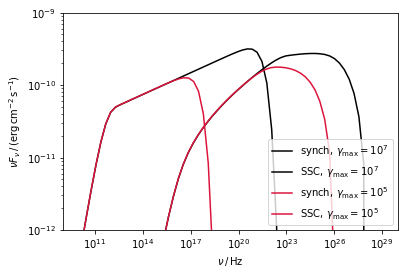

In [16]:
plot_sed(nu_synch, synch.sed_flux(nu_synch), color="k", label=r"${\rm synch},\,\gamma_{\rm max}=10^7$")
plot_sed(nu_ssc, ssc.sed_flux(nu_ssc), color="k", label=r"${\rm SSC},\,\gamma_{\rm max}=10^7$")
plot_sed(nu_synch, synch2.sed_flux(nu_synch), color="crimson", label=r"${\rm synch},\,\gamma_{\rm max}=10^5$")
plot_sed(nu_ssc, ssc2.sed_flux(nu_ssc), color="crimson", label=r"${\rm SSC},\,\gamma_{\rm max}=10^5$")
# select the same x and y range of the figure
plt.xlim([1e9, 1e30])
plt.ylim([1e-12, 1e-9])
plt.show()

## Validation: compare the same result with JetSet

In [17]:
# jetset
from jetset.jet_model import Jet

jet = Jet(
    name="ssc",
    electron_distribution="pl",
    electron_distribution_log_values=False,
    beaming_expr="bulk_theta",
)
jet.set_par("N", val=blob.n_e_tot.value)
jet.set_par("p", val=blob.n_e.p)
jet.set_par("gmin", val=blob.n_e.gamma_min)
jet.set_par("gmax", val=blob.n_e.gamma_max)
jet.set_par("R", val=blob.R_b.value)
jet.set_par("B", val=blob.B.value)
jet.set_par("BulkFactor", val=blob.Gamma)
jet.set_par("theta", val=blob.theta_s.value)
jet.set_par("z_cosm", val=blob.z)
# remove SSA
jet.spectral_components.Sync.state = "on"

# - synchrotron SED with jetset
jet.set_nu_grid(nu_synch[0].value, nu_synch[-1].value, len(nu_synch))
jet.eval()

nu_synch_jetset = jet.spectral_components.Sync.SED.nu
sed_synch_jetset = jet.spectral_components.Sync.SED.nuFnu

# - SSC SED with jetset
jet.set_nu_grid(nu_ssc[0].value, nu_ssc[-1].value, len(nu_ssc))
jet.eval()

nu_ssc_jetset = jet.spectral_components.SSC.SED.nu
sed_ssc_jetset = jet.spectral_components.SSC.SED.nuFnu

In [42]:
synch_dermer = pkg_resources.resource_filename(
    "agnpy",
    "data/reference_seds/dermer_menon_2009/figure_7_4/synchrotron_gamma_max_1e7.txt",
)

ssc_dermer = pkg_resources.resource_filename(
    "agnpy", "data/reference_seds/dermer_menon_2009/figure_7_4/ssc_gamma_max_1e7.txt"
)

In [43]:
data_synch_dermer = np.loadtxt(synch_dermer, delimiter=",")
data_ssc_dermer = np.loadtxt(ssc_dermer, delimiter=",")

nu_synch_dermer = data_synch_dermer[:, 0] * u.Hz
sed_synch_dermer = data_synch_dermer[:, 1] * u.Unit("erg cm-2 s-1")

nu_ssc_dermer = data_ssc_dermer[:, 0] * u.Hz
sed_ssc_dermer = data_ssc_dermer[:, 1] * u.Unit("erg cm-2 s-1")

(1e-13, 1e-08)

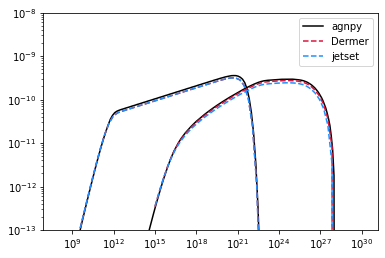

In [49]:
fig, ax = plt.subplots()

ax.loglog(nu_synch_dermer, sed_synch_dermer, color="k", label="agnpy")
ax.loglog(nu_ssc_dermer, sed_ssc_dermer, color="k")

ax.loglog(nu_synch, sed_synch, color="crimson", ls="--", label="Dermer")
ax.loglog(nu_ssc, sed_ssc, color="crimson", ls="--")

ax.loglog(nu_synch_jetset, sed_synch_jetset, color="dodgerblue", ls="--", label="jetset")
ax.loglog(nu_ssc_jetset, sed_ssc_jetset, color="dodgerblue", ls="--")

ax.legend()
ax.set_ylim([1e-13, 1e-8])